## SBTi Target Status


Font 'default' does not have a glyph for '\U0001f4c8' [U+1f4c8], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\U0001f4c8' [U+1f4c8], substituting with a dummy symbol.


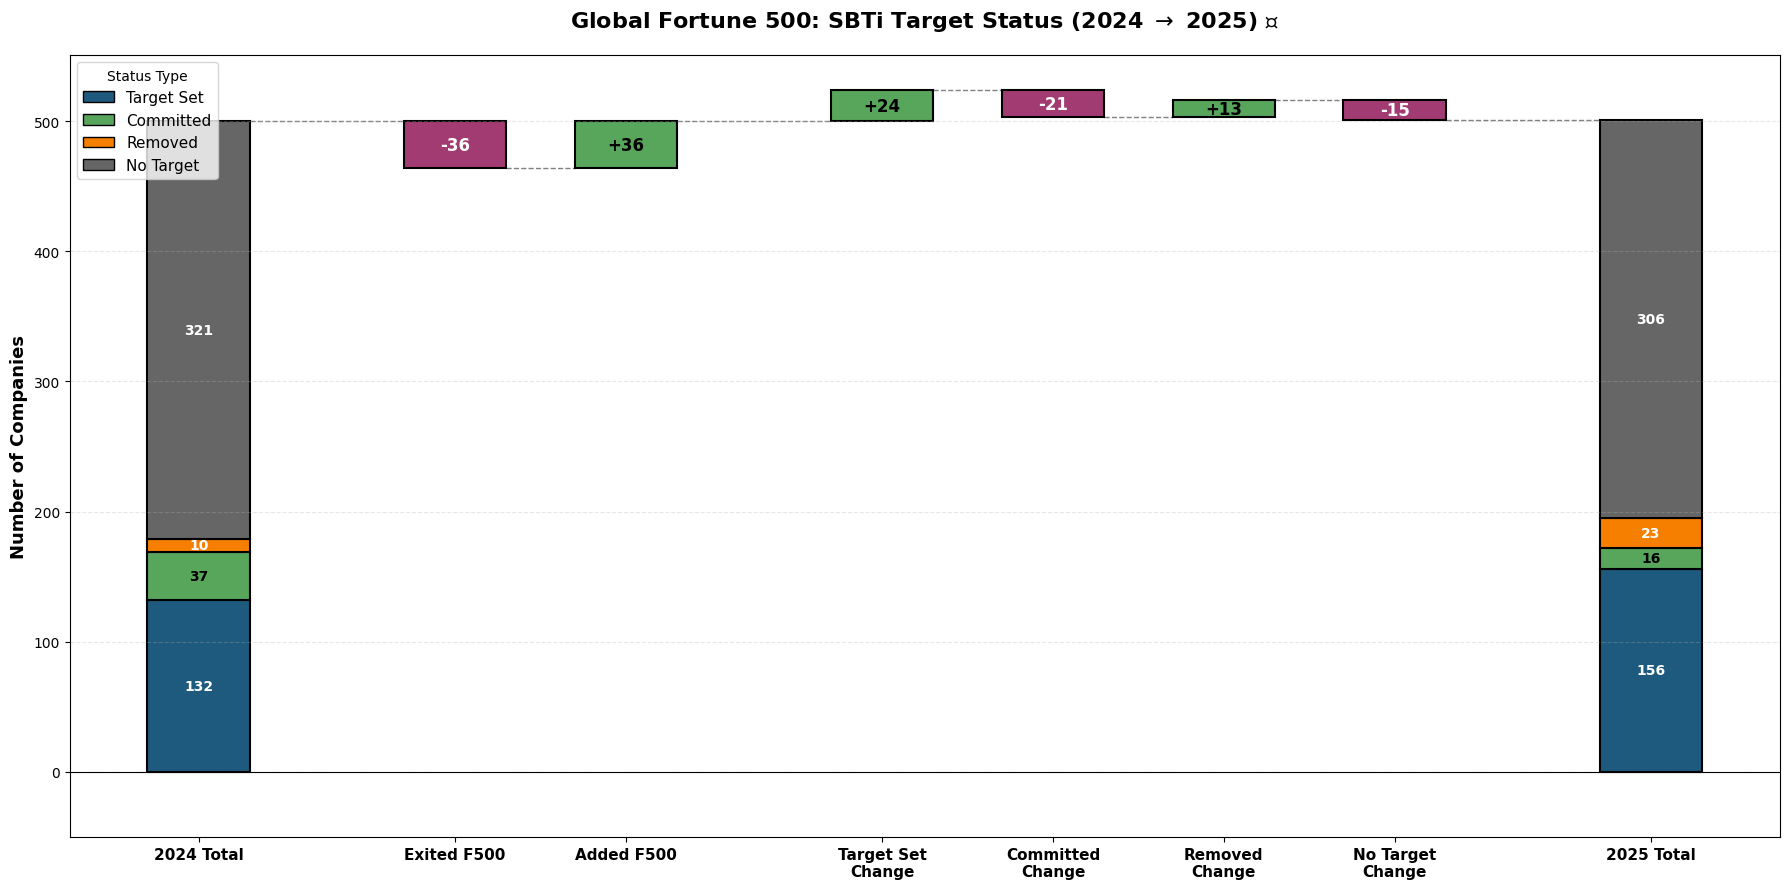

<Figure size 640x480 with 0 Axes>

In [50]:
import pandas as pd
import matplotlib.pyplot as plt

df_2024 = pd.read_csv('gf5002024.csv', encoding='latin-1')
df_2025 = pd.read_csv('gf5002026.csv', encoding='latin-1')

companies_2024 = set(df_2024['Company Name'].dropna())
companies_2025 = set(df_2025['Company Name'].dropna())

def map_status_2024(row):
    status = str(row['Target status - NT']).strip()
    if status == 'Targets Set': return 'Target Set'
    elif status == 'Committed': return 'Committed'
    elif status == 'Removed': return 'Removed'
    return 'No Target'

def map_status_2025(row):
    status = str(row['Target status (T = target set, C = committed, N=No, R=Removed)']).strip()
    if status in ['Targets set', 'T']: return 'Target Set'
    elif status in ['Committed', 'C']: return 'Committed'
    elif status in ['Removed', 'Commitment removed', 'R']: return 'Removed'
    return 'No Target'

s2024 = df_2024.apply(map_status_2024, axis=1).value_counts().to_dict()
s2025 = df_2025.apply(map_status_2025, axis=1).value_counts().to_dict()

# --- Custom Waterfall Colors and Status Order ---
STATUS_ORDER = ['Target Set', 'Committed', 'Removed', 'No Target']
COLOR_MAP = {
    'Target Set': '#1E5A7D',
    'Committed': '#58A55C',
    'Removed': '#F77F00',
    'No Target': '#666666',
    'Decrease': '#A23B72',  # General decrease/Exit
    'Increase': '#58A55C', # General increase/Add
}

# --- Data Setup (Your original logic) ---
categories = ['2024 Total', 'Exited F500', 'Added F500', 'Target Set\nChange', 
              'Committed\nChange', 'Removed\nChange', 'No Target\nChange', '2025 Total']
values = [
    sum(s2024.values()), # Use sum(s2024.values()) instead of fixed 500 for robustness
    -len(companies_2024 - companies_2025), 
    len(companies_2025 - companies_2024),
    s2025.get('Target Set', 0) - s2024.get('Target Set', 0),
    s2025.get('Committed', 0) - s2024.get('Committed', 0),
    s2025.get('Removed', 0) - s2024.get('Removed', 0),
    s2025.get('No Target', 0) - s2024.get('No Target', 0), 
    sum(s2025.values()) # Use sum(s2025.values())
]

# X-axis positions (adjusted for better spacing)
x_pos = [0, 1.5, 2.5, 4, 5, 6, 7, 8.5] 

# Calculate the cumulative base for drawing change bars
cumulative = [0]
for v in values[:-1]:
    cumulative.append(cumulative[-1] + v)

# --- NEW: Function to draw connectors ---
def draw_connector(ax, x_start, y_start, x_end):
    """Draws the horizontal connecting line from one bar to the next."""
    ax.plot([x_start + 0.3, x_end - 0.3], [y_start, y_start], 
            color='gray', linestyle='--', linewidth=1.0, zorder=0)

# --- Plotting ---
fig, ax = plt.subplots(figsize=(18, 9))
bar_width = 0.6
previous_bar_top = 0 # Track the top of the previous bar for drawing connectors

for i, (x, val) in enumerate(zip(x_pos, values)):
    is_total_bar = i == 0 or i == 7
    current_data = s2024 if i == 0 else s2025

    if is_total_bar:
        # Plot 2024 and 2025 Total Bars (Stacked)
        bottom = 0
        current_bar_top = 0
        
        # Plot each status segment
        for status in STATUS_ORDER:
            s_val = current_data.get(status, 0)
            
            # Use the status color from the map
            color = COLOR_MAP.get(status)
            
            ax.bar(x, s_val, bottom=bottom, color=color, width=bar_width, 
                   edgecolor='black', linewidth=1.5, label=status if i == 0 else None)
            
            # Add text label on the bar segment
            if s_val > 0:
                text_y = bottom + s_val / 2
                # Choose text color based on bar color for visibility
                text_color = 'white' if status in ['Target Set', 'No Target', 'Removed'] else 'black'
                ax.text(x, text_y, f'{s_val}', ha='center', va='center', fontsize=10, 
                        fontweight='bold', color=text_color)

            bottom += s_val
            current_bar_top = bottom

    else:
        # Plot Change Bars
        is_negative = val < 0
        
        # Determine color for change bars
        if i == 1: # Exited F500
            col = COLOR_MAP['Decrease'] 
        elif i == 2: # Added F500
            col = COLOR_MAP['Increase']
        elif is_negative:
            col = COLOR_MAP['Decrease'] # Use decrease color for status loss
        else:
            col = COLOR_MAP['Increase'] # Use increase color for status gain
            
        # The base of the bar is the cumulative total
        bottom = cumulative[i] if val > 0 else cumulative[i] + val
        ax.bar(x, abs(val), bottom=bottom, color=col, width=bar_width, 
               edgecolor='black', linewidth=1.5)
        
        # Add text label in the middle of the change bar
        text_y = cumulative[i] + val / 2
        ax.text(x, text_y, f'{val:+d}', ha='center', va='center', fontsize=12, 
                fontweight='bold', color='white' if col != COLOR_MAP['Increase'] else 'black')
        
        current_bar_top = cumulative[i] + val

    # --- Draw Connector Lines (Except after the last bar) ---
    if i < len(x_pos) - 1:
        # Draw the line from the top of the current bar to the base of the next bar
        draw_connector(ax, x, current_bar_top, x_pos[i+1])
        
    previous_bar_top = current_bar_top


# --- Styling and Annotations ---
ax.set_xticks(x_pos)
ax.set_xticklabels(categories, fontsize=11, fontweight='bold')
ax.set_ylabel('Number of Companies', fontsize=13, fontweight='bold')
ax.set_title('Global Fortune 500: SBTi Target Status (2024 $\\to$ 2025) 📈', fontsize=16, fontweight='bold', pad=20)

# Re-create legend using the correct colors and only for the status segments
legend_handles = [plt.Rectangle((0,0),1,1, fc=COLOR_MAP[key], ec='black') for key in STATUS_ORDER]
ax.legend(legend_handles, STATUS_ORDER, loc='upper left', fontsize=11, title='Status Type', frameon=True)

ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.axhline(y=0, color='black', linewidth=0.8)
ax.set_ylim(-50, max(values[0], values[-1]) + 50) # Set Y-limit based on total

plt.tight_layout()
plt.show()
plt.savefig('waterfall_sbti_modified.png', dpi=300, bbox_inches='tight')

In [47]:
import pandas as pd
import plotly.graph_objects as go

df_2024 = pd.read_csv('gf5002024.csv', encoding='latin-1')
df_2025 = pd.read_csv('gf5002026.csv', encoding='latin-1')

def map_status_2024(row):
    status = str(row['Target status - NT']).strip()
    if status == 'Targets Set': return 'Target Set'
    elif status == 'Committed': return 'Committed'
    elif status == 'Removed': return 'Removed'
    return 'No Target'

def map_status_2025(row):
    status = str(row['Target status (T = target set, C = committed, N=No, R=Removed)']).strip()
    if status in ['Targets set', 'T']: return 'Target Set'
    elif status in ['Committed', 'C']: return 'Committed'
    elif status in ['Removed', 'Commitment removed', 'R']: return 'Removed'
    return 'No Target'

companies_2024 = set(df_2024['Company Name'].dropna())
companies_2025 = set(df_2025['Company Name'].dropna())
continuing = companies_2024 & companies_2025

df_2024_indexed = df_2024.set_index('Company Name')
df_2025_indexed = df_2025.set_index('Company Name')

transitions = {}
for company in continuing:
    old = map_status_2024(df_2024_indexed.loc[company])
    new = map_status_2025(df_2025_indexed.loc[company])
    transitions[(old, new)] = transitions.get((old, new), 0) + 1

labels = ['2024: Target Set', '2024: Committed', '2024: Removed', '2024: No Target',
          '2025: Target Set', '2025: Committed', '2025: Removed', '2025: No Target']
label_map = {'Target Set': 0, 'Committed': 1, 'Removed': 2, 'No Target': 3}

source, target, value, link_colors = [], [], [], []

for (old, new), count in transitions.items():
    src = label_map[old]
    tgt = label_map[new] + 4
    source.append(src)
    target.append(tgt)
    value.append(count)
    
    if src == tgt - 4:
        link_colors.append('rgba(200, 200, 200, 0.3)')
    elif src == 0:
        link_colors.append('rgba(30, 90, 125, 0.5)')
    elif src == 1:
        link_colors.append('rgba(88, 165, 92, 0.5)')
    elif src == 2:
        link_colors.append('rgba(247, 127, 0, 0.5)')
    else:
        link_colors.append('rgba(102, 102, 102, 0.5)')

fig = go.Figure(data=[go.Sankey(
    node=dict(pad=15, thickness=20, label=labels, 
              color=['#1E5A7D', '#58A55C', '#F77F00', '#666666', '#1E5A7D', '#58A55C', '#F77F00', '#666666']),
    link=dict(source=source, target=target, value=value, color=link_colors)
)])

fig.update_layout(title_text="SBTi Target Status Transitions (2024 → 2025)", font_size=12, height=600)
fig.write_html('sankey_sbti.html')

## RE100

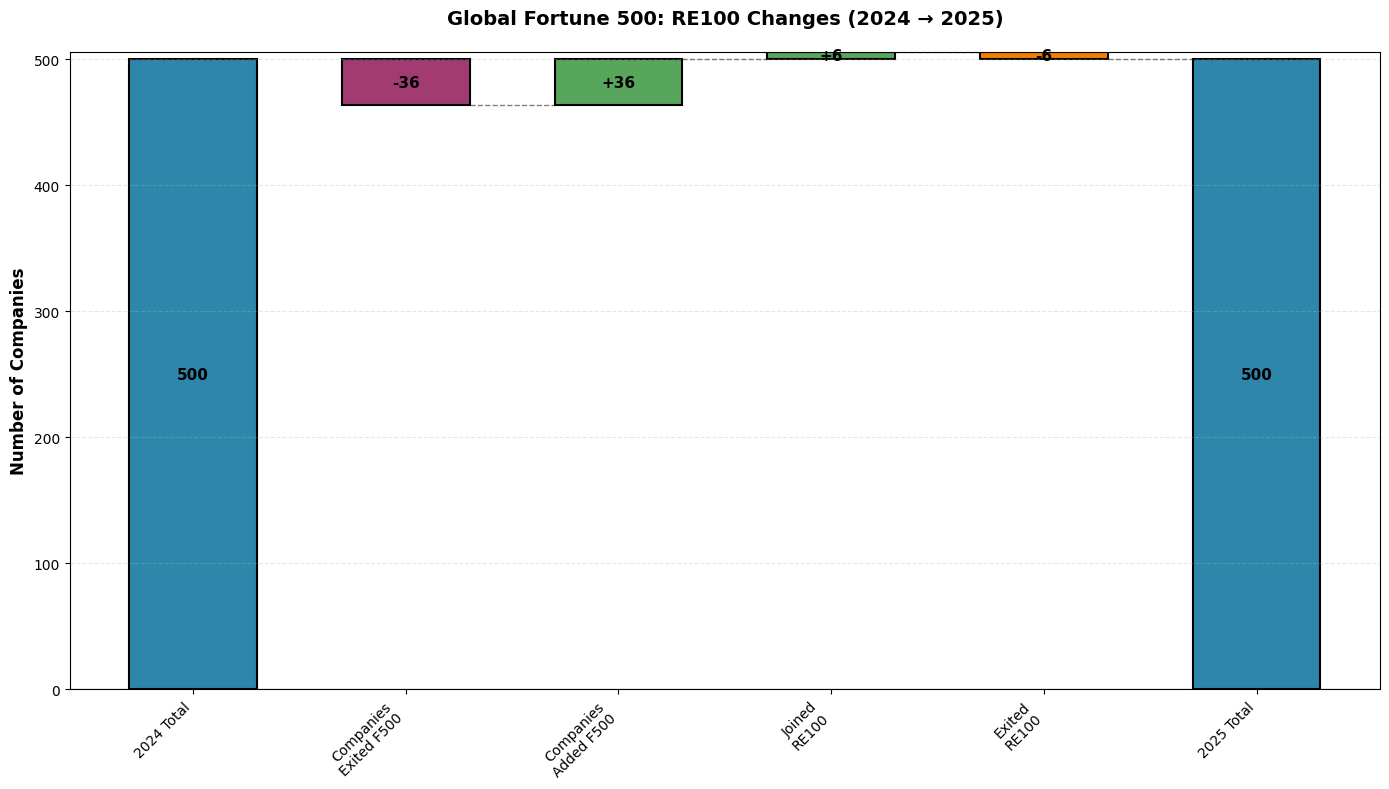

Joined RE100: 6
['Tongwei Group', 'Hon Hai Precision Industry', 'SK', 'Chevron', 'La Poste', 'Commonwealth Bank of Australia']

Exited RE100: 6
['Daiwa House Industry', 'Meta Platforms', 'Capital One Financial', 'Morgan Stanley', 'Siemens', 'Procter & Gamble']


In [21]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data
df_2024 = pd.read_csv('gf5002024.csv', encoding='latin-1')
df_2025 = pd.read_csv('gf5002026.csv', encoding='latin-1')

# Get company sets
companies_2024 = set(df_2024['Company Name'].dropna())
companies_2025 = set(df_2025['Company Name'].dropna())
continuing = companies_2024 & companies_2025

# Map RE100 status
def map_re100(row):
    status = str(row['RE100 (Y/N)']).strip()
    return 'In RE100' if status in ['Yes', 'Y'] else 'Not in RE100'

# Track changes for continuing companies
df_2024_indexed = df_2024.set_index('Company Name')
df_2025_indexed = df_2025.set_index('Company Name')

joined = []
exited_re = []

for company in continuing:
    old = map_re100(df_2024_indexed.loc[company])
    new = map_re100(df_2025_indexed.loc[company])
    if old == 'Not in RE100' and new == 'In RE100':
        joined.append(company)
    elif old == 'In RE100' and new == 'Not in RE100':
        exited_re.append(company)

# Build waterfall
categories = ['2024 Total', 'Companies\nExited F500', 'Companies\nAdded F500', 
              'Joined\nRE100', 'Exited\nRE100', '2025 Total']
values = [500, -len(companies_2024 - companies_2025), len(companies_2025 - companies_2024), 
          len(joined), -len(exited_re), 500]
colors = ['#2E86AB', '#A23B72', '#58A55C', '#58A55C', '#F77F00', '#2E86AB']

# Calculate cumulative
cumulative = [0]
for i, val in enumerate(values[:-1]):
    cumulative.append(val if i == 0 else cumulative[-1] + val)

# Plot
fig, ax = plt.subplots(figsize=(14, 8))

for i, (cat, val, col) in enumerate(zip(categories, values, colors)):
    if i == 0 or i == len(categories) - 1:
        ax.bar(i, val, color=col, width=0.6, edgecolor='black', linewidth=1.5)
        label_pos = val / 2
        label = f'{val}'
    else:
        ax.bar(i, val, bottom=cumulative[i], color=col, width=0.6, edgecolor='black', linewidth=1.5)
        label_pos = cumulative[i] + val / 2
        label = f'{val:+d}'
        if i < len(categories) - 1:
            ax.plot([i + 0.3, i + 0.7], [cumulative[i+1], cumulative[i+1]], 'k--', linewidth=1, alpha=0.5)
    
    ax.text(i, label_pos, label, ha='center', va='center', fontsize=11, fontweight='bold')

ax.set_xticks(range(len(categories)))
ax.set_xticklabels(categories, rotation=45, ha='right', fontsize=10)
ax.set_ylabel('Number of Companies', fontsize=12, fontweight='bold')
ax.set_title('Global Fortune 500: RE100 Changes (2024 → 2025)', fontsize=14, fontweight='bold', pad=20)
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.axhline(y=0, color='black', linewidth=0.8)

plt.tight_layout()
plt.savefig('waterfall_re100.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Joined RE100: {len(joined)}")
print(joined)
print(f"\nExited RE100: {len(exited_re)}")
print(exited_re)

In [74]:
import pandas as pd
import plotly.graph_objects as go

df_2024 = pd.read_csv('gf5002024.csv', encoding='latin-1')
df_2025 = pd.read_csv('gf5002026.csv', encoding='latin-1')

def map_re100(row):
    status = str(row['RE100 (Y/N)']).strip()
    return 'In RE100' if status in ['Yes', 'Y'] else 'Not in RE100'

companies_2024 = set(df_2024['Company Name'].dropna())
companies_2025 = set(df_2025['Company Name'].dropna())
continuing = companies_2024 & companies_2025

df_2024_indexed = df_2024.set_index('Company Name')
df_2025_indexed = df_2025.set_index('Company Name')

transitions = {}
for company in continuing:
    old = map_re100(df_2024_indexed.loc[company])
    new = map_re100(df_2025_indexed.loc[company])
    transitions[(old, new)] = transitions.get((old, new), 0) + 1

labels = ['2024: In RE100', '2024: Not in RE100', '2025: In RE100', '2025: Not in RE100']
label_map = {'In RE100': 0, 'Not in RE100': 1}

source, target, value, link_colors = [], [], [], []

for (old, new), count in transitions.items():
    src = label_map[old]
    tgt = label_map[new] + 2
    source.append(src)
    target.append(tgt)
    value.append(count)
    
    if src == 0:
        link_colors.append('rgba(16, 79, 25, 0.5)')
    else:
        link_colors.append('rgba(38, 54, 13, 0.5)')

fig = go.Figure(data=[go.Sankey(
    node=dict(pad=15, thickness=20, label=labels, color=["#104F19", "#26360D", "#BEF7B1", "#8B9C6B"]),
    link=dict(source=source, target=target, value=value, color=link_colors)
)])

fig.update_layout(title_text="RE100 Status Transitions (2024 → 2025)", font_size=12, height=600)
fig.write_html('sankey_re100.html')

In [75]:
import pandas as pd
import plotly.graph_objects as go

df_2024 = pd.read_csv('gf5002024.csv', encoding='latin-1')
df_2025 = pd.read_csv('gf5002026.csv', encoding='latin-1')

def map_re100(row):
    status = str(row['RE100 (Y/N)']).strip()
    return 'RE100' if status in ['Yes', 'Y'] else 'No RE100'

companies_2024 = set(df_2024['Company Name'].dropna())
companies_2025 = set(df_2025['Company Name'].dropna())
exited = companies_2024 - companies_2025
added = companies_2025 - companies_2024
continuing = companies_2024 & companies_2025

df_2024_indexed = df_2024.set_index('Company Name')
df_2025_indexed = df_2025.set_index('Company Name')

labels = ['2024: RE100', '2024: No RE100', 'Exited: RE100', 'Exited: No RE100', 
          'Continuing: RE100', 'Continuing: No RE100', 'Added: RE100', 'Added: No RE100',
          '2025: RE100', '2025: No RE100']

source, target, value, link_colors = [], [], [], []

# 2024 to Exited/Continuing
for company in exited:
    status = map_re100(df_2024_indexed.loc[company])
    if status == 'RE100':
        source.append(0)
        target.append(2)
    else:
        source.append(1)
        target.append(3)
    value.append(1)
    link_colors.append('rgba(200, 0, 0, 0.3)')

for company in continuing:
    status = map_re100(df_2024_indexed.loc[company])
    if status == 'RE100':
        source.append(0)
        target.append(4)
    else:
        source.append(1)
        target.append(5)
    value.append(1)
    link_colors.append('rgba(100, 100, 100, 0.2)')

# Continuing transitions
for company in continuing:
    old = map_re100(df_2024_indexed.loc[company])
    new = map_re100(df_2025_indexed.loc[company])
    if old == 'RE100' and new == 'RE100':
        source.append(4)
        target.append(8)
    elif old == 'RE100' and new == 'No RE100':
        source.append(4)
        target.append(9)
    elif old == 'No RE100' and new == 'RE100':
        source.append(5)
        target.append(8)
    else:
        source.append(5)
        target.append(9)
    value.append(1)
    link_colors.append('rgba(16, 79, 25, 0.4)' if new == 'RE100' else 'rgba(38, 54, 13, 0.4)')

# Added to 2025
for company in added:
    status = map_re100(df_2025_indexed.loc[company])
    if status == 'RE100':
        source.append(6)
        target.append(8)
    else:
        source.append(7)
        target.append(9)
    value.append(1)
    link_colors.append('rgba(0, 200, 0, 0.3)')

# Aggregate flows
flow_dict = {}
color_dict = {}
for s, t, v, c in zip(source, target, value, link_colors):
    key = (s, t)
    flow_dict[key] = flow_dict.get(key, 0) + v
    color_dict[key] = c

source_agg = [k[0] for k in flow_dict.keys()]
target_agg = [k[1] for k in flow_dict.keys()]
value_agg = list(flow_dict.values())
colors_agg = [color_dict[k] for k in flow_dict.keys()]

fig = go.Figure(data=[go.Sankey(
    node=dict(pad=15, thickness=20, label=labels),
    link=dict(source=source_agg, target=target_agg, value=value_agg, color=colors_agg)
)])

fig.update_layout(title_text="RE100 Transitions with Entry/Exit (2024 → 2025)", font_size=12, height=800)
fig.write_html('sankey_re100_full.html')

In [ ]:

import pandas as pd
import plotly.graph_objects as go

df_2024 = pd.read_csv('gf5002024.csv', encoding='latin-1')
df_2025 = pd.read_csv('gf5002026.csv', encoding='latin-1')

def map_re100(row):
    status = str(row['RE100 (Y/N)']).strip()
    return 'RE100' if status in ['Yes', 'Y'] else 'No RE100'

companies_2024 = set(df_2024['Company Name'].dropna())
companies_2025 = set(df_2025['Company Name'].dropna())
exited = companies_2024 - companies_2025
added = companies_2025 - companies_2024
continuing = companies_2024 & companies_2025

df_2024_indexed = df_2024.set_index('Company Name')
df_2025_indexed = df_2025.set_index('Company Name')

labels = ['2024: GF500 in RE100', '2024: GF500 Not RE100', 'Exited GF500 was RE100', 'Exited GF500 wasnt RE100', 
          'stayed in RE100', 'stayed No RE100', 'joined GF500 and is RE100', 'joined GF500 is Not RE100',
          '2025: GF500 in RE100', '2025 GF500 Not RE100']

source, target, value, link_colors = [], [], [], []

for company in exited:
    status = map_re100(df_2024_indexed.loc[company])
    source.append(0 if status == 'RE100' else 1)
    target.append(2 if status == 'RE100' else 3)
    value.append(1)
    link_colors.append('rgba(230, 47, 72, 0.4)')

for company in continuing:
    status = map_re100(df_2024_indexed.loc[company])
    source.append(0 if status == 'RE100' else 1)
    target.append(4 if status == 'RE100' else 5)
    value.append(1)
    link_colors.append('rgba(0, 13, 100, 24, 0.3)')

for company in continuing:
    old = map_re100(df_2024_indexed.loc[company])
    new = map_re100(df_2025_indexed.loc[company])
    src = 4 if old == 'RE100' else 5
    tgt = 8 if new == 'RE100' else 9
    source.append(src)
    target.append(tgt)
    value.append(1)
    link_colors.append('rgba(16, 79, 25, 0.5)' if new == 'RE100' else 'rgba(38, 54, 13, 0.5)')

for company in added:
    status = map_re100(df_2025_indexed.loc[company])
    source.append(6 if status == 'RE100' else 7)
    target.append(8 if status == 'RE100' else 9)
    value.append(1)
    link_colors.append('rgba(0, 150, 0, 0.4)')

flow_dict = {}
color_dict = {}
for s, t, v, c in zip(source, target, value, link_colors):
    key = (s, t)
    flow_dict[key] = flow_dict.get(key, 0) + v
    color_dict[key] = c

source_agg = [k[0] for k in flow_dict.keys()]
target_agg = [k[1] for k in flow_dict.keys()]
value_agg = list(flow_dict.values())
colors_agg = [color_dict[k] for k in flow_dict.keys()]

fig = go.Figure(data=[go.Sankey(
    node=dict(pad=15, thickness=20, label=labels),
    link=dict(source=source_agg, target=target_agg, value=value_agg, color=colors_agg)
)])

fig.add_annotation(text="<b>Flow Colors:</b><br>Red = Exited F500 | Gray = Continuing | Green = Added to F500 | Dark Green/Brown = Status Changes",
                   xref="paper", yref="paper", x=0.5, y=1.1, showarrow=False,
                   font=dict(size=12), align="center")

fig.update_layout(title_text="RE100 Transitions with Entry/Exit (2024 → 2025)", 
                  font_size=12, height=800, margin=dict(t=100))
fig.write_html('sankey_re100_full.html')


## Carbon Credits


Font 'default' does not have a glyph for '\U0001f4c9' [U+1f4c9], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\U0001f4c9' [U+1f4c9], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\U0001f4c9' [U+1f4c9], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\U0001f4c9' [U+1f4c9], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\U0001f4c9' [U+1f4c9], substituting with a dummy symbol.


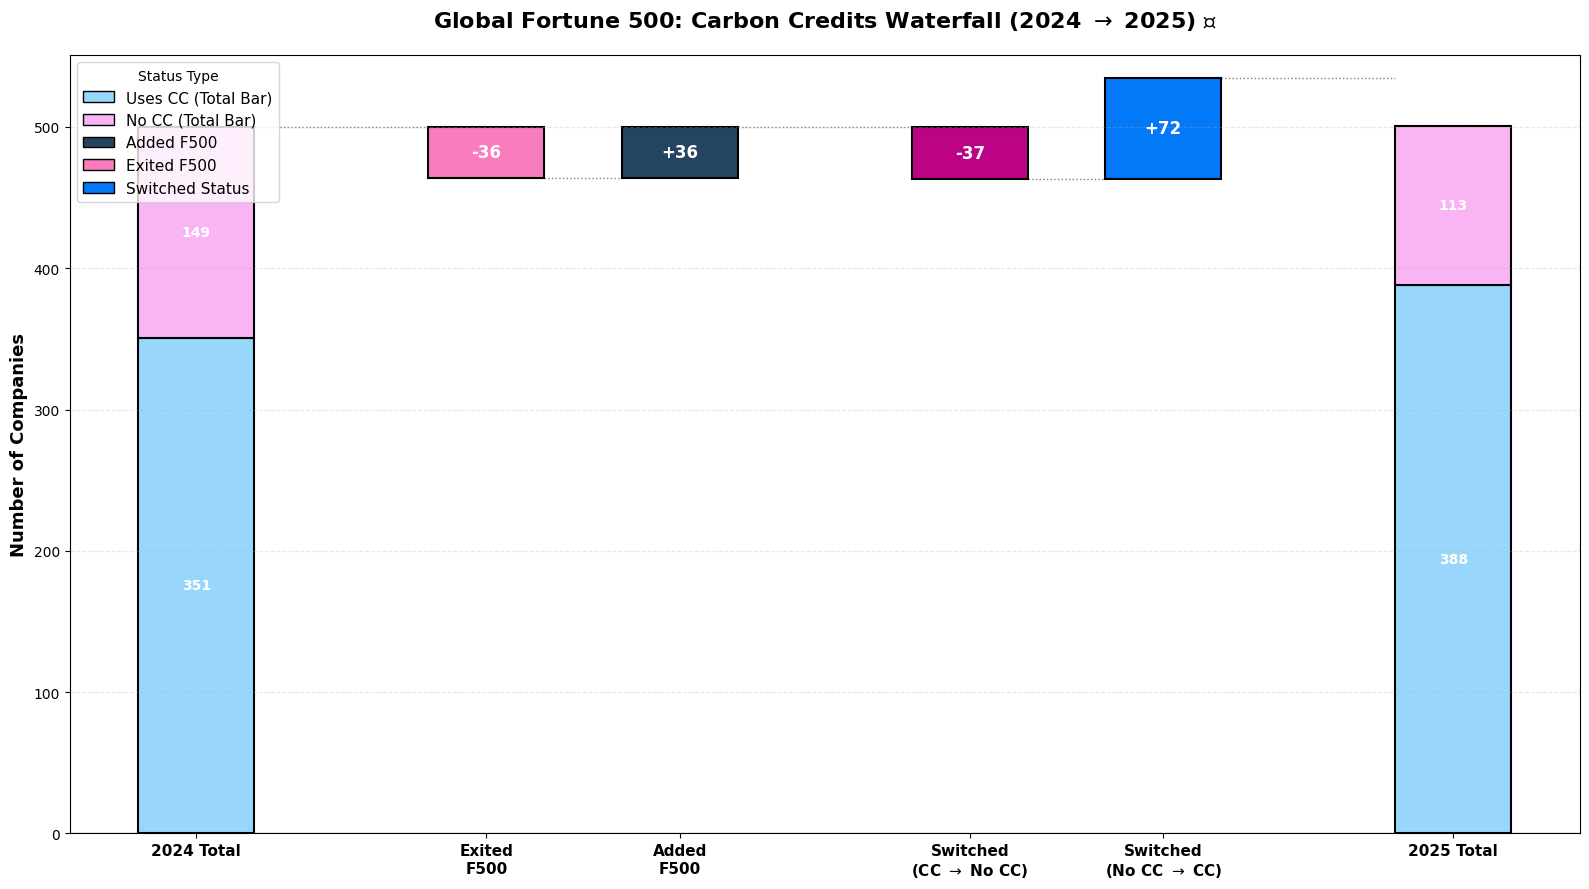

In [71]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# --- Data Loading and Preparation (Same as original) ---
df_2024 = pd.read_csv('gf5002024.csv', encoding='latin-1')
df_2025 = pd.read_csv('gf5002026.csv', encoding='latin-1')

companies_2024 = set(df_2024['Company Name'].dropna())
companies_2025 = set(df_2025['Company Name'].dropna())
continuing = companies_2024 & companies_2025

def map_cc_2024(row):
    cc1 = str(row['Carbon credits (Y = yes, N = no, R = removals only, U = unclear)']).strip()
    cc2 = str(row['Carbon credits (Y = yes, N = no, R = removals only, U = unclear).1']).strip()
    return 'Uses CC' if cc1 in ['Y', 'R', 'U'] or cc2 in ['Y', 'R', 'U'] else 'No CC'

def map_cc_2025(row):
    cc = str(row['Carbon credits (Y = yes, N = no, R = removals only, U = unclear).1']).strip()
    return 'Uses CC' if cc in ['Yes', 'Y', 'R', 'U', 'Not Specified'] else 'No CC'

df_2024_indexed = df_2024.set_index('Company Name')
df_2025_indexed = df_2025.set_index('Company Name')

# --- 1. Calculate Initial and Final Status Counts ---
s2024_cc = df_2024.apply(map_cc_2024, axis=1).value_counts().to_dict()
s2025_cc = df_2025.apply(map_cc_2025, axis=1).value_counts().to_dict()

# --- 2. Calculate Behavioral Changes (Only for continuing companies) ---
started = sum(1 for c in continuing if map_cc_2024(df_2024_indexed.loc[c]) == 'No CC' and map_cc_2025(df_2025_indexed.loc[c]) == 'Uses CC')
stopped = sum(1 for c in continuing if map_cc_2024(df_2024_indexed.loc[c]) == 'Uses CC' and map_cc_2025(df_2025_indexed.loc[c]) == 'No CC')

# --- 3. Define the Corrected Categories and Values (REORDERED) ---

categories = [
    '2024 Total', 
    'Exited\nF500', 
    'Added\nF500',
    'Switched\n(CC $\\to$ No CC)',     # NEGATIVE change placed first
    'Switched\n(No CC $\\to$ CC)',    # POSITIVE change placed second
    '2025 Total'
]

values = [
    sum(s2024_cc.values()),         # 2024 Total
    -len(companies_2024 - companies_2025), # Exited F500 
    len(companies_2025 - companies_2024),  # Added F500 
    -stopped,                             # Companies that stopped using CC (Negative change)
    started,                              # Companies that started using CC (Positive change)
    sum(s2025_cc.values())          # 2025 Total
]

# --- 4. Define Custom Waterfall Colors and Status Order ---
STATUS_ORDER = ['Uses CC', 'No CC']
COLOR_MAP = {
    'Uses CC': "#98D7FB",   
    'No CC': "#F8B4F3",     
    'Exited': "#F87CBE",    
    'Added': "#254461",     
    'Switched_In': "#0379F8", # Started using CC (Positive change)
    'Switched_Out': "#BD0385",# Stopped using CC (Negative change)
}

# X-axis positions (adjusted for spacing)
x_pos = [0, 1.5, 2.5, 4, 5, 6.5]

# Calculate the cumulative base for drawing change bars
cumulative = [0]
for v in values[:-1]:
    cumulative.append(cumulative[-1] + v)

# --- NEW: Function to draw connectors ---
def draw_connector(ax, x_start, y_start, x_end):
    """Draws the horizontal connecting line from one bar to the next."""
    ax.plot([x_start + 0.3, x_end - 0.3], [y_start, y_start],
            color='gray', linestyle='dotted', linewidth=1.0, zorder=0)

# --- 5. Plotting ---
fig, ax = plt.subplots(figsize=(16, 9))
bar_width = 0.6
previous_bar_top = 0 

for i, (x, val) in enumerate(zip(x_pos, values)):
    is_total_bar = i == 0 or i == len(x_pos) - 1
    current_data = s2024_cc if i == 0 else s2025_cc

    if is_total_bar:
        # Plot 2024 and 2025 Total Bars (Stacked)
        bottom = 0
        current_bar_top = 0
        
        # Plot each CC status segment
        for status in STATUS_ORDER:
            s_val = current_data.get(status, 0)
            color = COLOR_MAP.get(status)
            
            ax.bar(x, s_val, bottom=bottom, color=color, width=bar_width, 
                   edgecolor='black', linewidth=1.5, label=status if i == 0 else None)
            
            # Add text label on the bar segment
            if s_val > 0:
                text_y = bottom + s_val / 2
                text_color = 'white' if status in ['Uses CC', 'No CC'] else 'black'
                ax.text(x, text_y, f'{s_val}', ha='center', va='center', fontsize=10, 
                        fontweight='bold', color=text_color)

            bottom += s_val
            current_bar_top = bottom

    else:
        # Plot Change Bars (Single Bar)
        
        # Determine color for change bars based on the category (index)
        if i == 1: # Exited F500
            col = COLOR_MAP['Exited'] 
        elif i == 2: # Added F500
            col = COLOR_MAP['Added']
        elif i == 3: # Switched (CC -> No CC)
            col = COLOR_MAP['Switched_Out']
        elif i == 4: # Switched (No CC -> CC)
            col = COLOR_MAP['Switched_In']
        
        # The base of the bar is the cumulative total
        bottom = cumulative[i] if val > 0 else cumulative[i] + val
        ax.bar(x, abs(val), bottom=bottom, color=col, width=bar_width, 
               edgecolor='black', linewidth=1.5)
        
        # Add text label in the middle of the change bar
        text_y = cumulative[i] + val / 2
        ax.text(x, text_y, f'{val:+d}', ha='center', va='center', fontsize=12, 
                fontweight='bold', color='white')
        
        current_bar_top = cumulative[i] + val

    # --- Draw Connector Lines (Except after the last bar) ---
    if i < len(x_pos) - 1:
        # Draw the line from the top of the current bar to the base of the next bar
        draw_connector(ax, x, current_bar_top, x_pos[i+1])
        
    previous_bar_top = current_bar_top


# --- 6. Styling and Annotations ---
ax.set_xticks(x_pos)
ax.set_xticklabels(categories, fontsize=11, fontweight='bold')
ax.set_ylabel('Number of Companies', fontsize=13, fontweight='bold')
ax.set_title('Global Fortune 500: Carbon Credits Waterfall (2024 $\\to$ 2025) 📉', fontsize=16, fontweight='bold', pad=20)

# Re-create legend
legend_handles = [
    plt.Rectangle((0,0),1,1, fc=COLOR_MAP['Uses CC'], ec='black'), 
    plt.Rectangle((0,0),1,1, fc=COLOR_MAP['No CC'], ec='black'),
    plt.Rectangle((0,0),1,1, fc=COLOR_MAP['Added'], ec='black'),
    plt.Rectangle((0,0),1,1, fc=COLOR_MAP['Exited'], ec='black'),
    plt.Rectangle((0,0),1,1, fc=COLOR_MAP['Switched_In'], ec='black') 
]
legend_labels = ['Uses CC (Total Bar)', 'No CC (Total Bar)', 'Added F500', 'Exited F500', 'Switched Status']
ax.legend(legend_handles, legend_labels, loc='upper left', fontsize=11, title='Status Type', frameon=True)

ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.axhline(y=0, color='black', linewidth=0.8)
ax.set_ylim(0, max(values[0], values[-1]) * 1.1)

plt.tight_layout()
plt.savefig('waterfall_carbon_credits_reordered.png', dpi=300, bbox_inches='tight')
plt.show()

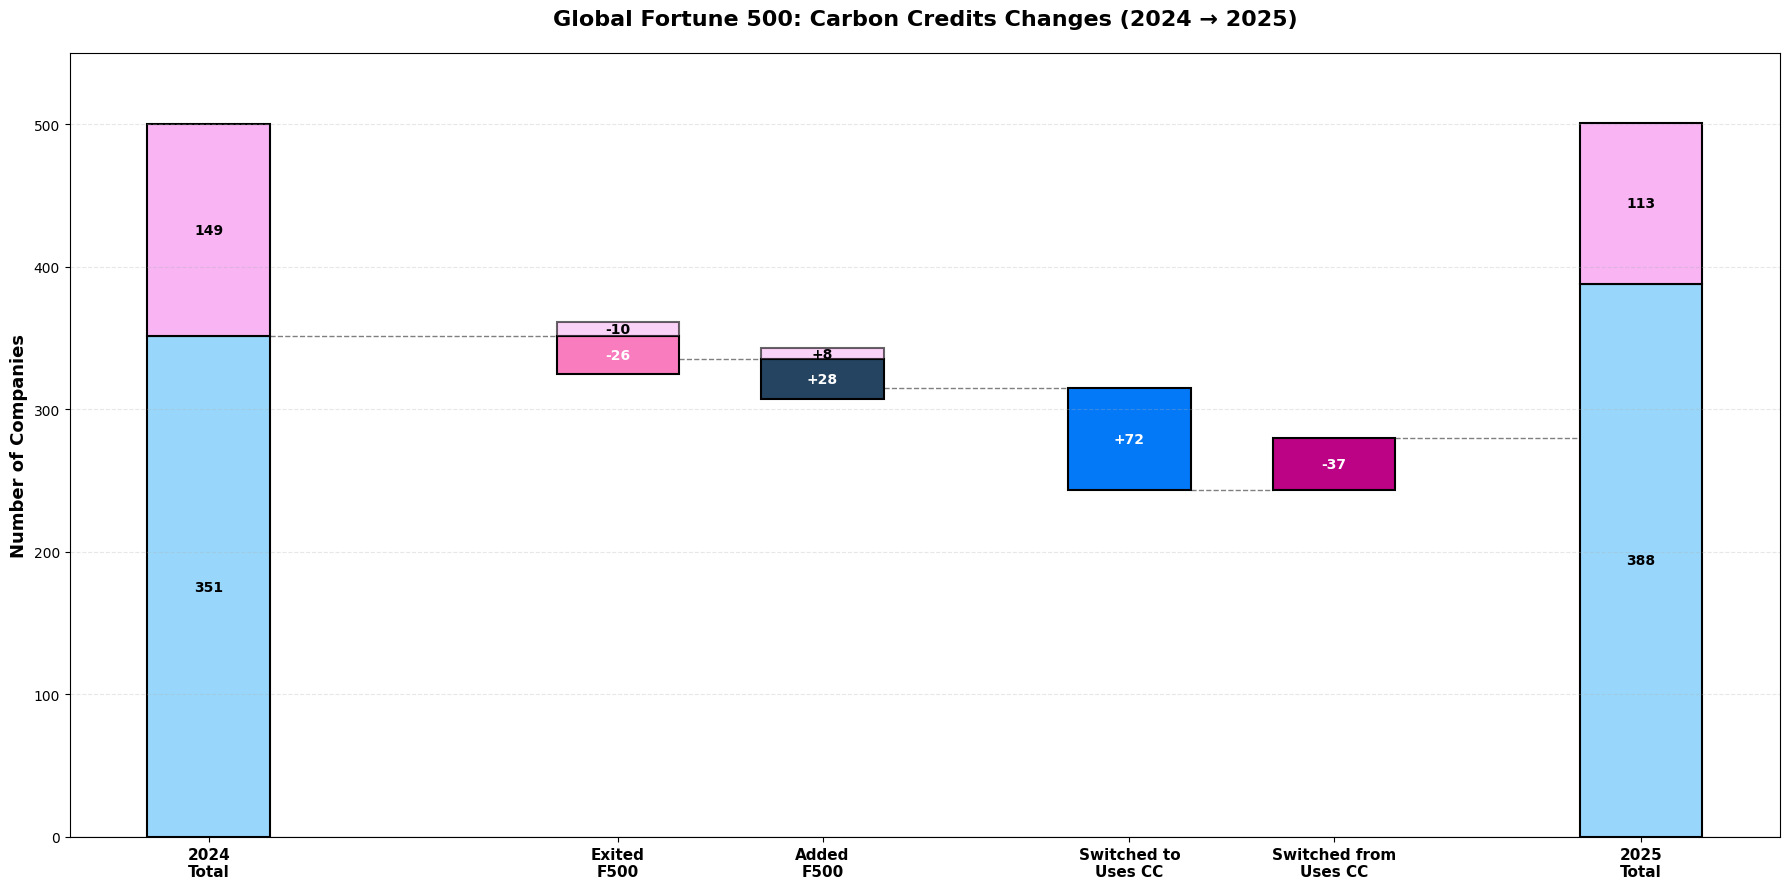

In [73]:
import pandas as pd
import matplotlib.pyplot as plt

df_2024 = pd.read_csv('gf5002024.csv', encoding='latin-1')
df_2025 = pd.read_csv('gf5002026.csv', encoding='latin-1')

companies_2024 = set(df_2024['Company Name'].dropna())
companies_2025 = set(df_2025['Company Name'].dropna())
continuing = companies_2024 & companies_2025

def map_cc_2024(row):
    cc1 = str(row['Carbon credits (Y = yes, N = no, R = removals only, U = unclear)']).strip()
    cc2 = str(row['Carbon credits (Y = yes, N = no, R = removals only, U = unclear).1']).strip()
    return 'Uses CC' if cc1 in ['Y', 'R', 'U'] or cc2 in ['Y', 'R', 'U'] else 'No CC'

def map_cc_2025(row):
    cc = str(row['Carbon credits (Y = yes, N = no, R = removals only, U = unclear).1']).strip()
    return 'Uses CC' if cc in ['Yes', 'Y', 'R', 'U', 'Not Specified'] else 'No CC'

df_2024_indexed = df_2024.set_index('Company Name')
df_2025_indexed = df_2025.set_index('Company Name')

exited = companies_2024 - companies_2025
added = companies_2025 - companies_2024

exited_cc = sum(1 for c in exited if map_cc_2024(df_2024_indexed.loc[c]) == 'Uses CC')
exited_no = len(exited) - exited_cc
added_cc = sum(1 for c in added if map_cc_2025(df_2025_indexed.loc[c]) == 'Uses CC')
added_no = len(added) - added_cc

switched_to = sum(1 for c in continuing if map_cc_2024(df_2024_indexed.loc[c]) == 'No CC' and map_cc_2025(df_2025_indexed.loc[c]) == 'Uses CC')
switched_from = sum(1 for c in continuing if map_cc_2024(df_2024_indexed.loc[c]) == 'Uses CC' and map_cc_2025(df_2025_indexed.loc[c]) == 'No CC')

s2024 = df_2024.apply(map_cc_2024, axis=1).value_counts().to_dict()
s2025 = df_2025.apply(map_cc_2025, axis=1).value_counts().to_dict()

cc_2024 = s2024.get('Uses CC', 0)
no_2024 = s2024.get('No CC', 0)
cc_2025 = s2025.get('Uses CC', 0)
no_2025 = s2025.get('No CC', 0)

fig, ax = plt.subplots(figsize=(18, 9))
x_pos = [0, 2, 3, 4.5, 5.5, 7]
bar_width = 0.6

COLOR_CC = "#98D7FB"
COLOR_NO = "#F8B4F3"
COLOR_EXIT_CC = "#F87CBE"
COLOR_EXIT_NO = "#F8B4F3"
COLOR_ADD_CC = "#254461"
COLOR_ADD_NO = "#F8B4F3"
COLOR_SWITCH_TO = "#0379F8"
COLOR_SWITCH_FROM = "#BD0385"

ax.bar(x_pos[0], cc_2024, color=COLOR_CC, width=bar_width, edgecolor='black', linewidth=1.5)
ax.bar(x_pos[0], no_2024, bottom=cc_2024, color=COLOR_NO, width=bar_width, edgecolor='black', linewidth=1.5)
ax.text(x_pos[0], cc_2024/2, f'{cc_2024}', ha='center', va='center', fontsize=10, fontweight='bold')
ax.text(x_pos[0], cc_2024 + no_2024/2, f'{no_2024}', ha='center', va='center', fontsize=10, fontweight='bold')

line_y = cc_2024
ax.plot([x_pos[0] + bar_width/2, x_pos[1] - bar_width/2], [line_y, line_y], 'k--', linewidth=1, alpha=0.5)

bottom_exit = line_y - exited_cc
ax.bar(x_pos[1], exited_cc, bottom=bottom_exit, color=COLOR_EXIT_CC, width=bar_width, edgecolor='black', linewidth=1.5)
ax.bar(x_pos[1], exited_no, bottom=line_y, color=COLOR_EXIT_NO, width=bar_width, edgecolor='black', linewidth=1.5, alpha=0.6)
ax.text(x_pos[1], bottom_exit + exited_cc/2, f'-{exited_cc}', ha='center', va='center', fontsize=10, fontweight='bold', color='white')
ax.text(x_pos[1], line_y + exited_no/2, f'-{exited_no}', ha='center', va='center', fontsize=10, fontweight='bold')

line_y = line_y - exited_cc + exited_no
ax.plot([x_pos[1] + bar_width/2, x_pos[2] - bar_width/2], [line_y, line_y], 'k--', linewidth=1, alpha=0.5)

ax.bar(x_pos[2], added_cc, bottom=line_y - added_cc, color=COLOR_ADD_CC, width=bar_width, edgecolor='black', linewidth=1.5)
ax.bar(x_pos[2], added_no, bottom=line_y, color=COLOR_ADD_NO, width=bar_width, edgecolor='black', linewidth=1.5, alpha=0.6)
ax.text(x_pos[2], line_y - added_cc/2, f'+{added_cc}', ha='center', va='center', fontsize=10, fontweight='bold', color='white')
ax.text(x_pos[2], line_y + added_no/2, f'+{added_no}', ha='center', va='center', fontsize=10, fontweight='bold')

line_y = line_y - added_cc + added_no
ax.plot([x_pos[2] + bar_width/2, x_pos[3] - bar_width/2], [line_y, line_y], 'k--', linewidth=1, alpha=0.5)

ax.bar(x_pos[3], switched_to, bottom=line_y - switched_to, color=COLOR_SWITCH_TO, width=bar_width, edgecolor='black', linewidth=1.5)
ax.text(x_pos[3], line_y - switched_to/2, f'+{switched_to}', ha='center', va='center', fontsize=10, fontweight='bold', color='white')

line_y -= switched_to
ax.plot([x_pos[3] + bar_width/2, x_pos[4] - bar_width/2], [line_y, line_y], 'k--', linewidth=1, alpha=0.5)

ax.bar(x_pos[4], switched_from, bottom=line_y, color=COLOR_SWITCH_FROM, width=bar_width, edgecolor='black', linewidth=1.5)
ax.text(x_pos[4], line_y + switched_from/2, f'-{switched_from}', ha='center', va='center', fontsize=10, fontweight='bold', color='white')

line_y += switched_from
ax.plot([x_pos[4] + bar_width/2, x_pos[5] - bar_width/2], [line_y, line_y], 'k--', linewidth=1, alpha=0.5)

ax.bar(x_pos[5], cc_2025, color=COLOR_CC, width=bar_width, edgecolor='black', linewidth=1.5)
ax.bar(x_pos[5], no_2025, bottom=cc_2025, color=COLOR_NO, width=bar_width, edgecolor='black', linewidth=1.5)
ax.text(x_pos[5], cc_2025/2, f'{cc_2025}', ha='center', va='center', fontsize=10, fontweight='bold')
ax.text(x_pos[5], cc_2025 + no_2025/2, f'{no_2025}', ha='center', va='center', fontsize=10, fontweight='bold')

categories = ['2024\nTotal', 'Exited\nF500', 'Added\nF500', 'Switched to\nUses CC', 'Switched from\nUses CC', '2025\nTotal']
ax.set_xticks(x_pos)
ax.set_xticklabels(categories, fontsize=11, fontweight='bold')
ax.set_ylabel('Number of Companies', fontsize=13, fontweight='bold')
ax.set_title('Global Fortune 500: Carbon Credits Changes (2024 → 2025)', fontsize=16, fontweight='bold', pad=20)
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.axhline(y=0, color='black', linewidth=0.8)
ax.set_ylim(0, 550)
plt.tight_layout()
plt.savefig('waterfall_carbon_credits_aligned.png', dpi=300, bbox_inches='tight')
plt.show()

In [70]:
import pandas as pd
import plotly.graph_objects as go

df_2024 = pd.read_csv('gf5002024.csv', encoding='latin-1')
df_2025 = pd.read_csv('gf5002026.csv', encoding='latin-1')

def map_cc_2024(row):
    cc1 = str(row['Carbon credits (Y = yes, N = no, R = removals only, U = unclear)']).strip()
    cc2 = str(row['Carbon credits (Y = yes, N = no, R = removals only, U = unclear).1']).strip()
    return 'Uses CC' if cc1 in ['Y', 'R', 'U'] or cc2 in ['Y', 'R', 'U'] else 'No CC'

def map_cc_2025(row):
    cc = str(row['Carbon credits (Y = yes, N = no, R = removals only, U = unclear).1']).strip()
    return 'Uses CC' if cc in ['Yes', 'Y', 'R', 'U', 'Not Specified'] else 'No CC'

companies_2024 = set(df_2024['Company Name'].dropna())
companies_2025 = set(df_2025['Company Name'].dropna())
continuing = companies_2024 & companies_2025

df_2024_indexed = df_2024.set_index('Company Name')
df_2025_indexed = df_2025.set_index('Company Name')

transitions = {}
for company in continuing:
    old = map_cc_2024(df_2024_indexed.loc[company])
    new = map_cc_2025(df_2025_indexed.loc[company])
    transitions[(old, new)] = transitions.get((old, new), 0) + 1

labels = ['2024: Uses CC', '2024: No CC', '2025: Uses CC', '2025: No CC']
label_map = {'Uses CC': 0, 'No CC': 1}

source, target, value, link_colors = [], [], [], []

for (old, new), count in transitions.items():
    src = label_map[old]
    tgt = label_map[new] + 2
    source.append(src)
    target.append(tgt)
    value.append(count)
    
    # Color by source category
    if src == 0:  # Uses CC
        link_colors.append('rgba(244, 227, 76, 0.5)')
    else:  # No CC
        link_colors.append('rgba(137, 88, 165, 0.5)')

fig = go.Figure(data=[go.Sankey(
    node=dict(pad=15, thickness=20, label=labels, color=["#F4E34C", "#8958A5", "#E0EA9D", "#D9B8DD"]),
    link=dict(source=source, target=target, value=value, color=link_colors)
)])

fig.update_layout(title_text="Carbon Credits Usage Transitions (2024 → 2025)", font_size=12, height=600)
fig.write_html('sankey_carbon_credits.html')

## Carbon Neutral 


In [12]:
import pandas as pd
import plotly.graph_objects as go

df_2024 = pd.read_csv('2024.csv', encoding='latin-1')
df_2025 = pd.read_csv('2025.csv', encoding='latin-1', skiprows=[1])

df_2025.columns = df_2025.iloc[0]
df_2025 = df_2025.iloc[1:].reset_index(drop=True)

def map_cn_2024(row):
    val = row['Any CN']
    return 'CN' if val == 1 else 'No CN'

def map_cn_2025(row):
    val = str(row['CN (Y/N)']).strip()
    return 'CN' if val == 'Y' else 'No CN'

companies_2024 = set(df_2024['Company Name'].dropna())
companies_2025 = set(df_2025['Company name'].dropna())

exited = companies_2024 - companies_2025
added = companies_2025 - companies_2024
continuing = companies_2024 & companies_2025

df_2024_indexed = df_2024.set_index('Company Name')
df_2025_indexed = df_2025.set_index('Company name')

labels = ['2024: GF500 with CN', '2024: GF500 No CN', 'Exited GF500 had CN', 'Exited GF500 no CN', 
          'stayed with CN', 'stayed No CN', 'joined GF500 with CN', 'joined GF500 No CN',
          '2025: GF500 with CN', '2025 GF500 No CN']

source, target, value, link_colors = [], [], [], []

for company in exited:
    status = map_cn_2024(df_2024_indexed.loc[company])
    source.append(0 if status == 'CN' else 1)
    target.append(2 if status == 'CN' else 3)
    value.append(1)
    link_colors.append('rgba(230, 47, 72, 0.4)')

for company in continuing:
    status = map_cn_2024(df_2024_indexed.loc[company])
    source.append(0 if status == 'CN' else 1)
    target.append(4 if status == 'CN' else 5)
    value.append(1)
    link_colors.append('rgba(0, 13, 100, 0.3)')

for company in continuing:
    old = map_cn_2024(df_2024_indexed.loc[company])
    new = map_cn_2025(df_2025_indexed.loc[company])
    src = 4 if old == 'CN' else 5
    tgt = 8 if new == 'CN' else 9
    source.append(src)
    target.append(tgt)
    value.append(1)
    link_colors.append('rgba(16, 79, 25, 0.5)' if new == 'CN' else 'rgba(38, 54, 13, 0.5)')

for company in added:
    status = map_cn_2025(df_2025_indexed.loc[company])
    source.append(6 if status == 'CN' else 7)
    target.append(8 if status == 'CN' else 9)
    value.append(1)
    link_colors.append('rgba(0, 150, 0, 0.4)')

flow_dict = {}
color_dict = {}
for s, t, v, c in zip(source, target, value, link_colors):
    key = (s, t)
    flow_dict[key] = flow_dict.get(key, 0) + v
    color_dict[key] = c

source_agg = [k[0] for k in flow_dict.keys()]
target_agg = [k[1] for k in flow_dict.keys()]
value_agg = list(flow_dict.values())
colors_agg = [color_dict[k] for k in flow_dict.keys()]

fig = go.Figure(data=[go.Sankey(
    node=dict(pad=15, thickness=20, label=labels),
    link=dict(source=source_agg, target=target_agg, value=value_agg, color=colors_agg)
)])

fig.add_annotation(text="<b>Flow Colors:</b><br>Red = Exited F500 | Blue = Continuing | Green = Added to F500 | Dark Green/Brown = Status Changes",
                   xref="paper", yref="paper", x=0.5, y=1.1, showarrow=False,
                   font=dict(size=12), align="center")

fig.update_layout(title_text="Carbon Neutral Transitions with Entry/Exit (2024 → 2025)", 
                  font_size=12, height=800, margin=dict(t=100))

fig.write_html('sankey_cn_full.html')

with pd.ExcelWriter('cn_companies_by_transition.xlsx', engine='openpyxl') as writer:
    exited_cn = [c for c in exited if map_cn_2024(df_2024_indexed.loc[c]) == 'CN']
    exited_no_cn = [c for c in exited if map_cn_2024(df_2024_indexed.loc[c]) == 'No CN']
    pd.DataFrame({'Company': sorted(exited_cn)}).to_excel(writer, sheet_name='Exited_had_CN', index=False)
    pd.DataFrame({'Company': sorted(exited_no_cn)}).to_excel(writer, sheet_name='Exited_no_CN', index=False)
    
    stayed_cn_to_cn = [c for c in continuing if map_cn_2024(df_2024_indexed.loc[c]) == 'CN' and map_cn_2025(df_2025_indexed.loc[c]) == 'CN']
    stayed_cn_to_no = [c for c in continuing if map_cn_2024(df_2024_indexed.loc[c]) == 'CN' and map_cn_2025(df_2025_indexed.loc[c]) == 'No CN']
    stayed_no_to_cn = [c for c in continuing if map_cn_2024(df_2024_indexed.loc[c]) == 'No CN' and map_cn_2025(df_2025_indexed.loc[c]) == 'CN']
    stayed_no_to_no = [c for c in continuing if map_cn_2024(df_2024_indexed.loc[c]) == 'No CN' and map_cn_2025(df_2025_indexed.loc[c]) == 'No CN']
    
    pd.DataFrame({'Company': sorted(stayed_cn_to_cn)}).to_excel(writer, sheet_name='Stayed_CN_to_CN', index=False)
    
    stayed_cn_to_no_data = []
    for c in sorted(stayed_cn_to_no):
        stayed_cn_to_no_data.append({
            'Company': c,
            '2024_NZ': df_2024_indexed.loc[c, 'Any NZ'],
            '2024_CN': df_2024_indexed.loc[c, 'Any CN'],
            '2024_CC': df_2024_indexed.loc[c, 'will use cabon credits'],
            '2025_SBTi': df_2025_indexed.loc[c, 'All SBTi ST'],
            '2025_Net_Zero': df_2025_indexed.loc[c, 'All NZ'],
            '2025_CN': df_2025_indexed.loc[c, 'All CN'],
            '2025_Carbon_Credits': df_2025_indexed.loc[c, 'Carbon Credits (Y)']
        })
    pd.DataFrame(stayed_cn_to_no_data).to_excel(writer, sheet_name='Stayed_CN_to_No', index=False)
    
    pd.DataFrame({'Company': sorted(stayed_no_to_cn)}).to_excel(writer, sheet_name='Stayed_No_to_CN', index=False)
    pd.DataFrame({'Company': sorted(stayed_no_to_no)}).to_excel(writer, sheet_name='Stayed_No_to_No', index=False)
    
    added_cn = [c for c in added if map_cn_2025(df_2025_indexed.loc[c]) == 'CN']
    added_no_cn = [c for c in added if map_cn_2025(df_2025_indexed.loc[c]) == 'No CN']
    pd.DataFrame({'Company': sorted(added_cn)}).to_excel(writer, sheet_name='Added_with_CN', index=False)
    pd.DataFrame({'Company': sorted(added_no_cn)}).to_excel(writer, sheet_name='Added_no_CN', index=False)

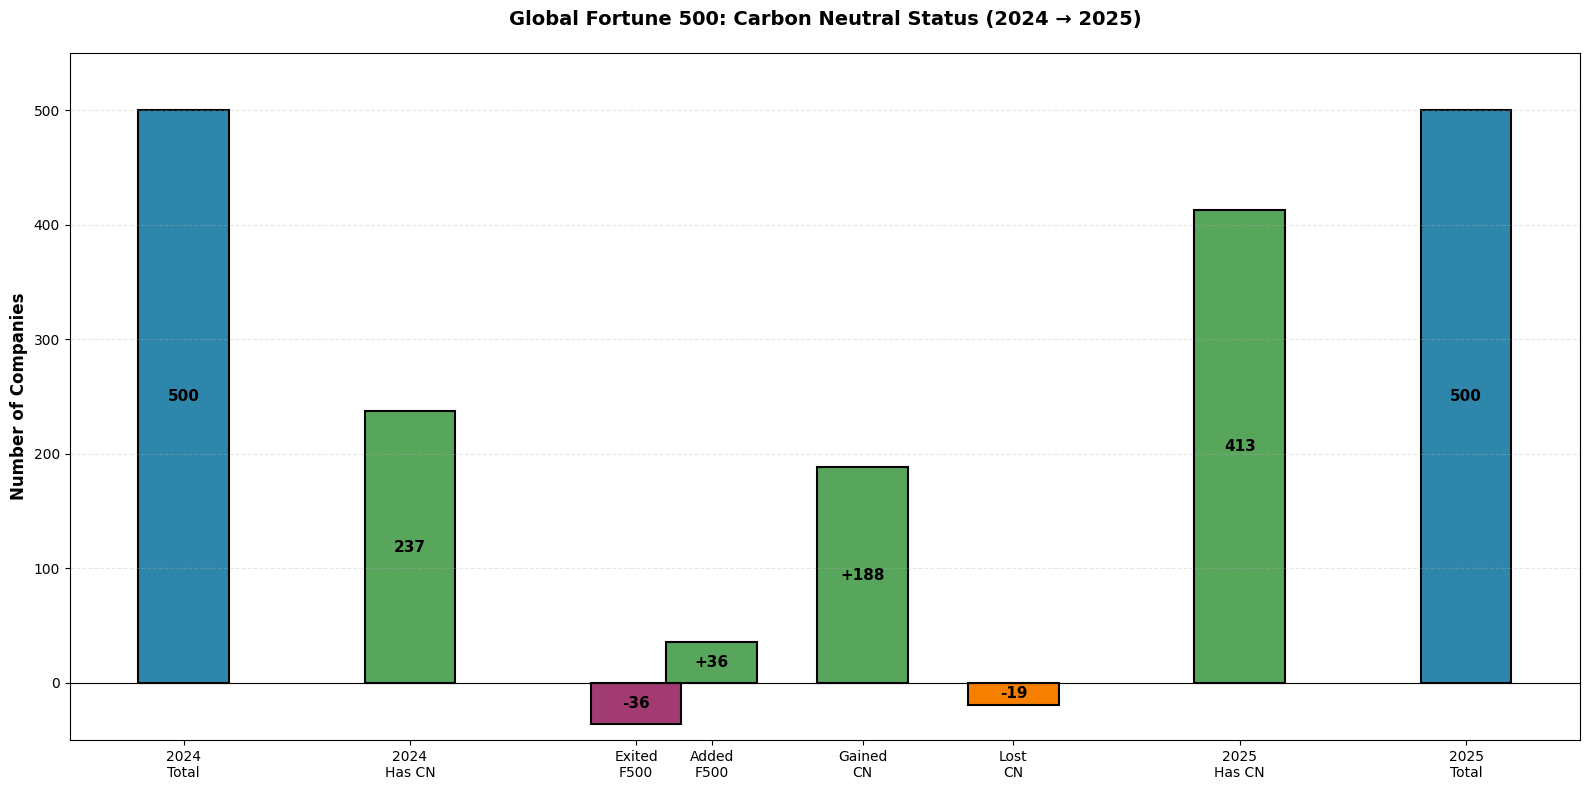

In [36]:
import pandas as pd
import matplotlib.pyplot as plt

df_2024 = pd.read_csv('gf5002024.csv', encoding='latin-1')
df_2025 = pd.read_csv('gf5002026.csv', encoding='latin-1')

companies_2024 = set(df_2024['Company Name'].dropna())
companies_2025 = set(df_2025['Company Name'].dropna())
continuing = companies_2024 & companies_2025

def map_cn_2024(row):
    cn = str(row['Carbon neutral commitment (C = company, V = value chain, G= Government, S = subsidiary, U = unspecified, x = less than 50% of rev, N=no)']).strip()
    return 'Has CN' if cn not in ['N', 'nan'] else 'No CN'

def map_cn_2025(row):
    cn = str(row['Carbon neutral commitment (C = company, V = value chain, G= Government, S=Subsidiary,  U = unspecified, N=no)']).strip()
    return 'Has CN' if cn not in ['N', 'nan'] else 'No CN'

df_2024_indexed = df_2024.set_index('Company Name')
df_2025_indexed = df_2025.set_index('Company Name')

cn_2024 = sum(1 for c in companies_2024 if map_cn_2024(df_2024_indexed.loc[c]) == 'Has CN')
cn_2025 = sum(1 for c in companies_2025 if map_cn_2025(df_2025_indexed.loc[c]) == 'Has CN')

gained = sum(1 for c in continuing if map_cn_2024(df_2024_indexed.loc[c]) == 'No CN' and map_cn_2025(df_2025_indexed.loc[c]) == 'Has CN')
lost = sum(1 for c in continuing if map_cn_2024(df_2024_indexed.loc[c]) == 'Has CN' and map_cn_2025(df_2025_indexed.loc[c]) == 'No CN')

categories = ['2024\nTotal', '2024\nHas CN', 'Exited\nF500', 'Added\nF500', 'Gained\nCN', 'Lost\nCN', '2025\nHas CN', '2025\nTotal']
base_values = [500, cn_2024, -len(companies_2024 - companies_2025), len(companies_2025 - companies_2024), gained, -lost, cn_2025, 500]

fig, ax = plt.subplots(figsize=(16, 8))
x_positions = [0, 1.5, 3, 3.5, 4.5, 5.5, 7, 8.5]

for i, (x, val) in enumerate(zip(x_positions, base_values)):
    if i == 0 or i == 7:
        ax.bar(x, val, color='#2E86AB', width=0.6, edgecolor='black', linewidth=1.5)
        ax.text(x, val/2, f'{val}', ha='center', va='center', fontsize=11, fontweight='bold')
    elif i == 1 or i == 6:
        ax.bar(x, val, color='#58A55C', width=0.6, edgecolor='black', linewidth=1.5)
        ax.text(x, val/2, f'{val}', ha='center', va='center', fontsize=11, fontweight='bold')
    else:
        col = '#A23B72' if i == 2 else '#58A55C' if val > 0 else '#F77F00'
        ax.bar(x, abs(val), bottom=0 if val > 0 else val, color=col, width=0.6, edgecolor='black', linewidth=1.5)
        ax.text(x, val/2, f'{val:+d}', ha='center', va='center', fontsize=11, fontweight='bold')

ax.set_xticks(x_positions)
ax.set_xticklabels(categories, fontsize=10)
ax.set_ylabel('Number of Companies', fontsize=12, fontweight='bold')
ax.set_title('Global Fortune 500: Carbon Neutral Status (2024 → 2025)', fontsize=14, fontweight='bold', pad=20)
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.axhline(y=0, color='black', linewidth=0.8)
ax.set_ylim(-50, 550)
plt.tight_layout()
plt.savefig('waterfall_carbon_neutral.png', dpi=300, bbox_inches='tight')
plt.show()

changes = []
for company in continuing:
    old = map_cn_2024(df_2024_indexed.loc[company])
    new = map_cn_2025(df_2025_indexed.loc[company])
    if old != new:
        changes.append({'Company': company, '2024': old, '2025': new})

pd.DataFrame(changes).to_excel('carbon_neutral_changes.xlsx', index=False)

## Net Zero

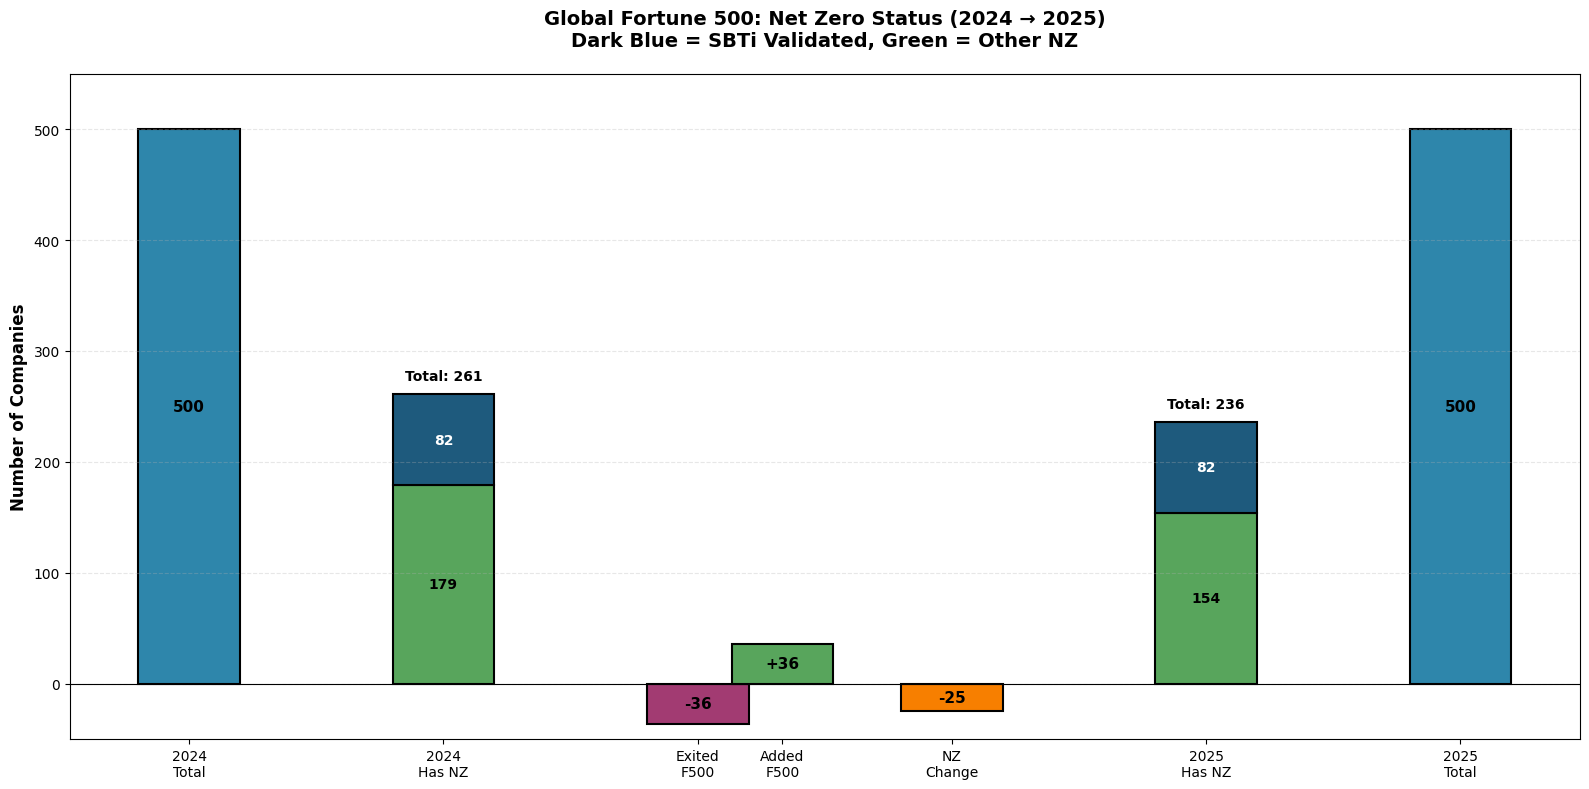

In [33]:
import pandas as pd
import matplotlib.pyplot as plt

df_2024 = pd.read_csv('gf5002024.csv', encoding='latin-1')
df_2025 = pd.read_csv('gf5002026.csv', encoding='latin-1')

companies_2024 = set(df_2024['Company Name'].dropna())
companies_2025 = set(df_2025['Company Name'].dropna())
continuing = companies_2024 & companies_2025

def map_nz_2024(row):
    nz = str(row['Net zero commitment (V = value chain, C = company, S = subsidiary, U = unclear, x = less than 50% rev)']).strip()
    sbti = str(row['Net zero committed (SBTi)']).strip()
    if sbti in ['Yes', 'Y']:
        return 'NZ (SBTi)'
    elif nz not in ['N', 'nan', '']:
        return 'NZ (Other)'
    return 'No NZ'

def map_nz_2025(row):
    nz = str(row['Net zero commitment (V = value chain, C = company,  U = unclear, S=Subsidiary)']).strip()
    sbti = str(row['Net zero committed (SBTi) (Y = yes, N = no)']).strip()
    sbti_status = str(row['SBTi NZ Target Status']).strip()
    if sbti in ['Yes', 'Y'] or sbti_status in ['Targets set', 'Targets Set']:
        return 'NZ (SBTi)'
    elif nz not in ['N', 'nan', '']:
        return 'NZ (Other)'
    return 'No NZ'

df_2024_indexed = df_2024.set_index('Company Name')
df_2025_indexed = df_2025.set_index('Company Name')

nz_sbti_2024 = sum(1 for c in companies_2024 if map_nz_2024(df_2024_indexed.loc[c]) == 'NZ (SBTi)')
nz_other_2024 = sum(1 for c in companies_2024 if map_nz_2024(df_2024_indexed.loc[c]) == 'NZ (Other)')
nz_sbti_2025 = sum(1 for c in companies_2025 if map_nz_2025(df_2025_indexed.loc[c]) == 'NZ (SBTi)')
nz_other_2025 = sum(1 for c in companies_2025 if map_nz_2025(df_2025_indexed.loc[c]) == 'NZ (Other)')

nz_total_2024 = nz_sbti_2024 + nz_other_2024
nz_total_2025 = nz_sbti_2025 + nz_other_2025

categories = ['2024\nTotal', '2024\nHas NZ', 'Exited\nF500', 'Added\nF500', 'NZ\nChange', '2025\nHas NZ', '2025\nTotal']
base_values = [500, nz_total_2024, -len(companies_2024 - companies_2025), 
               len(companies_2025 - companies_2024), nz_total_2025 - nz_total_2024, 
               nz_total_2025, 500]

fig, ax = plt.subplots(figsize=(16, 8))
x_positions = [0, 1.5, 3, 3.5, 4.5, 6, 7.5]

for i, (x, val) in enumerate(zip(x_positions, base_values)):
    if i == 0 or i == 6:
        ax.bar(x, val, color='#2E86AB', width=0.6, edgecolor='black', linewidth=1.5)
        ax.text(x, val/2, f'{val}', ha='center', va='center', fontsize=11, fontweight='bold')
    elif i == 1:
        ax.bar(x, nz_other_2024, color='#58A55C', width=0.6, edgecolor='black', linewidth=1.5)
        ax.bar(x, nz_sbti_2024, bottom=nz_other_2024, color='#1E5A7D', width=0.6, edgecolor='black', linewidth=1.5)
        ax.text(x, nz_other_2024/2, f'{nz_other_2024}', ha='center', va='center', fontsize=10, fontweight='bold')
        ax.text(x, nz_other_2024 + nz_sbti_2024/2, f'{nz_sbti_2024}', ha='center', va='center', fontsize=10, fontweight='bold', color='white')
        ax.text(x, val + 10, f'Total: {val}', ha='center', va='bottom', fontsize=10, fontweight='bold')
    elif i == 5:
        ax.bar(x, nz_other_2025, color='#58A55C', width=0.6, edgecolor='black', linewidth=1.5)
        ax.bar(x, nz_sbti_2025, bottom=nz_other_2025, color='#1E5A7D', width=0.6, edgecolor='black', linewidth=1.5)
        ax.text(x, nz_other_2025/2, f'{nz_other_2025}', ha='center', va='center', fontsize=10, fontweight='bold')
        ax.text(x, nz_other_2025 + nz_sbti_2025/2, f'{nz_sbti_2025}', ha='center', va='center', fontsize=10, fontweight='bold', color='white')
        ax.text(x, val + 10, f'Total: {val}', ha='center', va='bottom', fontsize=10, fontweight='bold')
    else:
        col = '#A23B72' if i == 2 else '#58A55C' if val > 0 else '#F77F00'
        ax.bar(x, abs(val), bottom=0 if val > 0 else val, color=col, width=0.6, edgecolor='black', linewidth=1.5)
        ax.text(x, val/2, f'{val:+d}', ha='center', va='center', fontsize=11, fontweight='bold')

ax.set_xticks(x_positions)
ax.set_xticklabels(categories, fontsize=10)
ax.set_ylabel('Number of Companies', fontsize=12, fontweight='bold')
ax.set_title('Global Fortune 500: Net Zero Status (2024 → 2025)\nDark Blue = SBTi Validated, Green = Other NZ', 
             fontsize=14, fontweight='bold', pad=20)
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.axhline(y=0, color='black', linewidth=0.8)
ax.set_ylim(-50, 550)
plt.tight_layout()
plt.savefig('waterfall_net_zero.png', dpi=300, bbox_inches='tight')
plt.show()

changes = []
for company in continuing:
    old = map_nz_2024(df_2024_indexed.loc[company])
    new = map_nz_2025(df_2025_indexed.loc[company])
    if old != new:
        changes.append({'Company': company, '2024': old, '2025': new})

pd.DataFrame(changes).to_excel('net_zero_changes.xlsx', index=False)

In [64]:
import pandas as pd
import plotly.graph_objects as go

df_2024 = pd.read_csv('gf5002024.csv', encoding='latin-1')
df_2025 = pd.read_csv('gf5002026.csv', encoding='latin-1')

def map_nz_2024(row):
    sbti = str(row['Net zero committed (SBTi)']).strip()
    nz = str(row['Net zero commitment (V = value chain, C = company, S = subsidiary, U = unclear, x = less than 50% rev)']).strip()
    if sbti in ['Yes', 'Y']:
        return 'NZ (SBTi)'
    elif nz not in ['N', 'nan', '']:
        return 'NZ (Other)'
    return 'No NZ'

def map_nz_2025(row):
    sbti = str(row['Net zero committed (SBTi) (Y = yes, N = no)']).strip()
    sbti_status = str(row['SBTi NZ Target Status']).strip()
    nz = str(row['Net zero commitment (V = value chain, C = company,  U = unclear, S=Subsidiary)']).strip()
    if sbti in ['Yes', 'Y'] or sbti_status in ['Targets set', 'Targets Set']:
        return 'NZ (SBTi)'
    elif nz not in ['N', 'nan', '']:
        return 'NZ (Other)'
    return 'No NZ'

companies_2024 = set(df_2024['Company Name'].dropna())
companies_2025 = set(df_2025['Company Name'].dropna())
continuing = companies_2024 & companies_2025

df_2024_indexed = df_2024.set_index('Company Name')
df_2025_indexed = df_2025.set_index('Company Name')

transitions = {}
for company in continuing:
    old = map_nz_2024(df_2024_indexed.loc[company])
    new = map_nz_2025(df_2025_indexed.loc[company])
    transitions[(old, new)] = transitions.get((old, new), 0) + 1

labels = ['2024: NZ (SBTi)', '2024: NZ (Other)', '2024: No NZ', 
          '2025: NZ (SBTi)', '2025: NZ (Other)', '2025: No NZ']
label_map = {'NZ (SBTi)': 0, 'NZ (Other)': 1, 'No NZ': 2}

source, target, value, link_colors = [], [], [], []

for (old, new), count in transitions.items():
    src = label_map[old]
    tgt = label_map[new] + 3
    source.append(src)
    target.append(tgt)
    value.append(count)
    
    # Color by source category
    if src == 0:  # NZ (SBTi)
        link_colors.append('rgba(237, 163, 219, 0.5)')
    elif src == 1:  # NZ (Other)
        link_colors.append('rgba(220, 242, 170, 0.5)')
    else:  # No NZ
        link_colors.append('rgba(161, 102, 117, 0.5)')

fig = go.Figure(data=[go.Sankey(
    node=dict(pad=15, thickness=20, label=labels, 
              color=["#EDA3DB", "#DCF2AA", "#A16675", "#9AA7CA", "#5B8449", "#A9DBF6"]),
    link=dict(source=source, target=target, value=value, color=link_colors)
)])

fig.update_layout(title_text="Net Zero Transitions (2024 → 2025)", font_size=12, height=600)
fig.write_html('sankey_net_zero.html')

## Carbon Neutral sankey with nt zero overlaps 

In [23]:
import pandas as pd
import plotly.graph_objects as go

df_2024 = pd.read_csv('2024.csv', encoding='latin-1')
df_2025 = pd.read_csv('2025.csv', encoding='latin-1')

def categorize_2024(row):
    cn = pd.notna(row['Any CN']) and row['Any CN'] != ''
    nz = row['Any NZ'] == 1.0
    if cn and nz: return 'CN+NZ'
    elif cn: return 'CN only'
    elif nz: return 'NZ only'
    else: return 'Neither'

def categorize_2025(row):
    cn = row['All CN'] == 1.0
    nz = row['All NZ'] == 1.0
    if cn and nz: return 'CN+NZ'
    elif cn: return 'CN only'
    elif nz: return 'NZ only'
    else: return 'Neither'

companies_2024 = set(df_2024['Company Name'].dropna())
companies_2025 = set(df_2025['Company name'].dropna())
continuing = companies_2024 & companies_2025

df_2024_indexed = df_2024.set_index('Company Name')
df_2025_indexed = df_2025.set_index('Company name')

labels = ['2024: NZ only', '2024: CN only', '2024: CN+NZ', '2024: Neither',
          '2025: NZ only', '2025: CN only', '2025: CN+NZ', '2025: Neither']

cat_to_idx_2024 = {'NZ only': 0, 'CN only': 1, 'CN+NZ': 2, 'Neither': 3}
cat_to_idx_2025 = {'NZ only': 4, 'CN only': 5, 'CN+NZ': 6, 'Neither': 7}

flows = {}
for company in continuing:
    cat_24 = categorize_2024(df_2024_indexed.loc[company])
    cat_25 = categorize_2025(df_2025_indexed.loc[company])
    key = (cat_to_idx_2024[cat_24], cat_to_idx_2025[cat_25])
    flows.setdefault(key, []).append(company)

source = [k[0] for k in flows.keys()]
target = [k[1] for k in flows.keys()]
value = [len(v) for v in flows.values()]
customdata = ['<br>'.join(sorted(v)) for v in flows.values()]

fig = go.Figure(data=[go.Sankey(
    node=dict(pad=15, thickness=20, label=labels),
    link=dict(source=source, target=target, value=value,
              customdata=customdata,
              hovertemplate='%{value} companies<br>%{customdata}<extra></extra>')
)])

fig.update_layout(title_text="CN/NZ Transitions: 2024 → 2025", height=600)
fig.write_html('cn_nz_sankey.html')

In [25]:
import pandas as pd
import plotly.graph_objects as go

df_2024 = pd.read_csv('2024.csv', encoding='latin-1')
df_2025 = pd.read_csv('2025.csv', encoding='latin-1')

def categorize_2024(row):
    cn = pd.notna(row['Any CN']) and row['Any CN'] != ''
    nz = row['Any NZ'] == 1.0
    if cn and nz: return 'CN+NZ'
    elif cn: return 'CN only'
    elif nz: return 'NZ only'
    else: return 'Neither'

def categorize_2025(row):
    cn = row['All CN'] == 1.0
    nz = row['All NZ'] == 1.0
    if cn and nz: return 'CN+NZ'
    elif cn: return 'CN only'
    elif nz: return 'NZ only'
    else: return 'Neither'

companies_2024 = set(df_2024['Company Name'].dropna())
companies_2025 = set(df_2025['Company name'].dropna())
continuing = companies_2024 & companies_2025

df_2024_indexed = df_2024.set_index('Company Name')
df_2025_indexed = df_2025.set_index('Company name')

# Calculate actual counts to verify
counts_2024 = {'NZ only': 0, 'CN only': 0, 'CN+NZ': 0, 'Neither': 0}
counts_2025 = {'NZ only': 0, 'CN only': 0, 'CN+NZ': 0, 'Neither': 0}

for c in continuing:
    counts_2024[categorize_2024(df_2024_indexed.loc[c])] += 1
    counts_2025[categorize_2025(df_2025_indexed.loc[c])] += 1

print("2024 counts:")
print(f"  NZ only: {counts_2024['NZ only']}")
print(f"  CN only: {counts_2024['CN only']}")
print(f"  CN+NZ: {counts_2024['CN+NZ']}")
print(f"  Neither: {counts_2024['Neither']}")
print(f"  Total NZ: {counts_2024['NZ only'] + counts_2024['CN+NZ']}")
print(f"  Total CN: {counts_2024['CN only'] + counts_2024['CN+NZ']}")

print("\n2025 counts:")
print(f"  NZ only: {counts_2025['NZ only']}")
print(f"  CN only: {counts_2025['CN only']}")
print(f"  CN+NZ: {counts_2025['CN+NZ']}")
print(f"  Neither: {counts_2025['Neither']}")
print(f"  Total NZ: {counts_2025['NZ only'] + counts_2025['CN+NZ']}")
print(f"  Total CN: {counts_2025['CN only'] + counts_2025['CN+NZ']}")

labels = ['2024: NZ only', '2024: CN only', '2024: CN+NZ', '2024: Neither',
          '2025: NZ only', '2025: CN only', '2025: CN+NZ', '2025: Neither']

cat_to_idx_2024 = {'NZ only': 0, 'CN only': 1, 'CN+NZ': 2, 'Neither': 3}
cat_to_idx_2025 = {'NZ only': 4, 'CN only': 5, 'CN+NZ': 6, 'Neither': 7}

flows = {}
for company in continuing:
    cat_24 = categorize_2024(df_2024_indexed.loc[company])
    cat_25 = categorize_2025(df_2025_indexed.loc[company])
    key = (cat_to_idx_2024[cat_24], cat_to_idx_2025[cat_25])
    flows.setdefault(key, []).append(company)

source = [k[0] for k in flows.keys()]
target = [k[1] for k in flows.keys()]
value = [len(v) for v in flows.values()]
customdata = ['<br>'.join(sorted(v)) for v in flows.values()]

fig = go.Figure(data=[go.Sankey(
    node=dict(pad=15, thickness=20, label=labels),
    link=dict(source=source, target=target, value=value,
              customdata=customdata,
              hovertemplate='%{value} companies<br>%{customdata}<extra></extra>')
)])

fig.update_layout(title_text="CN/NZ Transitions: 2024 → 2025", height=600)
fig.write_html('cn_nz_sankey.html')

2024 counts:
  NZ only: 145
  CN only: 86
  CN+NZ: 69
  Neither: 164
  Total NZ: 214
  Total CN: 155

2025 counts:
  NZ only: 221
  CN only: 85
  CN+NZ: 8
  Neither: 150
  Total NZ: 229
  Total CN: 93


In [27]:
import pandas as pd
import plotly.graph_objects as go

df_2024 = pd.read_csv('2024.csv', encoding='latin-1')
df_2025 = pd.read_csv('2025.csv', encoding='latin-1')

def categorize_2024(row):
    cn = pd.notna(row['Any CN']) and row['Any CN'] != ''
    nz = row['Any NZ'] == 1.0
    if cn and nz: return 'CN+NZ'
    elif cn: return 'CN only'
    elif nz: return 'NZ only'
    else: return 'Neither'

def categorize_2025(row):
    cn = row['All CN'] == 1.0
    nz = row['All NZ'] == 1.0
    if cn and nz: return 'CN+NZ'
    elif cn: return 'CN only'
    elif nz: return 'NZ only'
    else: return 'Neither'

# Count ALL companies in each year
counts_2024 = {'NZ only': 0, 'CN only': 0, 'CN+NZ': 0, 'Neither': 0}
for _, row in df_2024.iterrows():
    counts_2024[categorize_2024(row)] += 1

counts_2025 = {'NZ only': 0, 'CN only': 0, 'CN+NZ': 0, 'Neither': 0}
for _, row in df_2025.iterrows():
    counts_2025[categorize_2025(row)] += 1

print("2024 ALL companies:")
print(f"  Total NZ: {counts_2024['NZ only'] + counts_2024['CN+NZ']}")
print(f"  Total CN: {counts_2024['CN only'] + counts_2024['CN+NZ']}")
print(f"  CN+NZ: {counts_2024['CN+NZ']}")

print("\n2025 ALL companies:")
print(f"  Total NZ: {counts_2025['NZ only'] + counts_2025['CN+NZ']}")
print(f"  Total CN: {counts_2025['CN only'] + counts_2025['CN+NZ']}")
print(f"  CN+NZ: {counts_2025['CN+NZ']}")

2024 ALL companies:
  Total NZ: 225
  Total CN: 176
  CN+NZ: 72

2025 ALL companies:
  Total NZ: 250
  Total CN: 98
  CN+NZ: 10


In [28]:
import pandas as pd
import plotly.graph_objects as go

df_2024 = pd.read_csv('2024.csv', encoding='latin-1')
df_2025 = pd.read_csv('2025.csv', encoding='latin-1')

def categorize_2024(row):
    cn = pd.notna(row['Any CN']) and row['Any CN'] != ''
    nz = row['Any NZ'] == 1.0
    if cn and nz: return 'CN+NZ'
    elif cn: return 'CN only'
    elif nz: return 'NZ only'
    else: return 'Neither'

def categorize_2025(row):
    cn = row['All CN'] == 1.0
    nz = row['All NZ'] == 1.0
    if cn and nz: return 'CN+NZ'
    elif cn: return 'CN only'
    elif nz: return 'NZ only'
    else: return 'Neither'

companies_2024 = set(df_2024['Company Name'].dropna())
companies_2025 = set(df_2025['Company name'].dropna())
continuing = companies_2024 & companies_2025

df_2024_indexed = df_2024.set_index('Company Name')
df_2025_indexed = df_2025.set_index('Company name')

labels = ['2024: NZ only', '2024: CN only', '2024: CN+NZ', '2024: Neither',
          '2025: NZ only', '2025: CN only', '2025: CN+NZ', '2025: Neither']

cat_to_idx_2024 = {'NZ only': 0, 'CN only': 1, 'CN+NZ': 2, 'Neither': 3}
cat_to_idx_2025 = {'NZ only': 4, 'CN only': 5, 'CN+NZ': 6, 'Neither': 7}

flows = {}
for company in continuing:
    cat_24 = categorize_2024(df_2024_indexed.loc[company])
    cat_25 = categorize_2025(df_2025_indexed.loc[company])
    key = (cat_to_idx_2024[cat_24], cat_to_idx_2025[cat_25])
    flows.setdefault(key, []).append(company)

source = [k[0] for k in flows.keys()]
target = [k[1] for k in flows.keys()]
value = [len(v) for v in flows.values()]
customdata = ['<br>'.join(sorted(v)) for v in flows.values()]

fig = go.Figure(data=[go.Sankey(
    node=dict(pad=15, thickness=20, label=labels),
    link=dict(source=source, target=target, value=value, customdata=customdata,
              hovertemplate='%{value} companies<br>%{customdata}<extra></extra>')
)])

fig.update_layout(title_text="CN/NZ Transitions: 2024 → 2025 (Continuing Companies Only)", height=600)
fig.write_html('cn_nz_sankey.html')

In [34]:
import pandas as pd
import plotly.graph_objects as go

df_2024 = pd.read_csv('2024.csv', encoding='latin-1')
df_2025 = pd.read_csv('2025.csv', encoding='latin-1')

def categorize_2024(row):
    cn = pd.notna(row['Any CN']) and row['Any CN'] != ''
    nz = row['Any NZ'] == 1.0
    if cn and nz: return 'CN+NZ'
    elif cn: return 'CN only'
    elif nz: return 'NZ only'
    else: return 'Neither'

def categorize_2025(row):
    cn = row['All CN'] == 1.0
    nz = row['All NZ'] == 1.0
    if cn and nz: return 'CN+NZ'
    elif cn: return 'CN only'
    elif nz: return 'NZ only'
    else: return 'Neither'

counts_2024 = {'NZ only': 0, 'CN only': 0, 'CN+NZ': 0, 'Neither': 0}
companies_2024 = {'NZ only': [], 'CN only': [], 'CN+NZ': [], 'Neither': []}
for _, row in df_2024.iterrows():
    cat = categorize_2024(row)
    counts_2024[cat] += 1
    companies_2024[cat].append(row['Company Name'])

counts_2025 = {'NZ only': 0, 'CN only': 0, 'CN+NZ': 0, 'Neither': 0}
companies_2025 = {'NZ only': [], 'CN only': [], 'CN+NZ': [], 'Neither': []}
for _, row in df_2025.iterrows():
    cat = categorize_2025(row)
    counts_2025[cat] += 1
    companies_2025[cat].append(row['Company name'])

with pd.ExcelWriter('cn_nz_categories.xlsx', engine='openpyxl') as writer:
    for cat in ['NZ only', 'CN only', 'CN+NZ', 'Neither']:
        pd.DataFrame({'2024': companies_2024[cat]}).to_excel(writer, sheet_name=f'2024_{cat}', index=False)
        pd.DataFrame({'2025': companies_2025[cat]}).to_excel(writer, sheet_name=f'2025_{cat}', index=False)

fig = go.Figure(data=[
    go.Bar(name='Neither', x=['2024', '2025'], y=[counts_2024['Neither'], counts_2025['Neither']]),
    go.Bar(name='NZ only', x=['2024', '2025'], y=[counts_2024['NZ only'], counts_2025['NZ only']]),
    go.Bar(name='CN+NZ', x=['2024', '2025'], y=[counts_2024['CN+NZ'], counts_2025['CN+NZ']]),
    go.Bar(name='CN only', x=['2024', '2025'], y=[counts_2024['CN only'], counts_2025['CN only']])
])

fig.update_layout(barmode='stack', title='CN/NZ Distribution')
fig.write_html('cn_nz_stacked.html')

In [35]:
import pandas as pd
import plotly.graph_objects as go

df_2024 = pd.read_csv('2024.csv', encoding='latin-1')
df_2025 = pd.read_csv('2025.csv', encoding='latin-1')

def categorize_2024(row):
    cn = pd.notna(row['Any CN']) and row['Any CN'] != ''
    nz = row['Any NZ'] == 1.0
    if cn and nz: return 'CN+NZ'
    elif cn: return 'CN only'
    elif nz: return 'NZ only'
    else: return 'Neither'

def categorize_2025(row):
    cn = row['All CN'] == 1.0
    nz = row['All NZ'] == 1.0
    if cn and nz: return 'CN+NZ'
    elif cn: return 'CN only'
    elif nz: return 'NZ only'
    else: return 'Neither'

counts_2024 = {'NZ only': 0, 'CN only': 0, 'CN+NZ': 0, 'Neither': 0}
companies_2024 = {'NZ only': [], 'CN only': [], 'CN+NZ': [], 'Neither': []}
for _, row in df_2024.iterrows():
    cat = categorize_2024(row)
    counts_2024[cat] += 1
    companies_2024[cat].append(row['Company Name'])

counts_2025 = {'NZ only': 0, 'CN only': 0, 'CN+NZ': 0, 'Neither': 0}
companies_2025 = {'NZ only': [], 'CN only': [], 'CN+NZ': [], 'Neither': []}
for _, row in df_2025.iterrows():
    cat = categorize_2025(row)
    counts_2025[cat] += 1
    companies_2025[cat].append(row['Company name'])

with pd.ExcelWriter('cn_nz_categories.xlsx', engine='openpyxl') as writer:
    for cat in ['NZ only', 'CN only', 'CN+NZ', 'Neither']:
        pd.DataFrame({'2024': companies_2024[cat]}).to_excel(writer, sheet_name=f'2024_{cat}', index=False)
        pd.DataFrame({'2025': companies_2025[cat]}).to_excel(writer, sheet_name=f'2025_{cat}', index=False)

fig = go.Figure(data=[
    go.Bar(name='Neither', x=['2024', '2025'], y=[counts_2024['Neither'], counts_2025['Neither']]),
    go.Bar(name='NZ only', x=['2024', '2025'], y=[counts_2024['NZ only'], counts_2025['NZ only']]),
    go.Bar(name='CN+NZ', x=['2024', '2025'], y=[counts_2024['CN+NZ'], counts_2025['CN+NZ']]),
    go.Bar(name='CN only', x=['2024', '2025'], y=[counts_2024['CN only'], counts_2025['CN only']])
])

fig.update_layout(barmode='stack', title='CN/NZ Distribution')
fig.write_html('cn_nz_stacked.html')

In [38]:
import pandas as pd
import plotly.graph_objects as go

df_2024 = pd.read_csv('2024.csv', encoding='latin-1')
df_2025 = pd.read_csv('2025.csv', encoding='latin-1')

def categorize_2024(row):
    cn = pd.notna(row['Any CN']) and row['Any CN'] != ''
    nz = row['Any NZ'] == 1.0
    if cn and nz: return 'CN+NZ'
    elif cn: return 'CN only'
    elif nz: return 'NZ only'
    else: return 'Neither'

def categorize_2025(row):
    cn = row['All CN'] == 1.0
    nz = row['All NZ'] == 1.0
    if cn and nz: return 'CN+NZ'
    elif cn: return 'CN only'
    elif nz: return 'NZ only'
    else: return 'Neither'

counts_2024 = {'NZ only': 0, 'CN only': 0, 'CN+NZ': 0, 'Neither': 0}
companies_2024 = {'NZ only': [], 'CN only': [], 'CN+NZ': [], 'Neither': []}
for _, row in df_2024.iterrows():
    cat = categorize_2024(row)
    counts_2024[cat] += 1
    companies_2024[cat].append(row['Company Name'])

counts_2025 = {'NZ only': 0, 'CN only': 0, 'CN+NZ': 0, 'Neither': 0}
companies_2025 = {'NZ only': [], 'CN only': [], 'CN+NZ': [], 'Neither': []}
for _, row in df_2025.iterrows():
    cat = categorize_2025(row)
    counts_2025[cat] += 1
    companies_2025[cat].append(row['Company name'])

with pd.ExcelWriter('cn_nz_categories.xlsx', engine='openpyxl') as writer:
    for cat in ['NZ only', 'CN only', 'CN+NZ', 'Neither']:
        pd.DataFrame({'2024': companies_2024[cat]}).to_excel(writer, sheet_name=f'2024_{cat}', index=False)
        pd.DataFrame({'2025': companies_2025[cat]}).to_excel(writer, sheet_name=f'2025_{cat}', index=False)

fig = go.Figure(data=[
    go.Bar(name='Neither', x=['2024', '2025'], y=[counts_2024['Neither'], counts_2025['Neither']], marker_color='#CCCCCC'),
    go.Bar(name='NZ only', x=['2024', '2025'], y=[counts_2024['NZ only'], counts_2025['NZ only']], marker_color='#00B4B2'),
    go.Bar(name='CN+NZ', x=['2024', '2025'], y=[counts_2024['CN+NZ'], counts_2025['CN+NZ']], marker_color='#E82C81'),
    go.Bar(name='CN only', x=['2024', '2025'], y=[counts_2024['CN only'], counts_2025['CN only']], marker_color='#8B479B')
])

fig.update_layout(barmode='stack', title='CN/NZ Distribution')
fig.write_html('cn_nz_stacked.html')

In [39]:
import pandas as pd
import plotly.graph_objects as go

df_2024 = pd.read_csv('2024.csv', encoding='latin-1')
df_2025 = pd.read_csv('2025.csv', encoding='latin-1')

print(f"2024 rows: {len(df_2024)}")
print(f"2025 rows: {len(df_2025)}")
print(f"2024 unique companies: {df_2024['Company Name'].nunique()}")
print(f"2025 unique companies: {df_2025['Company name'].nunique()}")

def categorize_2024(row):
    cn = pd.notna(row['Any CN']) and row['Any CN'] != ''
    nz = row['Any NZ'] == 1.0
    if cn and nz: return 'CN+NZ'
    elif cn: return 'CN only'
    elif nz: return 'NZ only'
    else: return 'Neither'

def categorize_2025(row):
    cn = row['All CN'] == 1.0
    nz = row['All NZ'] == 1.0
    if cn and nz: return 'CN+NZ'
    elif cn: return 'CN only'
    elif nz: return 'NZ only'
    else: return 'Neither'

# Only count first 500 rows or unique companies
counts_2024 = {'NZ only': 0, 'CN only': 0, 'CN+NZ': 0, 'Neither': 0}
counts_2025 = {'NZ only': 0, 'CN only': 0, 'CN+NZ': 0, 'Neither': 0}

for idx, row in df_2024.head(500).iterrows():
    counts_2024[categorize_2024(row)] += 1

for idx, row in df_2025.head(500).iterrows():
    counts_2025[categorize_2025(row)] += 1

print(f"\n2024 counts: {counts_2024}, sum: {sum(counts_2024.values())}")
print(f"2025 counts: {counts_2025}, sum: {sum(counts_2025.values())}")

categories = ['Neither', 'NZ only', 'CN+NZ', 'CN only']
colors = {'NZ only': '#00B4B2', 'CN only': '#8B479B', 'CN+NZ': '#E82C81', 'Neither': '#CCCCCC'}

fig = go.Figure()
fig.add_trace(go.Bar(name='2024', x=['2024'], y=[counts_2024[cat] for cat in categories],
                     marker_color=[colors[cat] for cat in categories]))
fig.add_trace(go.Bar(name='2025', x=['2025'], y=[counts_2025[cat] for cat in categories],
                     marker_color=[colors[cat] for cat in categories]))

fig.update_layout(title='CN/NZ Distribution', barmode='stack', height=600)
fig.write_html('cn_nz_stacked_bar.html')

2024 rows: 507
2025 rows: 507
2024 unique companies: 500
2025 unique companies: 500

2024 counts: {'NZ only': 153, 'CN only': 97, 'CN+NZ': 72, 'Neither': 178}, sum: 500
2025 counts: {'NZ only': 240, 'CN only': 88, 'CN+NZ': 10, 'Neither': 162}, sum: 500


In [41]:
import pandas as pd
import plotly.graph_objects as go

df_2024 = pd.read_csv('2024.csv', encoding='latin-1')
df_2025 = pd.read_csv('2025.csv', encoding='latin-1')

def categorize_2024(row):
    cn = pd.notna(row['Any CN']) and row['Any CN'] != ''
    nz = row['Any NZ'] == 1.0
    if cn and nz: return 'CN+NZ'
    elif cn: return 'CN only'
    elif nz: return 'NZ only'
    else: return 'Neither'

def categorize_2025(row):
    cn = row['All CN'] == 1.0
    nz = row['All NZ'] == 1.0
    if cn and nz: return 'CN+NZ'
    elif cn: return 'CN only'
    elif nz: return 'NZ only'
    else: return 'Neither'

counts_2024 = {'NZ only': 0, 'CN only': 0, 'CN+NZ': 0, 'Neither': 0}
counts_2025 = {'NZ only': 0, 'CN only': 0, 'CN+NZ': 0, 'Neither': 0}

for _, row in df_2024.head(500).iterrows():
    counts_2024[categorize_2024(row)] += 1

for _, row in df_2025.head(500).iterrows():
    counts_2025[categorize_2025(row)] += 1

categories = ['Neither', 'NZ only', 'CN+NZ', 'CN only']
colors = {'NZ only': '#00B4B2', 'CN only': '#8B479B', 'CN+NZ': '#E82C81', 'Neither': '#CCCCCC'}

fig = go.Figure()
fig.add_trace(go.Bar(name='2024', x=['2024'], y=[counts_2024[c] for c in categories], marker_color=[colors[c] for c in categories]))
fig.add_trace(go.Bar(name='2025', x=['2025'], y=[counts_2025[c] for c in categories], marker_color=[colors[c] for c in categories]))
fig.update_layout(barmode='stack', height=600)
fig.write_html('cn_nz_stacked.html')

In [42]:
import pandas as pd
import plotly.graph_objects as go

df_2024 = pd.read_csv('2024.csv', encoding='latin-1')
df_2025 = pd.read_csv('2025.csv', encoding='latin-1')

def categorize_2024(row):
    cn = pd.notna(row['Any CN']) and row['Any CN'] != ''
    nz = row['Any NZ'] == 1.0
    if cn and nz: return 'CN+NZ'
    elif cn: return 'CN only'
    elif nz: return 'NZ only'
    else: return 'Neither'

def categorize_2025(row):
    cn = row['All CN'] == 1.0
    nz = row['All NZ'] == 1.0
    if cn and nz: return 'CN+NZ'
    elif cn: return 'CN only'
    elif nz: return 'NZ only'
    else: return 'Neither'

counts_2024 = {'NZ only': 0, 'CN only': 0, 'CN+NZ': 0, 'Neither': 0}
counts_2025 = {'NZ only': 0, 'CN only': 0, 'CN+NZ': 0, 'Neither': 0}

for idx, row in df_2024.head(500).iterrows():
    counts_2024[categorize_2024(row)] += 1

for idx, row in df_2025.head(500).iterrows():
    counts_2025[categorize_2025(row)] += 1

categories = ['Neither', 'NZ only', 'CN+NZ', 'CN only']
colors = {'NZ only': '#00B4B2', 'CN only': '#8B479B', 'CN+NZ': '#E82C81', 'Neither': '#CCCCCC'}

fig = go.Figure()

for cat in categories:
    fig.add_trace(go.Bar(
        name=cat,
        x=['2024', '2025'],
        y=[counts_2024[cat], counts_2025[cat]],
        marker_color=colors[cat]
    ))

fig.update_layout(
    title='CN/NZ Distribution',
    barmode='stack',
    height=600,
    yaxis=dict(range=[0, 500])
)

fig.write_html('cn_nz_stacked_bar_foxed.html')

## sector 

In [45]:
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px

df_2024 = pd.read_csv('2024.csv', encoding='latin-1')
df_2025 = pd.read_csv('2025.csv', encoding='latin-1')

continuing = set(df_2024['Company Name']) & set(df_2025['Company name'])
df_2024_idx = df_2024.drop_duplicates('Company Name').set_index('Company Name')
df_2025_idx = df_2025.drop_duplicates('Company name').set_index('Company name')

# Sector Analysis
sector_changes = []
for c in continuing:
    sector = df_2024_idx.loc[c, 'Sector (final classification)']
    had_cn = pd.notna(df_2024_idx.loc[c, 'Any CN'])
    had_nz = df_2024_idx.loc[c, 'Any NZ'] == 1.0
    has_cn = df_2025_idx.loc[c, 'All CN'] == 1.0
    has_nz = df_2025_idx.loc[c, 'All NZ'] == 1.0
    
    if had_cn and not has_cn:
        sector_changes.append({'Sector': sector, 'Change': 'Lost CN'})
    if had_nz and not has_nz:
        sector_changes.append({'Sector': sector, 'Change': 'Lost NZ'})
    if not had_cn and has_cn:
        sector_changes.append({'Sector': sector, 'Change': 'Gained CN'})
    if not had_nz and has_nz:
        sector_changes.append({'Sector': sector, 'Change': 'Gained NZ'})

df_changes = pd.DataFrame(sector_changes)
summary = df_changes.groupby(['Sector', 'Change']).size().reset_index(name='Count')
summary_pivot = summary.pivot(index='Sector', columns='Change', values='Count').fillna(0)

fig1 = go.Figure()
for col in summary_pivot.columns:
    fig1.add_trace(go.Bar(name=col, x=summary_pivot.index, y=summary_pivot[col]))
fig1.update_layout(title='Sector Changes in CN/NZ Targets', barmode='group', height=500)
fig1.write_html('sector_analysis.html')

# Regional Analysis
regional = []
for _, row in df_2024.iterrows():
    region = row['Region']
    has_cn = pd.notna(row['Any CN'])
    has_nz = row['Any NZ'] == 1.0
    regional.append({'Region': region, 'Year': '2024', 'CN': int(has_cn), 'NZ': int(has_nz)})

for _, row in df_2025.iterrows():
    region = row['Region']
    has_cn = row['All CN'] == 1.0
    has_nz = row['All NZ'] == 1.0
    regional.append({'Region': region, 'Year': '2025', 'CN': int(has_cn), 'NZ': int(has_nz)})

df_regional = pd.DataFrame(regional)
regional_summary = df_regional.groupby(['Region', 'Year']).sum().reset_index()

fig2 = px.bar(regional_summary, x='Region', y=['CN', 'NZ'], color='Year', 
              barmode='group', title='Regional CN/NZ Distribution')
fig2.write_html('regional_analysis.html')

# Companies Dropping All Targets
dropped = []
for c in continuing:
    had_cn = pd.notna(df_2024_idx.loc[c, 'Any CN'])
    had_nz = df_2024_idx.loc[c, 'Any NZ'] == 1.0
    has_cn = df_2025_idx.loc[c, 'All CN'] == 1.0
    has_nz = df_2025_idx.loc[c, 'All NZ'] == 1.0
    
    if (had_cn or had_nz) and not (has_cn or has_nz):
        dropped.append({
            'Company': c,
            'Sector': df_2024_idx.loc[c, 'Sector (final classification)'],
            'Region': df_2024_idx.loc[c, 'Region']
        })

df_dropped = pd.DataFrame(dropped)
sector_counts = df_dropped['Sector'].value_counts()

fig3 = go.Figure(go.Bar(x=sector_counts.index, y=sector_counts.values))
fig3.update_layout(title='Companies Dropping All Targets by Sector', height=500)
fig3.write_html('dropped_targets.html')

# Entry vs Exit
exited = set(df_2024['Company Name']) - set(df_2025['Company name'])
added = set(df_2025['Company name']) - set(df_2024['Company Name'])

exit_stats = {'CN': 0, 'NZ': 0, 'Both': 0, 'Neither': 0}
for c in exited:
    has_cn = pd.notna(df_2024_idx.loc[c, 'Any CN'])
    has_nz = df_2024_idx.loc[c, 'Any NZ'] == 1.0
    if has_cn and has_nz: exit_stats['Both'] += 1
    elif has_cn: exit_stats['CN'] += 1
    elif has_nz: exit_stats['NZ'] += 1
    else: exit_stats['Neither'] += 1

entry_stats = {'CN': 0, 'NZ': 0, 'Both': 0, 'Neither': 0}
for c in added:
    has_cn = df_2025_idx.loc[c, 'All CN'] == 1.0
    has_nz = df_2025_idx.loc[c, 'All NZ'] == 1.0
    if has_cn and has_nz: entry_stats['Both'] += 1
    elif has_cn: entry_stats['CN'] += 1
    elif has_nz: entry_stats['NZ'] += 1
    else: entry_stats['Neither'] += 1

fig4 = go.Figure()
fig4.add_trace(go.Bar(name='Exited', x=list(exit_stats.keys()), y=list(exit_stats.values())))
fig4.add_trace(go.Bar(name='Entered', x=list(entry_stats.keys()), y=list(entry_stats.values())))
fig4.update_layout(title='Target Status: Companies Exiting vs Entering F500', barmode='group')
fig4.write_html('entry_exit_analysis.html')

In [46]:
# Time horizon analysis
import pandas as pd
import plotly.express as px

df = pd.read_csv('2025.csv', encoding='latin-1')

near_term = (df['CN 2025-2030'] == 1) | (df['NZ 2025-2030'] == 1)
long_term = (df['CN > 2030'] == 1) | (df['NZ > 2030'] == 1)
uses_credits = df['Carbon Credits (Y)'] == 1

horizon_credits = pd.DataFrame({
    'Horizon': ['Near-term (2025-2030)'] * len(df) + ['Long-term (>2030)'] * len(df),
    'Has_Target': list(near_term) + list(long_term),
    'Uses_Credits': list(uses_credits) * 2
})

summary = horizon_credits.groupby(['Horizon', 'Has_Target', 'Uses_Credits']).size().reset_index(name='Count')
summary = summary[summary['Has_Target']]

fig = px.bar(summary, x='Horizon', y='Count', color='Uses_Credits',
             title='Carbon Credits Usage by Target Time Horizon', barmode='group')
fig.write_html('credits_time_horizon.html')

KeyError: 'NZ 2025-2030'

In [50]:
import pandas as pd

df_2024 = pd.read_csv('2024.csv', encoding='latin-1')
df_2025 = pd.read_csv('2025.csv', encoding='latin-1')

def categorize_year(year):
    if pd.isna(year): return None
    year = int(float(year))
    if year <= 2024: return '<=2024'
    elif year <= 2030: return '2025-2030'
    else: return '>2030'

sbti_2024 = df_2024['Target year NT (earlier of the two dates if there were two) - if committed, then year set to 2030'].apply(categorize_year).value_counts()
nz_2024 = df_2024['Earlier net zero target year'].apply(categorize_year).value_counts()
cn_2024 = df_2024['Earlier carbon neutral target year'].apply(categorize_year).value_counts()
re100_2024 = df_2024['Target year'].apply(categorize_year).value_counts()

sbti_2025 = df_2025['Target year (near term) (earlier of the two dates if there were two) '].apply(categorize_year).value_counts()
nz_2025 = df_2025['Net zero target year'].apply(categorize_year).value_counts()
cn_2025 = df_2025['Target year'].apply(categorize_year).value_counts()
re100_2025 = df_2025['Target year'].apply(categorize_year).value_counts()

table_2024 = pd.DataFrame({
    'Target': ['SBTi', 'NZ', 'CN', 'RE100'],
    '<=2024': [sbti_2024.get('<=2024', 0), nz_2024.get('<=2024', 0), cn_2024.get('<=2024', 0), re100_2024.get('<=2024', 0)],
    '2025-2030': [sbti_2024.get('2025-2030', 0), nz_2024.get('2025-2030', 0), cn_2024.get('2025-2030', 0), re100_2024.get('2025-2030', 0)],
    '>2030': [sbti_2024.get('>2030', 0), nz_2024.get('>2030', 0), cn_2024.get('>2030', 0), re100_2024.get('>2030', 0)]
})

table_2025 = pd.DataFrame({
    'Target': ['SBTi', 'NZ', 'CN', 'RE100'],
    '<=2024': [sbti_2025.get('<=2024', 0), nz_2025.get('<=2024', 0), cn_2025.get('<=2024', 0), re100_2025.get('<=2024', 0)],
    '2025-2030': [sbti_2025.get('2025-2030', 0), nz_2025.get('2025-2030', 0), cn_2025.get('2025-2030', 0), re100_2025.get('2025-2030', 0)],
    '>2030': [sbti_2025.get('>2030', 0), nz_2025.get('>2030', 0), cn_2025.get('>2030', 0), re100_2025.get('>2030', 0)]
})

with pd.ExcelWriter('target_years_comparison.xlsx') as writer:
    table_2024.to_excel(writer, sheet_name='2024', index=False)
    table_2025.to_excel(writer, sheet_name='2025', index=False)


print("2024 columns with 'target' or 'year':")
print([c for c in df_2024.columns if 'target' in c.lower() or 'year' in c.lower()])

print("\n2025 columns with 'target' or 'year':")
print([c for c in df_2025.columns if 'target' in c.lower() or 'year' in c.lower()])


2024 columns with 'target' or 'year':
['Target summary', 'Joining year', 'Target year', 'Target status - NT', 'Target classification NT - temp', 'Target year NT (earlier of the two dates if there were two) - if committed, then year set to 2030', 'SBTi NZ approved year', 'Commitment year (SBTi)', 'Carbon neutral scope(s) (in their words) (+ indicates two targets/ a later target)', 'Earlier carbon neutral target year', 'Earlier carbon neutral announcement year', 'Later carbon neutral target year', 'Later carbon neutral announcement year', 'Net Zero Target - EARLY', 'Earlier net zero target year', 'Earlier net zero announcement year', 'Net Zero Target - LATE', 'Later net zero target year', 'Later net zero announcement year', 'Reduction targets for Decarbonization (V = value chain, C = company)', 'CN/NZ - does the company have a voluntary CN or NZ target?']

2025 columns with 'target' or 'year':
['Years on list (2025)', 'Joining year', 'Target year', 'Target status (T = target set, C = com

In [51]:
print("2024 sample values:")
print("\nSBTi target year:")
print(df_2024['Target year NT (earlier of the two dates if there were two) - if committed, then year set to 2030'].value_counts().head())
print("\nNZ target year:")
print(df_2024['Earlier net zero target year'].value_counts().head())
print("\nCN target year:")
print(df_2024['Earlier carbon neutral target year'].value_counts().head())
print("\nRE100 target year:")
print(df_2024['Target year'].value_counts().head())

print("\n" + "="*50)
print("\n2025 sample values:")
print("\nSBTi target year:")
print(df_2025['Target year (near term) (earlier of the two dates if there were two) '].value_counts().head())
print("\nNet zero Target year (SBTi):")
print(df_2025['Net zero Target year (SBTi)'].value_counts().head())
print("\nNet zero target year:")
print(df_2025['Net zero target year'].value_counts().head())
print("\nTarget year.1:")
print(df_2025['Target year.1'].value_counts().head())
print("\nTarget year:")
print(df_2025['Target year'].value_counts().head())

2024 sample values:

SBTi target year:
Target year NT (earlier of the two dates if there were two) - if committed, then year set to 2030
2030.0    134
2025.0      8
2035.0      8
2032.0      5
2031.0      4
Name: count, dtype: int64

NZ target year:
Earlier net zero target year
2050.0    136
2040.0     35
2030.0     24
2045.0     10
2035.0      9
Name: count, dtype: int64

CN target year:
Earlier carbon neutral target year
2060.0    55
2050.0    50
2030.0    36
2040.0    17
2020.0    12
Name: count, dtype: int64

RE100 target year:
Target year
2030.0    22
2025.0    18
2040.0     9
2050.0     7
2020.0     5
Name: count, dtype: int64


2025 sample values:

SBTi target year:
Target year (near term) (earlier of the two dates if there were two) 
2030.0    132
2035.0     10
2032.0      8
2025.0      5
2033.0      5
Name: count, dtype: int64

Net zero Target year (SBTi):
Net zero Target year (SBTi)
2050.0    41
2040.0    22
2045.0     7
2051.0     1
2039.0     1
Name: count, dtype: int64

Ne

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
from matplotlib.patches import Patch
import numpy as np

# Read the CSV file
df = pd.read_csv('2025.csv', 
                 skiprows=2)  # Skip first 2 header rows

# The CORRECT binary columns are the "Any" columns:
# Column CN (index 91): Any CN
# Column CR (index 95): Any NZ
# Column CV (index 99): Any SBT

cn_col = df.columns[91]    # CN - Any CN
nz_col = df.columns[95]    # CR - Any NZ
sbti_col = df.columns[99]  # CV - Any SBT

# Convert to boolean, handling any non-numeric values
df[cn_col] = pd.to_numeric(df[cn_col], errors='coerce').fillna(0).astype(bool)
df[nz_col] = pd.to_numeric(df[nz_col], errors='coerce').fillna(0).astype(bool)
df[sbti_col] = pd.to_numeric(df[sbti_col], errors='coerce').fillna(0).astype(bool)

# Calculate all combinations for Venn diagram
# Format: (Abc, aBc, ABc, abC, AbC, aBC, ABC)
# where A=CN, B=NZ, C=SBTi

only_cn = ((df[cn_col]) & (~df[nz_col]) & (~df[sbti_col])).sum()
only_nz = ((~df[cn_col]) & (df[nz_col]) & (~df[sbti_col])).sum()
only_sbti = ((~df[cn_col]) & (~df[nz_col]) & (df[sbti_col])).sum()
cn_nz = ((df[cn_col]) & (df[nz_col]) & (~df[sbti_col])).sum()
cn_sbti = ((df[cn_col]) & (~df[nz_col]) & (df[sbti_col])).sum()
nz_sbti = ((~df[cn_col]) & (df[nz_col]) & (df[sbti_col])).sum()
all_three = ((df[cn_col]) & (df[nz_col]) & (df[sbti_col])).sum()

# Create the Venn diagram
fig, ax = plt.subplots(figsize=(14, 10))

# Create venn with equal-sized circles
venn = venn3(subsets=(only_cn, only_nz, cn_nz, only_sbti, cn_sbti, nz_sbti, all_three),
             set_labels=('', '', ''),  # No labels on circles
             ax=ax,
             normalize_to=1.0)  # Normalize for equal sizes

# Define colors with LOWER transparency for better blending
colors = {
    '100': '#C77DFF',  # CN only - bright purple
    '010': '#B19CD9',  # NZ only - lavender
    '001': '#7FB3D5',  # SBTi only - sky blue
}

# Apply base colors with low alpha (0.4) for nice blending - NO EDGES
for patch_id, color in colors.items():
    patch = venn.get_patch_by_id(patch_id)
    if patch:
        patch.set_color(color)
        patch.set_alpha(0.4)  # Lower transparency for color blending
        patch.set_edgecolor('none')  # Remove edges
        patch.set_linewidth(0)  # No line width

# The overlapping regions will blend naturally with lower alpha
# Set colors for overlap regions (matplotlib-venn creates these automatically)
overlap_colors = {
    '110': '#9B7BB5',  # CN + NZ blend
    '101': '#A788C5',  # CN + SBTi blend
    '011': '#9AABCA',  # NZ + SBTi blend
    '111': '#9488B8'   # All three blend
}

for patch_id, color in overlap_colors.items():
    patch = venn.get_patch_by_id(patch_id)
    if patch:
        patch.set_color(color)
        patch.set_alpha(0.5)
        patch.set_edgecolor('none')  # Remove edges
        patch.set_linewidth(0)  # No line width

# Customize ONLY the numbers - make them bold and clear
for text in venn.subset_labels:
    if text:
        text.set_fontsize(20)
        text.set_weight('bold')
        text.set_color('#000000')

# Add labels OUTSIDE the circles - positioned clearly
ax.text(-0.7, 0.15, 'Carbon Neutral', fontsize=15, weight='bold', ha='center')
ax.text(0.7, 0.15, 'Net Zero', fontsize=15, weight='bold', ha='center')
ax.text(0.0, -0.85, 'Near-term Science Based\nTargets (SBTs)', 
        fontsize=15, weight='bold', ha='center')

# Create legend
legend_elements = [
    Patch(facecolor='#C77DFF', alpha=0.4, label='Carbon Neutral'),
    Patch(facecolor='#B19CD9', alpha=0.4, label='Net Zero'),
    Patch(facecolor='#7FB3D5', alpha=0.4, label='Near-term SBTs')
]

ax.legend(handles=legend_elements, 
          loc='upper right', 
          fontsize=12,
          frameon=True,
          fancybox=True,
          shadow=True)

# Clean title
plt.title('Fortune 500 Companies: Sustainability Target Overlap (2025)', 
          fontsize=17, weight='bold', pad=25)

# Remove axis
ax.axis('off')
ax.set_aspect('equal')

plt.tight_layout()
plt.savefig('venn_diagram_final.png', dpi=300, bbox_inches='tight', 
            facecolor='white')

# Print summary statistics
print("\n=== Venn Diagram Summary ===")
print(f"Only Carbon Neutral: {only_cn}")
print(f"Only Net Zero: {only_nz}")
print(f"Only SBTi: {only_sbti}")
print(f"CN + NZ (only): {cn_nz}")
print(f"CN + SBTi (only): {cn_sbti}")
print(f"NZ + SBTi (only): {nz_sbti}")
print(f"All Three: {all_three}")
print(f"\nTotal with at least one target: {only_cn + only_nz + only_sbti + cn_nz + cn_sbti + nz_sbti + all_three}")

print("\n✓ Venn diagram saved to: venn_diagram_final.png")

In [3]:
!python -m pip install matplotlib-venn

  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
   ---------------------------------------- 0.0/39.4 MB ? eta -:--:--
   ----- ---------------------------------- 5.8/39.4 MB 31.3 MB/s eta 0:00:02
   ------------- -------------------------- 13.6/39.4 MB 33.8 MB/s eta 0:00:01
   -------------------- ------------------- 20.4/39.4 MB 33.1 MB/s eta 0:00:01
   ------------------------- -------------- 25.2/39.4 MB 30.9 MB/s eta 0:00:01
   ----------------------------- ---------- 29.1/39.4 MB 28.3 MB/s eta 0:00:01
   ---------------------------------- ----- 34.3/39.4 MB 27.5 MB/s eta 0:00:01
   ---------------------------------------  39.3/39.4 MB 27.1 MB/s eta 0:00:01
   ---------------------------------------  39.3


=== Venn Diagram Summary ===
Only Carbon Neutral: 61
Only Net Zero: 132
Only SBTi: 20
CN + NZ (only): 1
CN + SBTi (only): 33
NZ + SBTi (only): 109
All Three: 10

Total: 366


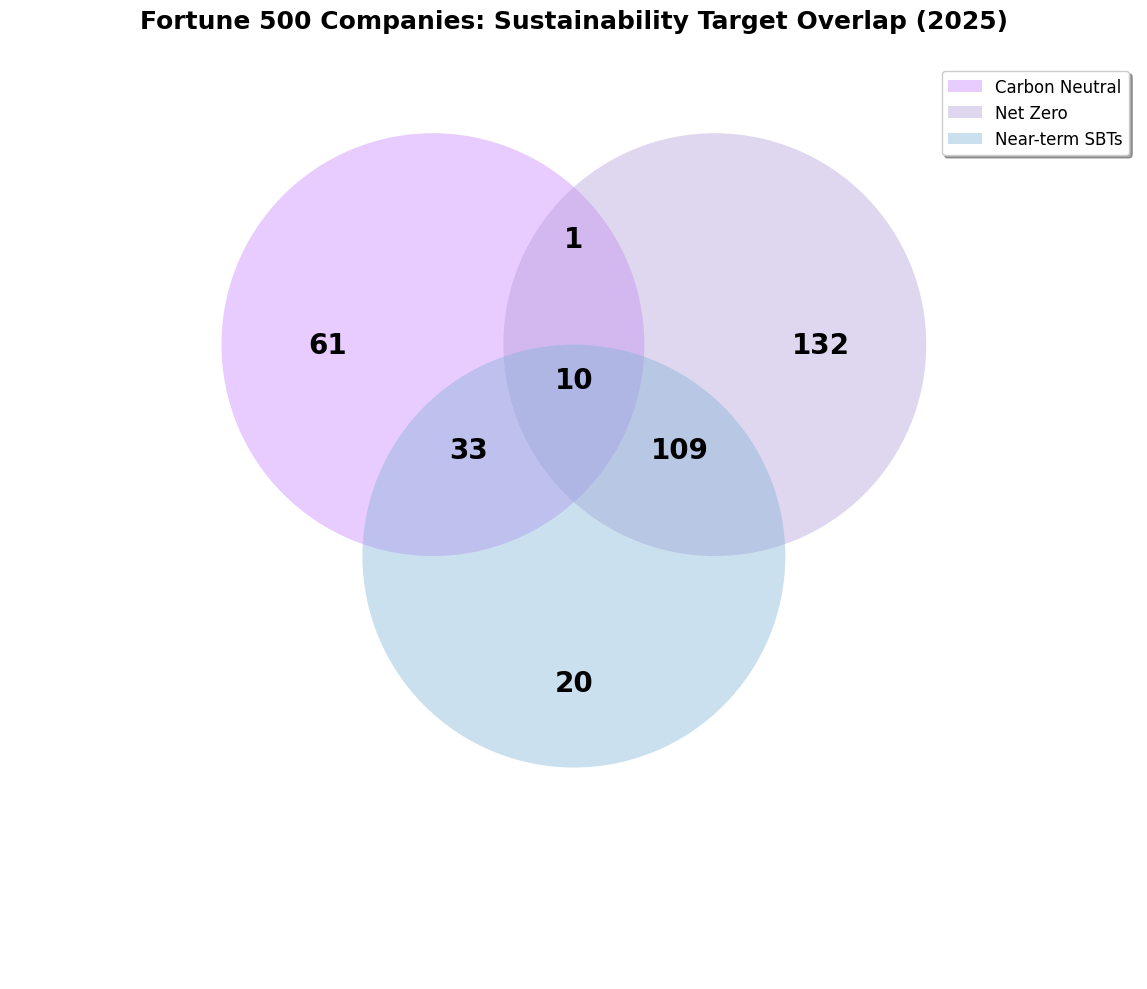

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
from matplotlib.patches import Patch
import numpy as np
from matplotlib.patches import Circle

# Read the CSV file
df = pd.read_csv('2025.csv', 
                 skiprows=2)  # Skip first 2 header rows
df = df.iloc[1:500] 
# Use column names directly instead of index numbers
cn_col = 'All CN'
nz_col = 'All NZ'
sbti_col = 'All SBTi ST'


# Convert to boolean
df[cn_col] = pd.to_numeric(df[cn_col], errors='coerce').fillna(0).astype(bool)
df[nz_col] = pd.to_numeric(df[nz_col], errors='coerce').fillna(0).astype(bool)
df[sbti_col] = pd.to_numeric(df[sbti_col], errors='coerce').fillna(0).astype(bool)

# Calculate all combinations
only_cn = ((df[cn_col]) & (~df[nz_col]) & (~df[sbti_col])).sum()
only_nz = ((~df[cn_col]) & (df[nz_col]) & (~df[sbti_col])).sum()
only_sbti = ((~df[cn_col]) & (~df[nz_col]) & (df[sbti_col])).sum()
cn_nz = ((df[cn_col]) & (df[nz_col]) & (~df[sbti_col])).sum()
cn_sbti = ((df[cn_col]) & (~df[nz_col]) & (df[sbti_col])).sum()
nz_sbti = ((~df[cn_col]) & (df[nz_col]) & (df[sbti_col])).sum()
all_three = ((df[cn_col]) & (df[nz_col]) & (df[sbti_col])).sum()

# Create figure
fig, ax = plt.subplots(figsize=(14, 10))

# Define circle positions (equal size, symmetric layout)
radius = 3
# Left circle (CN), Right circle (NZ), Bottom circle (SBTi)
cn_center = (-2, 1)
nz_center = (2, 1)
sbti_center = (0, -2)

# Colors
cn_color = '#C77DFF'
nz_color = '#B19CD9'
sbti_color = '#7FB3D5'

# Draw circles
circle_cn = Circle(cn_center, radius, color=cn_color, alpha=0.4, ec='none')
circle_nz = Circle(nz_center, radius, color=nz_color, alpha=0.4, ec='none')
circle_sbti = Circle(sbti_center, radius, color=sbti_color, alpha=0.4, ec='none')

ax.add_patch(circle_cn)
ax.add_patch(circle_nz)
ax.add_patch(circle_sbti)

# Add numbers in each section
# Only CN (left only)
ax.text(-3.5, 1, str(only_cn), fontsize=20, weight='bold', ha='center', va='center')

# Only NZ (right only)
ax.text(3.5, 1, str(only_nz), fontsize=20, weight='bold', ha='center', va='center')

# Only SBTi (bottom only)
ax.text(0, -3.8, str(only_sbti), fontsize=20, weight='bold', ha='center', va='center')

# CN + NZ (top middle)
ax.text(0, 2.5, str(cn_nz), fontsize=20, weight='bold', ha='center', va='center')

# CN + SBTi (bottom left)
ax.text(-1.5, -0.5, str(cn_sbti), fontsize=20, weight='bold', ha='center', va='center')

# NZ + SBTi (bottom right)
ax.text(1.5, -0.5, str(nz_sbti), fontsize=20, weight='bold', ha='center', va='center')

# All three (center)
ax.text(0, 0.5, str(all_three), fontsize=20, weight='bold', ha='center', va='center')


# Create legend
legend_elements = [
    Patch(facecolor=cn_color, alpha=0.4, label='Carbon Neutral'),
    Patch(facecolor=nz_color, alpha=0.4, label='Net Zero'),
    Patch(facecolor=sbti_color, alpha=0.4, label='Near-term SBTs')
]

ax.legend(handles=legend_elements, 
          loc='upper right', 
          fontsize=12,
          frameon=True,
          fancybox=True,
          shadow=True)

# Title
plt.title('Fortune 500 Companies: Sustainability Target Overlap (2025)', 
          fontsize=18, weight='bold', pad=25)

# Set axis properties
ax.set_xlim(-8, 8)
ax.set_ylim(-8, 5)
ax.set_aspect('equal')
ax.axis('off')

plt.tight_layout()
plt.savefig('venn_diagram_clean_organized.png', dpi=300, bbox_inches='tight', facecolor='white')

# Print summary
print("\n=== Venn Diagram Summary ===")
print(f"Only Carbon Neutral: {only_cn}")
print(f"Only Net Zero: {only_nz}")
print(f"Only SBTi: {only_sbti}")
print(f"CN + NZ (only): {cn_nz}")
print(f"CN + SBTi (only): {cn_sbti}")
print(f"NZ + SBTi (only): {nz_sbti}")
print(f"All Three: {all_three}")
print(f"\nTotal: {only_cn + only_nz + only_sbti + cn_nz + cn_sbti + nz_sbti + all_three}")

plt.show()

In [12]:
# Debug: Check what companies are in "all three"
all_three_companies = ((df[cn_col]) & (df[nz_col]) & (df[sbti_col]))
print(f"\nCompanies with ALL THREE (CN + NZ + SBTi): {all_three_companies.sum()}")
print("\nThese companies:")
print(df[all_three_companies][['Company name', cn_col, nz_col, sbti_col]])


Companies with ALL THREE (CN + NZ + SBTi): 15

These companies:
             Company name  All CN  All NZ  All SBTi ST
71       Deutsche Telekom    True    True         True
115      Tencent Holdings    True    True         True
211        COSCO Shipping    True    True         True
215               Hitachi    True    True         True
344      Woolworths Group    True    True         True
347       Quanta Computer    True    True         True
409          ThyssenKrupp    True    True         True
439      Jerónimo Martins    True    True         True
455  Daiwa House Industry    True    True         True
496             Medtronic    True    True         True
500                   NaN    True    True         True
506                   NaN    True    True         True
507                   NaN    True    True         True
508                   NaN    True    True         True
509                   NaN    True    True         True


In [7]:
# Add this right after reading the columns to debug:
print("Column names being used:")
print(f"CN column: '{cn_col}'")
print(f"NZ column: '{nz_col}'")
print(f"SBTi column: '{sbti_col}'")

# Check if columns exist
print(f"\nColumns in dataframe: {df.columns.tolist()}")

# Show sample data
print("\nSample data:")
print(df[[cn_col, nz_col, sbti_col]].head(20))

# Check unique values
print(f"\nUnique values in {cn_col}: {df[cn_col].unique()}")
print(f"Unique values in {nz_col}: {df[nz_col].unique()}")
print(f"Unique values in {sbti_col}: {df[sbti_col].unique()}")

Column names being used:
CN column: 'Any CN'
NZ column: 'Any NZ'
SBTi column: 'Any SBT'

Columns in dataframe: ['2025 Rank', '2024 rank', 'Company name', 'Sector (Fortune)', 'Sector (final classification)', 'Country', 'Region', 'Revenue ($M) usable', 'Profits ($M) usable', 'Profits (% change)', 'Assets ($M)', 'Employees', 'Years on list (2025)', 'RE100 (Y/N)', 'Joining year', 'Target year', 'In SBTI database?', 'Near Term SBT (Y = yes, N=no)', 'Target status (T = target set, C = committed, N=No, R=Removed)', 'Target classification (near term) - temp', 'Target year (near term) (earlier of the two dates if there were two) ', 'Long term - Target Status', 'Long term - Target Classification', 'Long term - Target Year', 'Net zero committed (SBTi) (Y = yes, N = no)', 'SBTi NZ Target Status', 'Net zero Target year (SBTi)', 'notes', 'NZ Tracker_End target (in their words)', 'NZ Tracker Target Grouping', 'Scope 1', 'Scope 2', 'Scope 3', 'Carbon neutral scope(s) - Scope 1,2,3 (NZ Tracker)', 'Carb

In [8]:
# Add this debugging code after the calculations:

# Check the CN+NZ overlap specifically
cn_and_nz_only = ((df[cn_col]) & (df[nz_col]) & (~df[sbti_col]))
print(f"CN+NZ (no SBTi): {cn_and_nz_only.sum()}")

# Check ALL companies with both CN and NZ (including those with SBTi)
cn_and_nz_total = ((df[cn_col]) & (df[nz_col]))
print(f"CN+NZ (total, including with SBTi): {cn_and_nz_total.sum()}")

# Show the companies
print("\nCompanies with CN+NZ (no SBTi):")
print(df[cn_and_nz_only][['Company name', cn_col, nz_col, sbti_col]])

print("\nCompanies with CN+NZ (including SBTi):")
print(df[cn_and_nz_total][['Company name', cn_col, nz_col, sbti_col]])

CN+NZ (no SBTi): 32
CN+NZ (total, including with SBTi): 70

Companies with CN+NZ (no SBTi):
                           Company name  Any CN  Any NZ  Any SBT
18                       JPMorgan Chase    True    True    False
33                      Bank of America    True    True    False
36                      Elevance Health    True    True    False
54                      Banco Santander    True    True    False
69                  Goldman Sachs Group    True    True    False
70                          Wells Fargo    True    True    False
75                              Allianz    True    True    False
92                       Morgan Stanley    True    True    False
95                              Equinor    True    True    False
100                Royal Bank of Canada    True    True    False
103                                 ENI    True    True    False
131               Toronto-Dominion Bank    True    True    False
135                                 PTT    True    True    Fals

Processed data:
                             Sector Count SBTi_<=2025 SBTi_2026-2030  \
0             Aerospace and defense     6           0              1   
1                        Automotive    53           0             13   
2                         Chemicals     8           0              1   
3              Energy and utilities    29           0              7   
4      Engineering and construction    24           0              3   
5                Financial services   129           4             10   
6   Food, beverages and agriculture    34           1             11   
7   Health care and pharmaceuticals    53           0             18   
8   Household and personal products    11           0              0   
9                  Industrial goods    20           0              8   
10                Metals and mining    14           0              1   
11                      Oil and gas    25           0              0   
12                      Real estate     2       

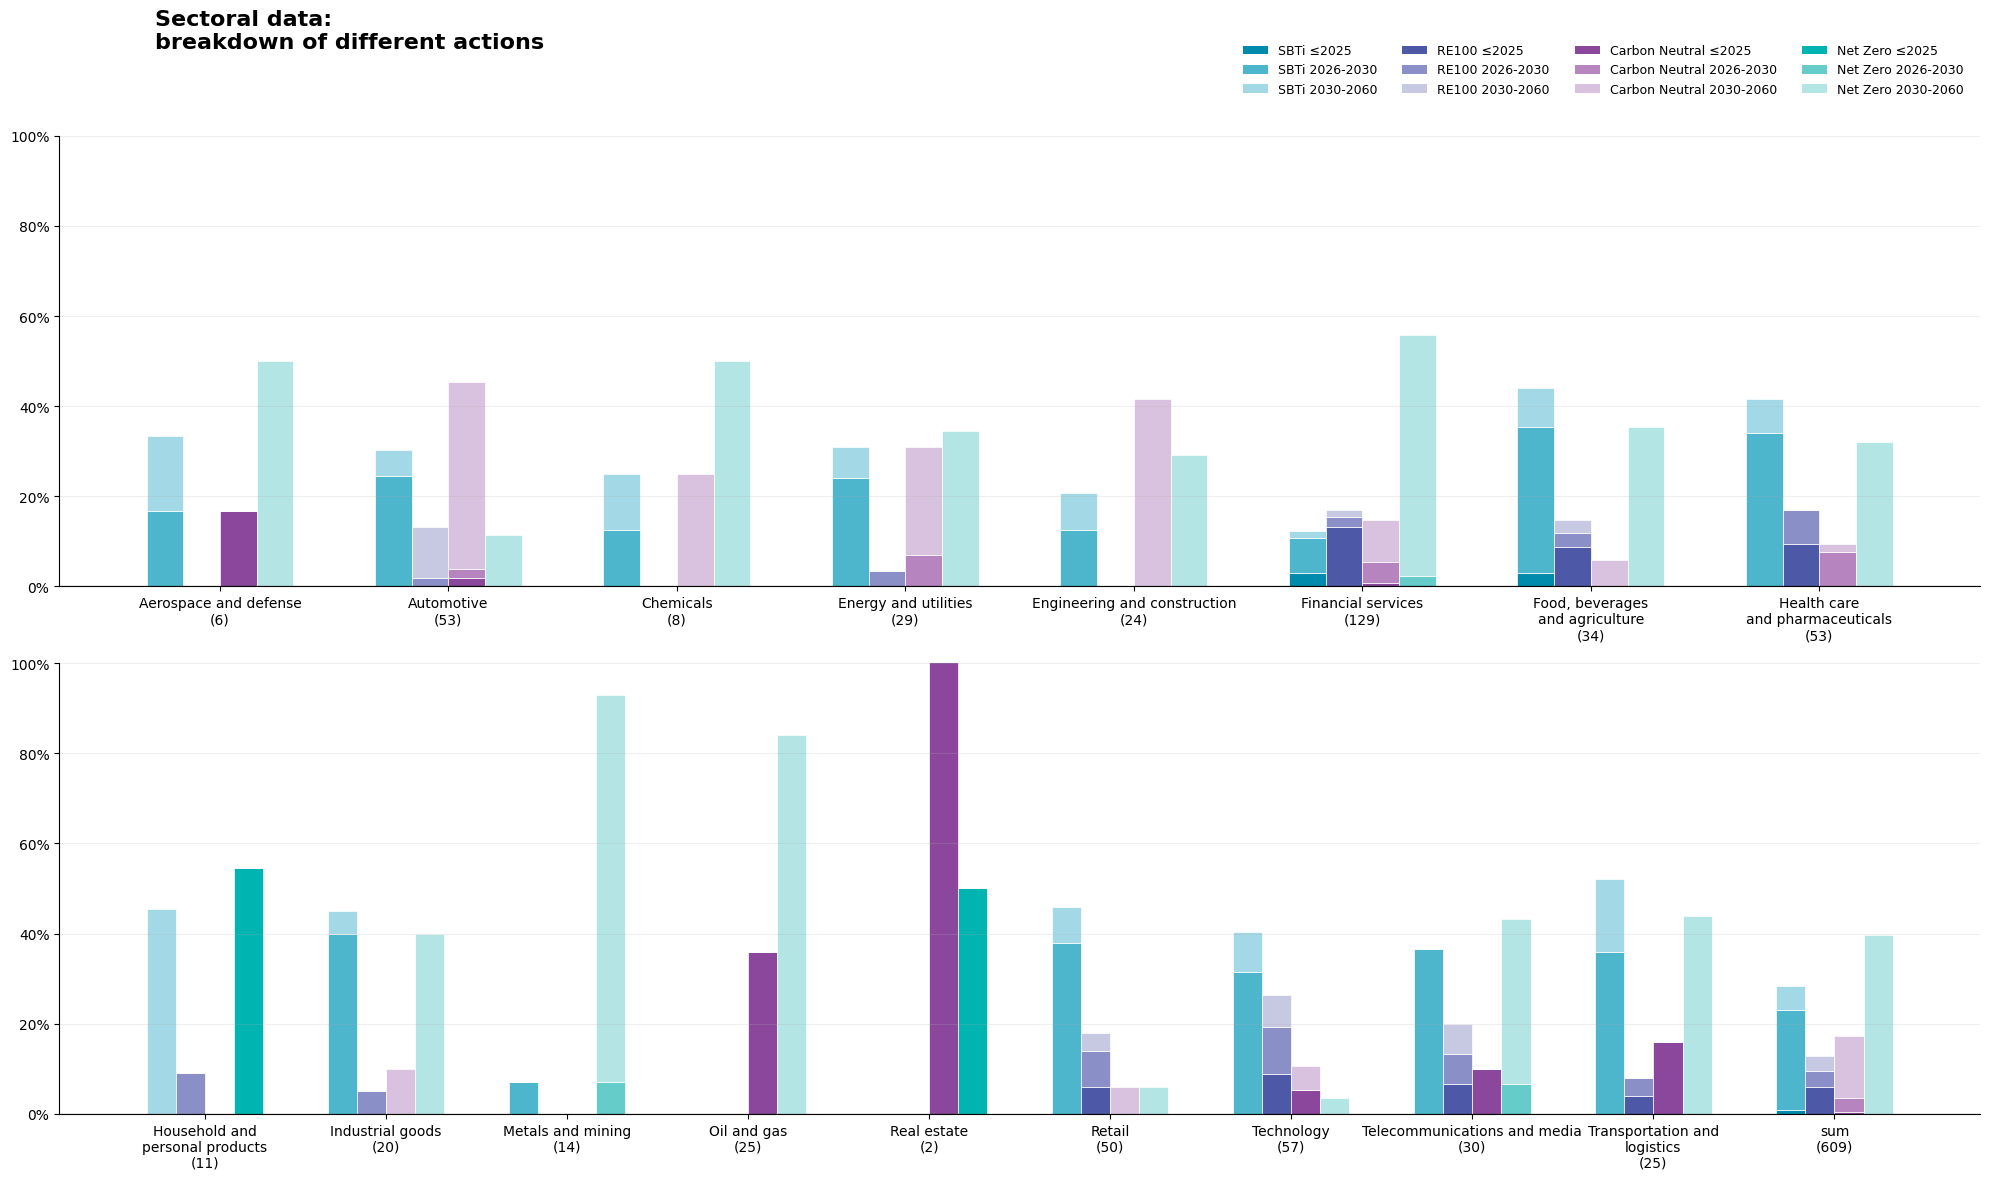


✓ Chart saved to: sectoral_breakdown.png


In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch

# Read the Excel file
df = pd.read_csv('sector_data_from_image.csv')

# Restructure data for plotting
# Rows are: SBTi short term, <=2025, 2026-2030, 2030-2060, RE100, <=2025, 2026-2030, 2030-2060, etc.

# Get sector names (excluding first and last column)
sectors = df.columns[1:-1].tolist()

# Extract data for each category and timeline
sbti_le2025 = df.iloc[1, 1:-1].values  # Row 1 (<=2025 under SBTi)
sbti_2026_2030 = df.iloc[2, 1:-1].values  # Row 2 (2026-2030 under SBTi)
sbti_2030_2060 = df.iloc[3, 1:-1].values  # Row 3 (2030-2060 under SBTi)

re100_le2025 = df.iloc[5, 1:-1].values  # Row 5 (<=2025 under RE100)
re100_2026_2030 = df.iloc[6, 1:-1].values  # Row 6 (2026-2030 under RE100)
re100_2030_2060 = df.iloc[7, 1:-1].values  # Row 7 (2030-2060 under RE100)

cn_le2025 = df.iloc[9, 1:-1].values  # Row 9 (<=2025 under Carbon Neutral)
cn_2026_2030 = df.iloc[10, 1:-1].values  # Row 10 (2026-2030 under Carbon Neutral)
cn_2030_2060 = df.iloc[11, 1:-1].values  # Row 11 (2030-2060 under Carbon Neutral)

nz_le2025 = df.iloc[13, 1:-1].values  # Row 13 (<=2025 under Net Zero)
nz_2026_2030 = df.iloc[14, 1:-1].values  # Row 14 (2026-2030 under Net Zero)
nz_2030_2060 = df.iloc[15, 1:-1].values  # Row 15 (2030-2060 under Net Zero)

# Get company counts per sector (sum row totals for each sector)
sector_counts = df.iloc[0, 1:-1].values + df.iloc[4, 1:-1].values + df.iloc[8, 1:-1].values + df.iloc[12, 1:-1].values

# Create dataframe for easier manipulation
plot_data = pd.DataFrame({
    'Sector': sectors,
    'Count': sector_counts,
    'SBTi_<=2025': sbti_le2025,
    'SBTi_2026-2030': sbti_2026_2030,
    'SBTi_2030-2060': sbti_2030_2060,
    'RE100_<=2025': re100_le2025,
    'RE100_2026-2030': re100_2026_2030,
    'RE100_2030-2060': re100_2030_2060,
    'CN_<=2025': cn_le2025,
    'CN_2026-2030': cn_2026_2030,
    'CN_2030-2060': cn_2030_2060,
    'NZ_<=2025': nz_le2025,
    'NZ_2026-2030': nz_2026_2030,
    'NZ_2030-2060': nz_2030_2060,
})

print("Processed data:")
print(plot_data)
print("\nSector counts:", plot_data['Count'].values)

# Create figure with two rows
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 12))

# Define colors with exact specifications - darker for closer targets, lighter for farther
colors = {
    # SBTi - Blue #008AAC (darker to lighter as targets get farther)
    'SBTi_<=2025': '#008AAC',       # Dark blue (closest)
    'SBTi_2026-2030': '#4DB5CC',    # Medium blue
    'SBTi_2030-2060': '#A3D9E6',    # Light blue (farthest)
    
    # RE100 - Violet #4D58A6 (darker to lighter)
    'RE100_<=2025': '#4D58A6',      # Dark violet (closest)
    'RE100_2026-2030': '#8A8FC7',   # Medium violet
    'RE100_2030-2060': '#C7C9E3',   # Light violet (farthest)
    
    # Carbon Neutral - Plum #8B479B (darker to lighter)
    'CN_<=2025': '#8B479B',         # Dark plum (closest)
    'CN_2026-2030': '#B685BF',      # Medium plum
    'CN_2030-2060': '#D9C2DF',      # Light plum (farthest)
    
    # Net Zero - Teal #00B4B2 (darker to lighter)
    'NZ_<=2025': '#00B4B2',         # Dark teal (closest)
    'NZ_2026-2030': '#66CCC9',      # Medium teal
    'NZ_2030-2060': '#B3E5E4',      # Light teal (farthest)
}

# Calculate percentages - ensure numeric types
for col in colors.keys():
    plot_data[col] = pd.to_numeric(plot_data[col], errors='coerce').fillna(0)
    plot_data['Count'] = pd.to_numeric(plot_data['Count'], errors='coerce').fillna(1)
    plot_data[col + '_pct'] = (plot_data[col] / plot_data['Count']) * 100
    plot_data[col + '_pct'] = plot_data[col + '_pct'].astype(float)

# Define bar groups - 4 bars per sector (SBTi, RE100, CN, NZ)
target_groups = {
    'SBTi': ['SBTi_<=2025', 'SBTi_2026-2030', 'SBTi_2030-2060'],
    'RE100': ['RE100_<=2025', 'RE100_2026-2030', 'RE100_2030-2060'],
    'CN': ['CN_<=2025', 'CN_2026-2030', 'CN_2030-2060'],
    'NZ': ['NZ_<=2025', 'NZ_2026-2030', 'NZ_2030-2060']
}

# First 8 sectors (top row)
sectors_top = plot_data.iloc[:8]
n_sectors_top = len(sectors_top)
bar_width = 0.18
group_width = bar_width * 4 + 0.1  # 4 bars + gap between sector groups

# Create x positions for each sector group
x_positions_top = []
for i in range(n_sectors_top):
    sector_center = i * (group_width + 0.3)
    x_positions_top.append(sector_center)

# Plot top row - 4 bars per sector
for idx, (target_name, timeline_cols) in enumerate(target_groups.items()):
    x_offset = (idx - 1.5) * bar_width  # Center the 4 bars around sector position
    
    for i, sector_idx in enumerate(range(len(sectors_top))):
        x_pos = x_positions_top[i] + x_offset
        bottom = 0
        
        # Stack the three timelines for this target
        for col in timeline_cols:
            value = sectors_top.iloc[sector_idx][col + '_pct']
            ax1.bar(x_pos, value, bar_width, bottom=bottom, 
                   color=colors[col], edgecolor='white', linewidth=0.5)
            bottom += value

ax1.set_ylabel('', fontsize=12, fontweight='bold')
ax1.set_xticks(x_positions_top)
# Wrap long sector names
sector_labels_top = []
for _, row in sectors_top.iterrows():
    name = row['Sector']
    # Wrap long names
    if len(name) > 25:
        words = name.split()
        if len(words) > 3:
            mid = len(words) // 2
            name = ' '.join(words[:mid]) + '\n' + ' '.join(words[mid:])
    sector_labels_top.append(f"{name}\n({int(row['Count'])})")
ax1.set_xticklabels(sector_labels_top, fontsize=10)
ax1.set_ylim(0, 100)
ax1.set_yticks([0, 20, 40, 60, 80, 100])
ax1.set_yticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])
ax1.grid(axis='y', alpha=0.3, linestyle='-', linewidth=0.5)
ax1.axhline(y=0, color='black', linewidth=0.8)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Last 9 sectors (bottom row)
sectors_bottom = plot_data.iloc[8:]
n_sectors_bottom = len(sectors_bottom)

# Create x positions for each sector group
x_positions_bottom = []
for i in range(n_sectors_bottom):
    sector_center = i * (group_width + 0.3)
    x_positions_bottom.append(sector_center)

# Plot bottom row - 4 bars per sector
for idx, (target_name, timeline_cols) in enumerate(target_groups.items()):
    x_offset = (idx - 1.5) * bar_width  # Center the 4 bars around sector position
    
    for i, sector_idx in enumerate(range(len(sectors_bottom))):
        x_pos = x_positions_bottom[i] + x_offset
        bottom = 0
        
        # Stack the three timelines for this target
        for col in timeline_cols:
            value = sectors_bottom.iloc[sector_idx][col + '_pct']
            ax2.bar(x_pos, value, bar_width, bottom=bottom, 
                   color=colors[col], edgecolor='white', linewidth=0.5)
            bottom += value

ax2.set_ylabel('', fontsize=12, fontweight='bold')
ax2.set_xticks(x_positions_bottom)
# Wrap long sector names
sector_labels_bottom = []
for _, row in sectors_bottom.iterrows():
    name = row['Sector']
    # Specific fix for Transportation and logistics
    if name == 'Transportation and logistics':
        name = 'Transportation and\nlogistics'
    # Wrap long names
    elif len(name) > 25:
        words = name.split()
        if len(words) > 3:
            mid = len(words) // 2
            name = ' '.join(words[:mid]) + '\n' + ' '.join(words[mid:])
    sector_labels_bottom.append(f"{name}\n({int(row['Count'])})")
ax2.set_xticklabels(sector_labels_bottom, fontsize=10)
ax2.set_ylim(0, 100)
ax2.set_yticks([0, 20, 40, 60, 80, 100])
ax2.set_yticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])
ax2.grid(axis='y', alpha=0.3, linestyle='-', linewidth=0.5)
ax2.axhline(y=0, color='black', linewidth=0.8)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

# Add title
fig.suptitle('Sectoral data:\nbreakdown of different actions', 
             fontsize=16, fontweight='bold', x=0.08, ha='left', va='top')

# Create custom legend - 4 columns, dark to light for each target type
legend_elements = [
    # Column 1: SBTi (dark to light)
    Patch(facecolor='#008AAC', label='SBTi ≤2025'),
    Patch(facecolor='#4DB5CC', label='SBTi 2026-2030'),
    Patch(facecolor='#A3D9E6', label='SBTi 2030-2060'),
    
    # Column 2: RE100 (dark to light)
    Patch(facecolor='#4D58A6', label='RE100 ≤2025'),
    Patch(facecolor='#8A8FC7', label='RE100 2026-2030'),
    Patch(facecolor='#C7C9E3', label='RE100 2030-2060'),
    
    # Column 3: Carbon Neutral (dark to light)
    Patch(facecolor='#8B479B', label='Carbon Neutral ≤2025'),
    Patch(facecolor='#B685BF', label='Carbon Neutral 2026-2030'),
    Patch(facecolor='#D9C2DF', label='Carbon Neutral 2030-2060'),
    
    # Column 4: Net Zero (dark to light)
    Patch(facecolor='#00B4B2', label='Net Zero ≤2025'),
    Patch(facecolor='#66CCC9', label='Net Zero 2026-2030'),
    Patch(facecolor='#B3E5E4', label='Net Zero 2030-2060'),
]

fig.legend(handles=legend_elements, loc='upper right', ncol=4, 
          frameon=False, fontsize=9, bbox_to_anchor=(0.99, 0.96))

plt.tight_layout(rect=[0, 0, 1, 0.94])
plt.savefig('sectoral_breakdown.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("\n✓ Chart saved to: sectoral_breakdown.png")

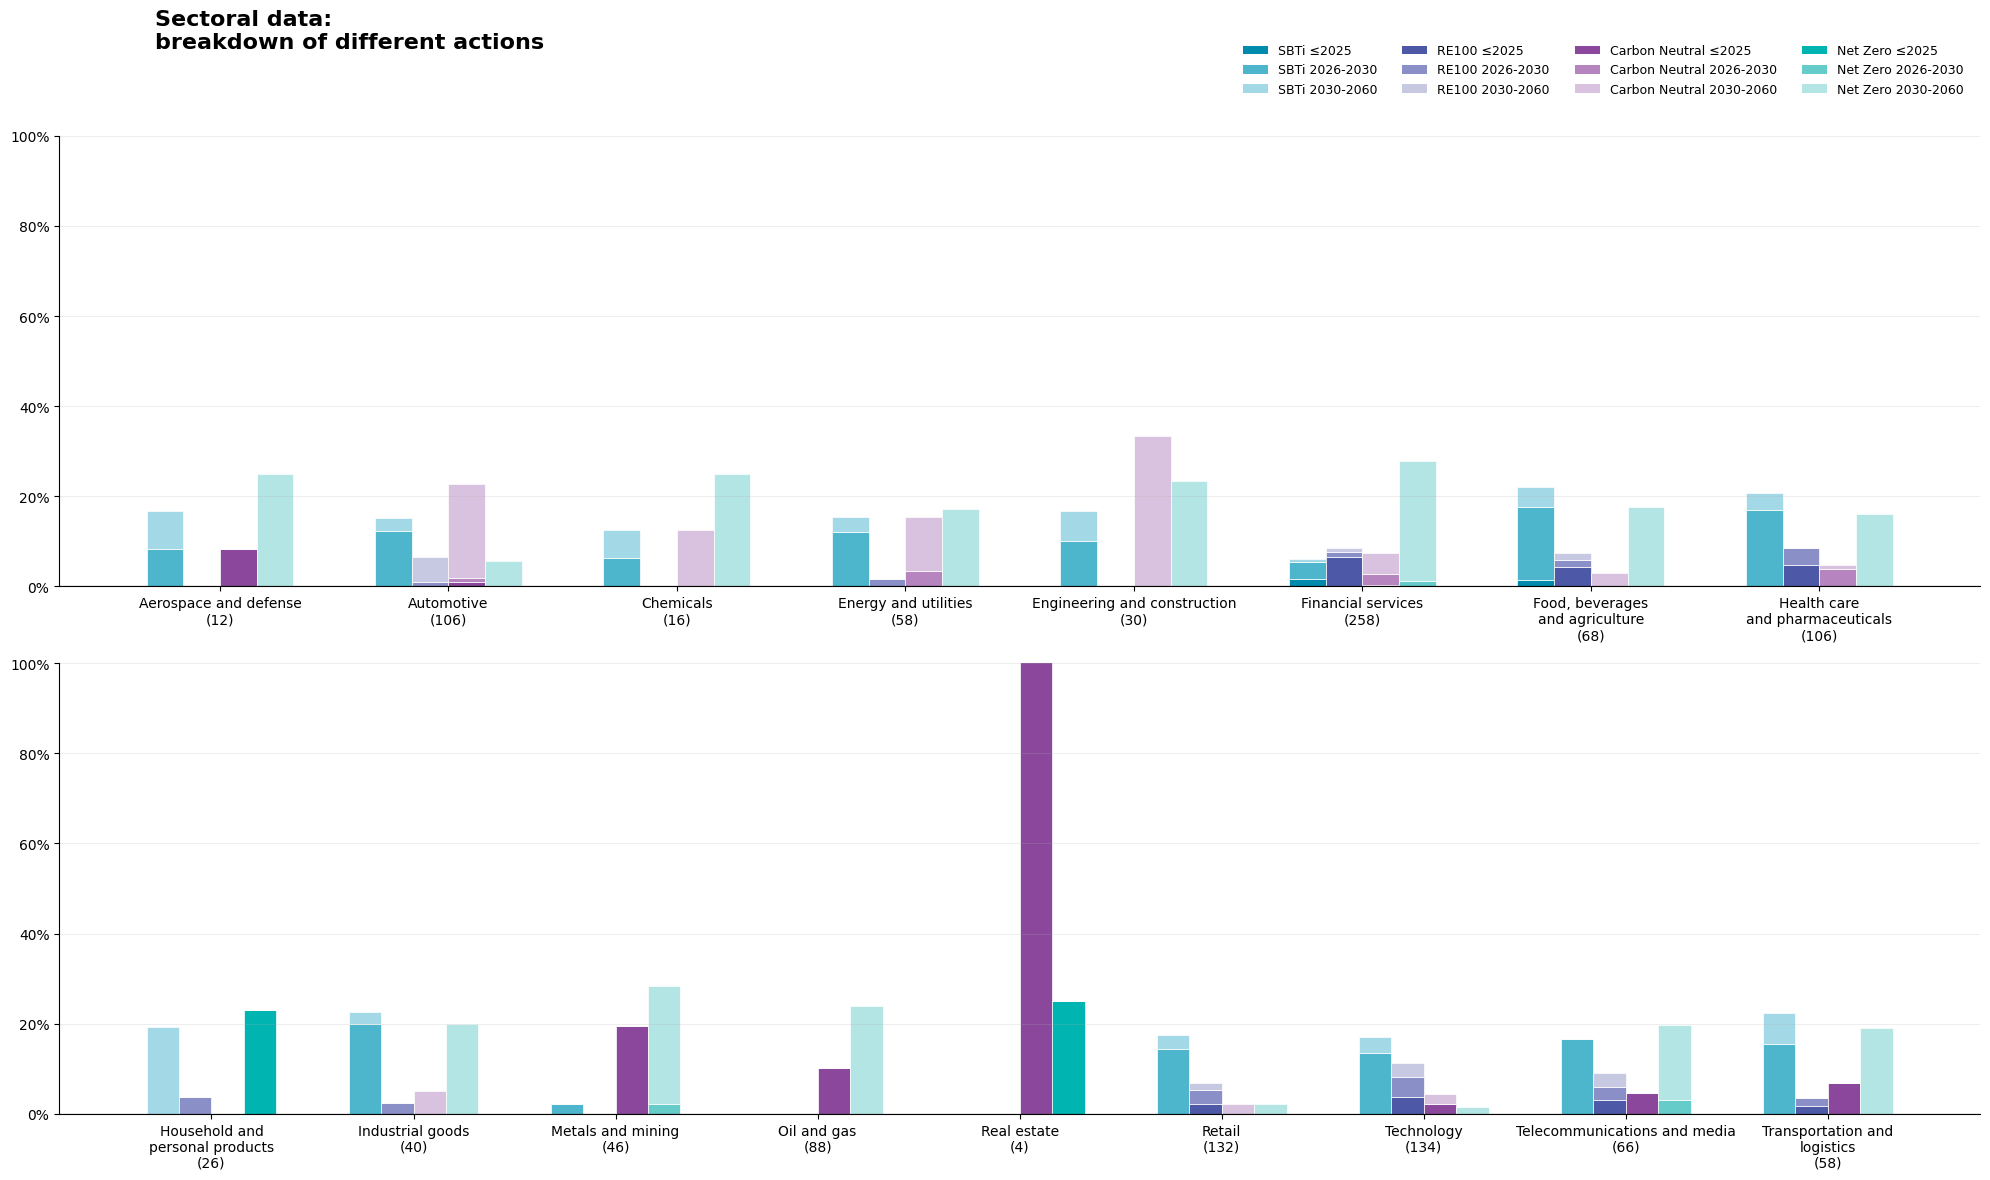


✓ Chart saved


In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch

# Create the correct dataframe directly from your image
sectors = ['Aerospace and defense', 'Automotive', 'Chemicals', 'Energy and utilities', 
           'Engineering and construction', 'Financial services', 'Food, beverages and agriculture',
           'Health care and pharmaceuticals', 'Household and personal products', 'Industrial goods',
           'Metals and mining', 'Oil and gas', 'Real estate', 'Retail', 'Technology',
           'Telecommunications and media', 'Transportation and logistics']

# Correct data from your image
plot_data = pd.DataFrame({
    'Sector': sectors,
    'Count': [12, 106, 16, 58, 30, 258, 68, 106, 26, 40, 46, 88, 4, 132, 134, 66, 58],
    'SBTi_<=2025': [0, 0, 0, 0, 0, 4, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    'SBTi_2026-2030': [1, 13, 1, 7, 3, 10, 11, 18, 0, 8, 1, 0, 0, 19, 18, 11, 9],
    'SBTi_2030-2060': [1, 3, 1, 2, 2, 2, 3, 4, 5, 1, 0, 0, 0, 4, 5, 0, 4],
    'RE100_<=2025': [0, 0, 0, 0, 0, 17, 3, 5, 0, 0, 0, 0, 0, 3, 5, 2, 1],
    'RE100_2026-2030': [0, 1, 0, 1, 0, 3, 1, 4, 1, 1, 0, 0, 0, 4, 6, 2, 1],
    'RE100_2030-2060': [0, 6, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 2, 4, 2, 0],
    'CN_<=2025': [1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 9, 9, 7, 0, 3, 3, 4],
    'CN_2026-2030': [0, 1, 0, 2, 0, 6, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    'CN_2030-2060': [0, 22, 2, 7, 10, 12, 2, 1, 0, 2, 0, 0, 0, 3, 3, 0, 0],
    'NZ_<=2025': [0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 1, 0, 0, 0, 0],
    'NZ_2026-2030': [0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0],
    'NZ_2030-2060': [3, 6, 4, 10, 7, 69, 12, 17, 0, 8, 12, 21, 0, 3, 2, 11, 11]
})

# Create figure with two rows
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 12))

# Define colors - darker for closer targets, lighter for farther
colors = {
    'SBTi_<=2025': '#008AAC',
    'SBTi_2026-2030': '#4DB5CC',
    'SBTi_2030-2060': '#A3D9E6',
    'RE100_<=2025': '#4D58A6',
    'RE100_2026-2030': '#8A8FC7',
    'RE100_2030-2060': '#C7C9E3',
    'CN_<=2025': '#8B479B',
    'CN_2026-2030': '#B685BF',
    'CN_2030-2060': '#D9C2DF',
    'NZ_<=2025': '#00B4B2',
    'NZ_2026-2030': '#66CCC9',
    'NZ_2030-2060': '#B3E5E4',
}

# Calculate percentages
for col in colors.keys():
    plot_data[col + '_pct'] = (plot_data[col] / plot_data['Count']) * 100

# Define bar groups - 4 bars per sector
target_groups = {
    'SBTi': ['SBTi_<=2025', 'SBTi_2026-2030', 'SBTi_2030-2060'],
    'RE100': ['RE100_<=2025', 'RE100_2026-2030', 'RE100_2030-2060'],
    'CN': ['CN_<=2025', 'CN_2026-2030', 'CN_2030-2060'],
    'NZ': ['NZ_<=2025', 'NZ_2026-2030', 'NZ_2030-2060']
}

# First 8 sectors (top row)
sectors_top = plot_data.iloc[:8]
n_sectors_top = len(sectors_top)
bar_width = 0.18
group_width = bar_width * 4 + 0.1

x_positions_top = []
for i in range(n_sectors_top):
    sector_center = i * (group_width + 0.3)
    x_positions_top.append(sector_center)

# Plot top row
for idx, (target_name, timeline_cols) in enumerate(target_groups.items()):
    x_offset = (idx - 1.5) * bar_width
    
    for i, sector_idx in enumerate(range(len(sectors_top))):
        x_pos = x_positions_top[i] + x_offset
        bottom = 0
        
        for col in timeline_cols:
            value = sectors_top.iloc[sector_idx][col + '_pct']
            ax1.bar(x_pos, value, bar_width, bottom=bottom, 
                   color=colors[col], edgecolor='white', linewidth=0.5)
            bottom += value

ax1.set_ylabel('', fontsize=12, fontweight='bold')
ax1.set_xticks(x_positions_top)
sector_labels_top = []
for _, row in sectors_top.iterrows():
    name = row['Sector']
    if len(name) > 25:
        words = name.split()
        if len(words) > 3:
            mid = len(words) // 2
            name = ' '.join(words[:mid]) + '\n' + ' '.join(words[mid:])
    sector_labels_top.append(f"{name}\n({int(row['Count'])})")
ax1.set_xticklabels(sector_labels_top, fontsize=10)
ax1.set_ylim(0, 100)
ax1.set_yticks([0, 20, 40, 60, 80, 100])
ax1.set_yticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])
ax1.grid(axis='y', alpha=0.3, linestyle='-', linewidth=0.5)
ax1.axhline(y=0, color='black', linewidth=0.8)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Last 9 sectors (bottom row)
sectors_bottom = plot_data.iloc[8:]
n_sectors_bottom = len(sectors_bottom)

x_positions_bottom = []
for i in range(n_sectors_bottom):
    sector_center = i * (group_width + 0.3)
    x_positions_bottom.append(sector_center)

# Plot bottom row
for idx, (target_name, timeline_cols) in enumerate(target_groups.items()):
    x_offset = (idx - 1.5) * bar_width
    
    for i, sector_idx in enumerate(range(len(sectors_bottom))):
        x_pos = x_positions_bottom[i] + x_offset
        bottom = 0
        
        for col in timeline_cols:
            value = sectors_bottom.iloc[sector_idx][col + '_pct']
            ax2.bar(x_pos, value, bar_width, bottom=bottom, 
                   color=colors[col], edgecolor='white', linewidth=0.5)
            bottom += value

ax2.set_ylabel('', fontsize=12, fontweight='bold')
ax2.set_xticks(x_positions_bottom)
sector_labels_bottom = []
for _, row in sectors_bottom.iterrows():
    name = row['Sector']
    if name == 'Transportation and logistics':
        name = 'Transportation and\nlogistics'
    elif len(name) > 25:
        words = name.split()
        if len(words) > 3:
            mid = len(words) // 2
            name = ' '.join(words[:mid]) + '\n' + ' '.join(words[mid:])
    sector_labels_bottom.append(f"{name}\n({int(row['Count'])})")
ax2.set_xticklabels(sector_labels_bottom, fontsize=10)
ax2.set_ylim(0, 100)
ax2.set_yticks([0, 20, 40, 60, 80, 100])
ax2.set_yticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])
ax2.grid(axis='y', alpha=0.3, linestyle='-', linewidth=0.5)
ax2.axhline(y=0, color='black', linewidth=0.8)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

# Title
fig.suptitle('Sectoral data:\nbreakdown of different actions', 
             fontsize=16, fontweight='bold', x=0.08, ha='left', va='top')

# Legend - 4 columns, dark to light
legend_elements = [
    Patch(facecolor='#008AAC', label='SBTi ≤2025'),
    Patch(facecolor='#4DB5CC', label='SBTi 2026-2030'),
    Patch(facecolor='#A3D9E6', label='SBTi 2030-2060'),
    Patch(facecolor='#4D58A6', label='RE100 ≤2025'),
    Patch(facecolor='#8A8FC7', label='RE100 2026-2030'),
    Patch(facecolor='#C7C9E3', label='RE100 2030-2060'),
    Patch(facecolor='#8B479B', label='Carbon Neutral ≤2025'),
    Patch(facecolor='#B685BF', label='Carbon Neutral 2026-2030'),
    Patch(facecolor='#D9C2DF', label='Carbon Neutral 2030-2060'),
    Patch(facecolor='#00B4B2', label='Net Zero ≤2025'),
    Patch(facecolor='#66CCC9', label='Net Zero 2026-2030'),
    Patch(facecolor='#B3E5E4', label='Net Zero 2030-2060'),
]

fig.legend(handles=legend_elements, loc='upper right', ncol=4, 
          frameon=False, fontsize=9, bbox_to_anchor=(0.99, 0.96))

plt.tight_layout(rect=[0, 0, 1, 0.94])
plt.savefig('sectoral_breakdown.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("\n✓ Chart saved")

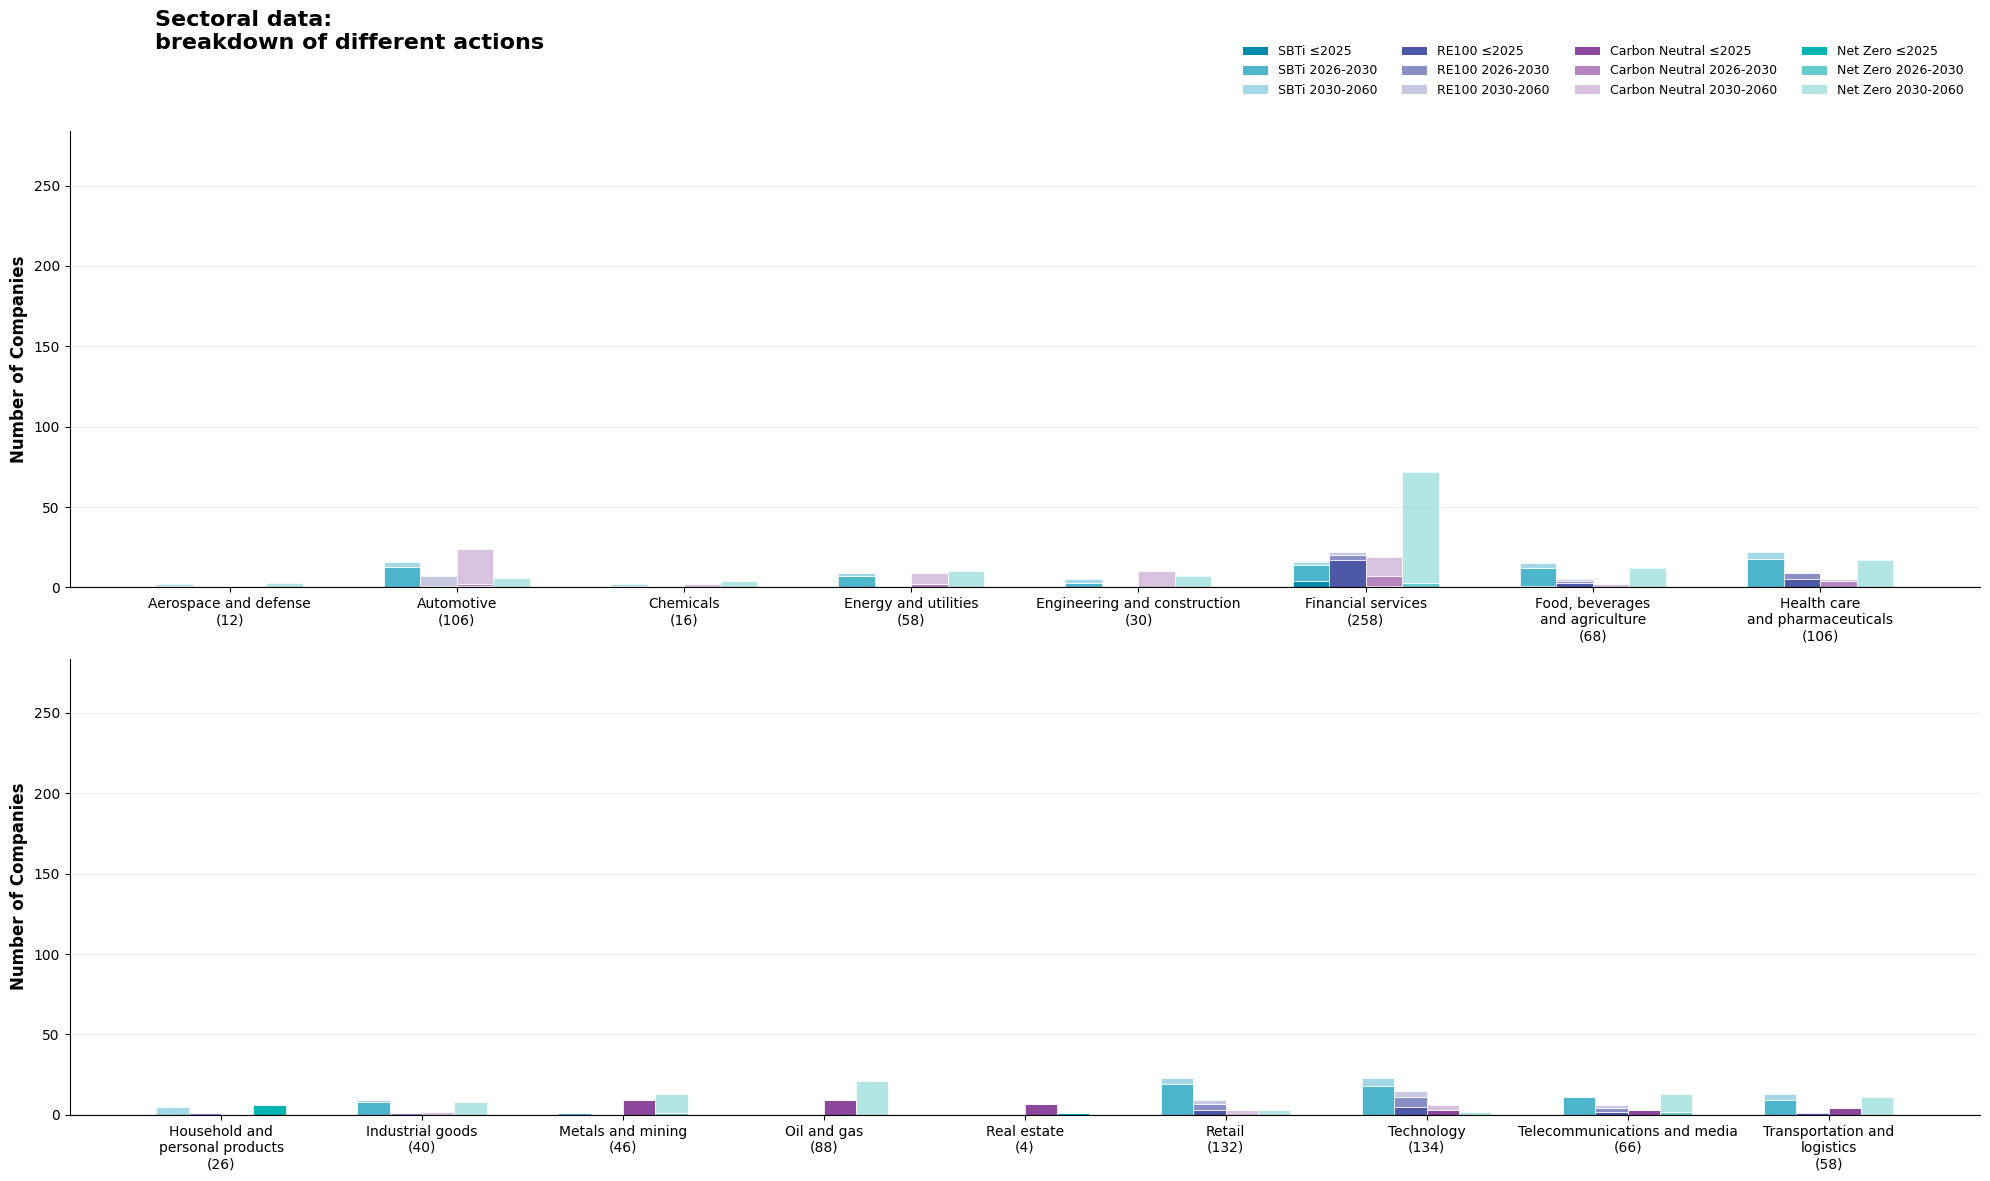


✓ Chart saved


In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch

# Create the correct dataframe directly from your image
sectors = ['Aerospace and defense', 'Automotive', 'Chemicals', 'Energy and utilities', 
           'Engineering and construction', 'Financial services', 'Food, beverages and agriculture',
           'Health care and pharmaceuticals', 'Household and personal products', 'Industrial goods',
           'Metals and mining', 'Oil and gas', 'Real estate', 'Retail', 'Technology',
           'Telecommunications and media', 'Transportation and logistics']

# Correct data from your image
plot_data = pd.DataFrame({
    'Sector': sectors,
    'Count': [12, 106, 16, 58, 30, 258, 68, 106, 26, 40, 46, 88, 4, 132, 134, 66, 58],
    'SBTi_<=2025': [0, 0, 0, 0, 0, 4, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    'SBTi_2026-2030': [1, 13, 1, 7, 3, 10, 11, 18, 0, 8, 1, 0, 0, 19, 18, 11, 9],
    'SBTi_2030-2060': [1, 3, 1, 2, 2, 2, 3, 4, 5, 1, 0, 0, 0, 4, 5, 0, 4],
    'RE100_<=2025': [0, 0, 0, 0, 0, 17, 3, 5, 0, 0, 0, 0, 0, 3, 5, 2, 1],
    'RE100_2026-2030': [0, 1, 0, 1, 0, 3, 1, 4, 1, 1, 0, 0, 0, 4, 6, 2, 1],
    'RE100_2030-2060': [0, 6, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 2, 4, 2, 0],
    'CN_<=2025': [1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 9, 9, 7, 0, 3, 3, 4],
    'CN_2026-2030': [0, 1, 0, 2, 0, 6, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    'CN_2030-2060': [0, 22, 2, 7, 10, 12, 2, 1, 0, 2, 0, 0, 0, 3, 3, 0, 0],
    'NZ_<=2025': [0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 1, 0, 0, 0, 0],
    'NZ_2026-2030': [0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0],
    'NZ_2030-2060': [3, 6, 4, 10, 7, 69, 12, 17, 0, 8, 12, 21, 0, 3, 2, 11, 11]
})

# Create figure with two rows
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 12))

# Define colors - darker for closer targets, lighter for farther
colors = {
    'SBTi_<=2025': '#008AAC',
    'SBTi_2026-2030': '#4DB5CC',
    'SBTi_2030-2060': '#A3D9E6',
    'RE100_<=2025': '#4D58A6',
    'RE100_2026-2030': '#8A8FC7',
    'RE100_2030-2060': '#C7C9E3',
    'CN_<=2025': '#8B479B',
    'CN_2026-2030': '#B685BF',
    'CN_2030-2060': '#D9C2DF',
    'NZ_<=2025': '#00B4B2',
    'NZ_2026-2030': '#66CCC9',
    'NZ_2030-2060': '#B3E5E4',
}

# Define bar groups - 4 bars per sector
target_groups = {
    'SBTi': ['SBTi_<=2025', 'SBTi_2026-2030', 'SBTi_2030-2060'],
    'RE100': ['RE100_<=2025', 'RE100_2026-2030', 'RE100_2030-2060'],
    'CN': ['CN_<=2025', 'CN_2026-2030', 'CN_2030-2060'],
    'NZ': ['NZ_<=2025', 'NZ_2026-2030', 'NZ_2030-2060']
}

# First 8 sectors (top row)
sectors_top = plot_data.iloc[:8]
n_sectors_top = len(sectors_top)
bar_width = 0.18
group_width = bar_width * 4 + 0.1

x_positions_top = []
for i in range(n_sectors_top):
    sector_center = i * (group_width + 0.3)
    x_positions_top.append(sector_center)

# Plot top row
for idx, (target_name, timeline_cols) in enumerate(target_groups.items()):
    x_offset = (idx - 1.5) * bar_width
    
    for i, sector_idx in enumerate(range(len(sectors_top))):
        x_pos = x_positions_top[i] + x_offset
        bottom = 0
        
        for col in timeline_cols:
            value = sectors_top.iloc[sector_idx][col]
            ax1.bar(x_pos, value, bar_width, bottom=bottom, 
                   color=colors[col], edgecolor='white', linewidth=0.5)
            bottom += value

ax1.set_ylabel('Number of Companies', fontsize=12, fontweight='bold')
ax1.set_xticks(x_positions_top)
sector_labels_top = []
for _, row in sectors_top.iterrows():
    name = row['Sector']
    if len(name) > 25:
        words = name.split()
        if len(words) > 3:
            mid = len(words) // 2
            name = ' '.join(words[:mid]) + '\n' + ' '.join(words[mid:])
    sector_labels_top.append(f"{name}\n({int(row['Count'])})")
ax1.set_xticklabels(sector_labels_top, fontsize=10)
ax1.set_ylim(0, max(plot_data['Count']) * 1.1)
ax1.grid(axis='y', alpha=0.3, linestyle='-', linewidth=0.5)
ax1.axhline(y=0, color='black', linewidth=0.8)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Last 9 sectors (bottom row)
sectors_bottom = plot_data.iloc[8:]
n_sectors_bottom = len(sectors_bottom)

x_positions_bottom = []
for i in range(n_sectors_bottom):
    sector_center = i * (group_width + 0.3)
    x_positions_bottom.append(sector_center)

# Plot bottom row
for idx, (target_name, timeline_cols) in enumerate(target_groups.items()):
    x_offset = (idx - 1.5) * bar_width
    
    for i, sector_idx in enumerate(range(len(sectors_bottom))):
        x_pos = x_positions_bottom[i] + x_offset
        bottom = 0
        
        for col in timeline_cols:
            value = sectors_bottom.iloc[sector_idx][col]
            ax2.bar(x_pos, value, bar_width, bottom=bottom, 
                   color=colors[col], edgecolor='white', linewidth=0.5)
            bottom += value

ax2.set_ylabel('Number of Companies', fontsize=12, fontweight='bold')
ax2.set_xticks(x_positions_bottom)
sector_labels_bottom = []
for _, row in sectors_bottom.iterrows():
    name = row['Sector']
    if name == 'Transportation and logistics':
        name = 'Transportation and\nlogistics'
    elif len(name) > 25:
        words = name.split()
        if len(words) > 3:
            mid = len(words) // 2
            name = ' '.join(words[:mid]) + '\n' + ' '.join(words[mid:])
    sector_labels_bottom.append(f"{name}\n({int(row['Count'])})")
ax2.set_xticklabels(sector_labels_bottom, fontsize=10)
ax2.set_ylim(0, max(plot_data['Count']) * 1.1)
ax2.grid(axis='y', alpha=0.3, linestyle='-', linewidth=0.5)
ax2.axhline(y=0, color='black', linewidth=0.8)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

# Title
fig.suptitle('Sectoral data:\nbreakdown of different actions', 
             fontsize=16, fontweight='bold', x=0.08, ha='left', va='top')

# Legend - 4 columns, dark to light
legend_elements = [
    Patch(facecolor='#008AAC', label='SBTi ≤2025'),
    Patch(facecolor='#4DB5CC', label='SBTi 2026-2030'),
    Patch(facecolor='#A3D9E6', label='SBTi 2030-2060'),
    Patch(facecolor='#4D58A6', label='RE100 ≤2025'),
    Patch(facecolor='#8A8FC7', label='RE100 2026-2030'),
    Patch(facecolor='#C7C9E3', label='RE100 2030-2060'),
    Patch(facecolor='#8B479B', label='Carbon Neutral ≤2025'),
    Patch(facecolor='#B685BF', label='Carbon Neutral 2026-2030'),
    Patch(facecolor='#D9C2DF', label='Carbon Neutral 2030-2060'),
    Patch(facecolor='#00B4B2', label='Net Zero ≤2025'),
    Patch(facecolor='#66CCC9', label='Net Zero 2026-2030'),
    Patch(facecolor='#B3E5E4', label='Net Zero 2030-2060'),
]

fig.legend(handles=legend_elements, loc='upper right', ncol=4, 
          frameon=False, fontsize=9, bbox_to_anchor=(0.99, 0.96))

plt.tight_layout(rect=[0, 0, 1, 0.94])
plt.savefig('sectoral_breakdown.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("\n✓ Chart saved")

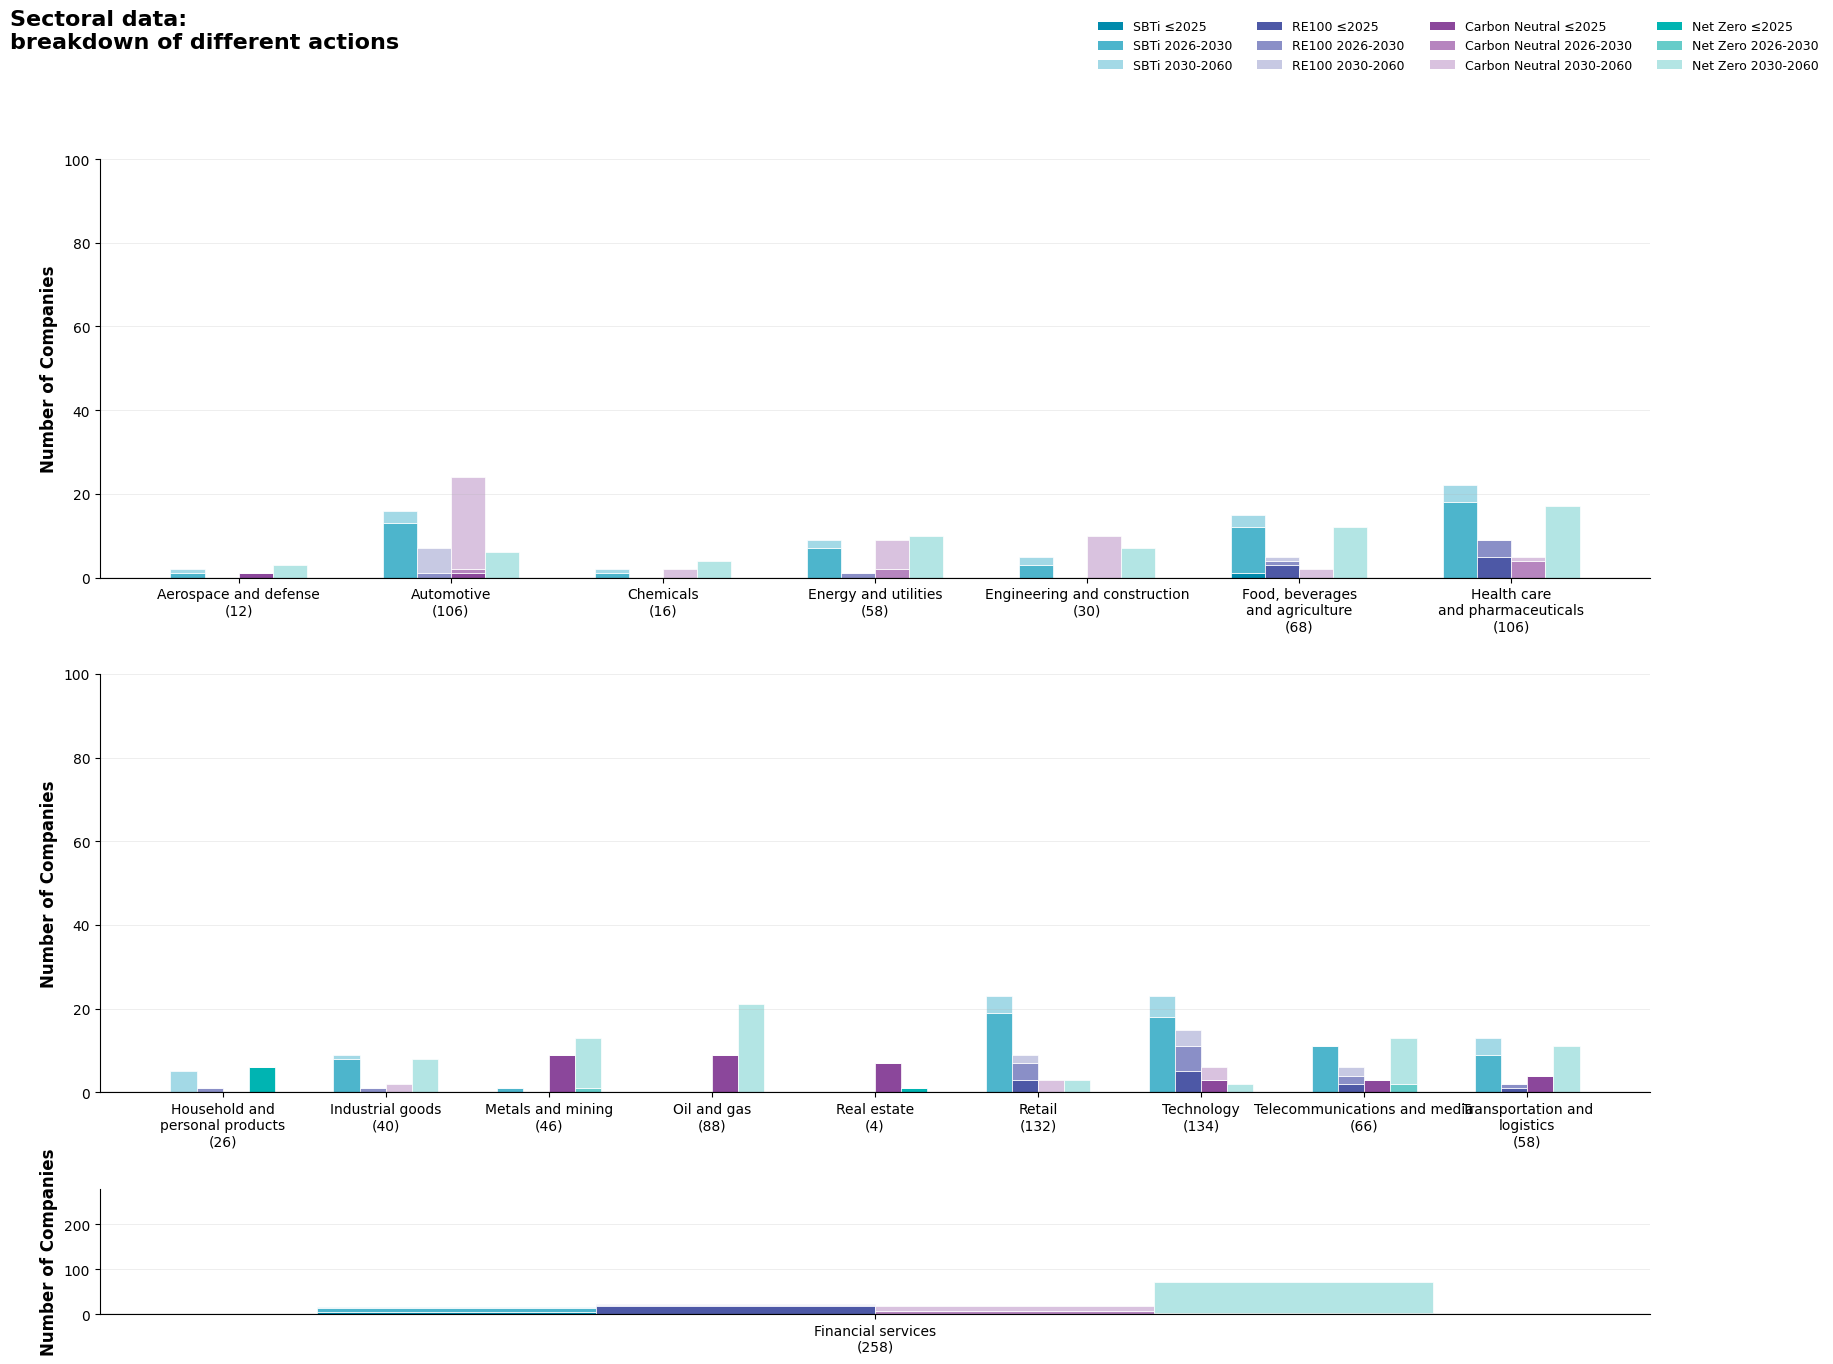


✓ Chart saved


In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch

# Create the correct dataframe directly from your image
sectors = ['Aerospace and defense', 'Automotive', 'Chemicals', 'Energy and utilities', 
           'Engineering and construction', 'Financial services', 'Food, beverages and agriculture',
           'Health care and pharmaceuticals', 'Household and personal products', 'Industrial goods',
           'Metals and mining', 'Oil and gas', 'Real estate', 'Retail', 'Technology',
           'Telecommunications and media', 'Transportation and logistics']

# Correct data from your image
plot_data = pd.DataFrame({
    'Sector': sectors,
    'Count': [12, 106, 16, 58, 30, 258, 68, 106, 26, 40, 46, 88, 4, 132, 134, 66, 58],
    'SBTi_<=2025': [0, 0, 0, 0, 0, 4, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    'SBTi_2026-2030': [1, 13, 1, 7, 3, 10, 11, 18, 0, 8, 1, 0, 0, 19, 18, 11, 9],
    'SBTi_2030-2060': [1, 3, 1, 2, 2, 2, 3, 4, 5, 1, 0, 0, 0, 4, 5, 0, 4],
    'RE100_<=2025': [0, 0, 0, 0, 0, 17, 3, 5, 0, 0, 0, 0, 0, 3, 5, 2, 1],
    'RE100_2026-2030': [0, 1, 0, 1, 0, 3, 1, 4, 1, 1, 0, 0, 0, 4, 6, 2, 1],
    'RE100_2030-2060': [0, 6, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 2, 4, 2, 0],
    'CN_<=2025': [1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 9, 9, 7, 0, 3, 3, 4],
    'CN_2026-2030': [0, 1, 0, 2, 0, 6, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    'CN_2030-2060': [0, 22, 2, 7, 10, 12, 2, 1, 0, 2, 0, 0, 0, 3, 3, 0, 0],
    'NZ_<=2025': [0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 1, 0, 0, 0, 0],
    'NZ_2026-2030': [0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0],
    'NZ_2030-2060': [3, 6, 4, 10, 7, 69, 12, 17, 0, 8, 12, 21, 0, 3, 2, 11, 11]
})

# Split data: Financial services separate, others in two rows
financial_services = plot_data[plot_data['Sector'] == 'Financial services']
other_sectors = plot_data[plot_data['Sector'] != 'Financial services']

# Create figure with three rows (top 7, bottom 9, Financial services separate)
fig = plt.figure(figsize=(20, 15))
gs = fig.add_gridspec(3, 1, height_ratios=[1, 1, 0.3], hspace=0.3)
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
ax3 = fig.add_subplot(gs[2])

# Define colors - darker for closer targets, lighter for farther
colors = {
    'SBTi_<=2025': '#008AAC',
    'SBTi_2026-2030': '#4DB5CC',
    'SBTi_2030-2060': '#A3D9E6',
    'RE100_<=2025': '#4D58A6',
    'RE100_2026-2030': '#8A8FC7',
    'RE100_2030-2060': '#C7C9E3',
    'CN_<=2025': '#8B479B',
    'CN_2026-2030': '#B685BF',
    'CN_2030-2060': '#D9C2DF',
    'NZ_<=2025': '#00B4B2',
    'NZ_2026-2030': '#66CCC9',
    'NZ_2030-2060': '#B3E5E4',
}

# Define bar groups - 4 bars per sector
target_groups = {
    'SBTi': ['SBTi_<=2025', 'SBTi_2026-2030', 'SBTi_2030-2060'],
    'RE100': ['RE100_<=2025', 'RE100_2026-2030', 'RE100_2030-2060'],
    'CN': ['CN_<=2025', 'CN_2026-2030', 'CN_2030-2060'],
    'NZ': ['NZ_<=2025', 'NZ_2026-2030', 'NZ_2030-2060']
}

bar_width = 0.18
group_width = bar_width * 4 + 0.1

# First 7 sectors (excluding Financial services from position 5)
sectors_top = other_sectors.iloc[:5]  # Aerospace to Engineering
sectors_top = pd.concat([sectors_top, other_sectors.iloc[5:7]])  # Add Food and Healthcare
n_sectors_top = len(sectors_top)

x_positions_top = []
for i in range(n_sectors_top):
    sector_center = i * (group_width + 0.3)
    x_positions_top.append(sector_center)

# Plot top row
for idx, (target_name, timeline_cols) in enumerate(target_groups.items()):
    x_offset = (idx - 1.5) * bar_width
    
    for i, sector_idx in enumerate(range(len(sectors_top))):
        x_pos = x_positions_top[i] + x_offset
        bottom = 0
        
        for col in timeline_cols:
            value = sectors_top.iloc[sector_idx][col]
            ax1.bar(x_pos, value, bar_width, bottom=bottom, 
                   color=colors[col], edgecolor='white', linewidth=0.5)
            bottom += value

ax1.set_ylabel('Number of Companies', fontsize=12, fontweight='bold')
ax1.set_xticks(x_positions_top)
sector_labels_top = []
for _, row in sectors_top.iterrows():
    name = row['Sector']
    if len(name) > 25:
        words = name.split()
        if len(words) > 3:
            mid = len(words) // 2
            name = ' '.join(words[:mid]) + '\n' + ' '.join(words[mid:])
    sector_labels_top.append(f"{name}\n({int(row['Count'])})")
ax1.set_xticklabels(sector_labels_top, fontsize=10)
ax1.set_ylim(0, 100)
ax1.grid(axis='y', alpha=0.3, linestyle='-', linewidth=0.5)
ax1.axhline(y=0, color='black', linewidth=0.8)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Remaining sectors (bottom row)
sectors_bottom = other_sectors.iloc[7:]  # Household onwards
n_sectors_bottom = len(sectors_bottom)

x_positions_bottom = []
for i in range(n_sectors_bottom):
    sector_center = i * (group_width + 0.3)
    x_positions_bottom.append(sector_center)

# Plot bottom row
for idx, (target_name, timeline_cols) in enumerate(target_groups.items()):
    x_offset = (idx - 1.5) * bar_width
    
    for i, sector_idx in enumerate(range(len(sectors_bottom))):
        x_pos = x_positions_bottom[i] + x_offset
        bottom = 0
        
        for col in timeline_cols:
            value = sectors_bottom.iloc[sector_idx][col]
            ax2.bar(x_pos, value, bar_width, bottom=bottom, 
                   color=colors[col], edgecolor='white', linewidth=0.5)
            bottom += value

ax2.set_ylabel('Number of Companies', fontsize=12, fontweight='bold')
ax2.set_xticks(x_positions_bottom)
sector_labels_bottom = []
for _, row in sectors_bottom.iterrows():
    name = row['Sector']
    if name == 'Transportation and logistics':
        name = 'Transportation and\nlogistics'
    elif len(name) > 25:
        words = name.split()
        if len(words) > 3:
            mid = len(words) // 2
            name = ' '.join(words[:mid]) + '\n' + ' '.join(words[mid:])
    sector_labels_bottom.append(f"{name}\n({int(row['Count'])})")
ax2.set_xticklabels(sector_labels_bottom, fontsize=10)
ax2.set_ylim(0, 100)
ax2.grid(axis='y', alpha=0.3, linestyle='-', linewidth=0.5)
ax2.axhline(y=0, color='black', linewidth=0.8)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

# Financial services (separate panel)
x_pos_financial = 0
bottom = 0

for idx, (target_name, timeline_cols) in enumerate(target_groups.items()):
    x_offset = (idx - 1.5) * bar_width
    x_pos = x_pos_financial + x_offset
    bottom_local = 0
    
    for col in timeline_cols:
        value = financial_services.iloc[0][col]
        ax3.bar(x_pos, value, bar_width, bottom=bottom_local, 
               color=colors[col], edgecolor='white', linewidth=0.5)
        bottom_local += value

ax3.set_ylabel('Number of Companies', fontsize=12, fontweight='bold')
ax3.set_xticks([x_pos_financial])
ax3.set_xticklabels([f"Financial services\n(258)"], fontsize=10)
ax3.set_ylim(0, 280)
ax3.grid(axis='y', alpha=0.3, linestyle='-', linewidth=0.5)
ax3.axhline(y=0, color='black', linewidth=0.8)
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.set_xlim(-0.5, 0.5)

# Title
fig.suptitle('Sectoral data:\nbreakdown of different actions', 
             fontsize=16, fontweight='bold', x=0.08, ha='left', va='top')

# Legend - 4 columns, dark to light
legend_elements = [
    Patch(facecolor='#008AAC', label='SBTi ≤2025'),
    Patch(facecolor='#4DB5CC', label='SBTi 2026-2030'),
    Patch(facecolor='#A3D9E6', label='SBTi 2030-2060'),
    Patch(facecolor='#4D58A6', label='RE100 ≤2025'),
    Patch(facecolor='#8A8FC7', label='RE100 2026-2030'),
    Patch(facecolor='#C7C9E3', label='RE100 2030-2060'),
    Patch(facecolor='#8B479B', label='Carbon Neutral ≤2025'),
    Patch(facecolor='#B685BF', label='Carbon Neutral 2026-2030'),
    Patch(facecolor='#D9C2DF', label='Carbon Neutral 2030-2060'),
    Patch(facecolor='#00B4B2', label='Net Zero ≤2025'),
    Patch(facecolor='#66CCC9', label='Net Zero 2026-2030'),
    Patch(facecolor='#B3E5E4', label='Net Zero 2030-2060'),
]

fig.legend(handles=legend_elements, loc='upper right', ncol=4, 
          frameon=False, fontsize=9, bbox_to_anchor=(0.99, 0.98))

plt.savefig('sectoral_breakdown.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("\n✓ Chart saved")

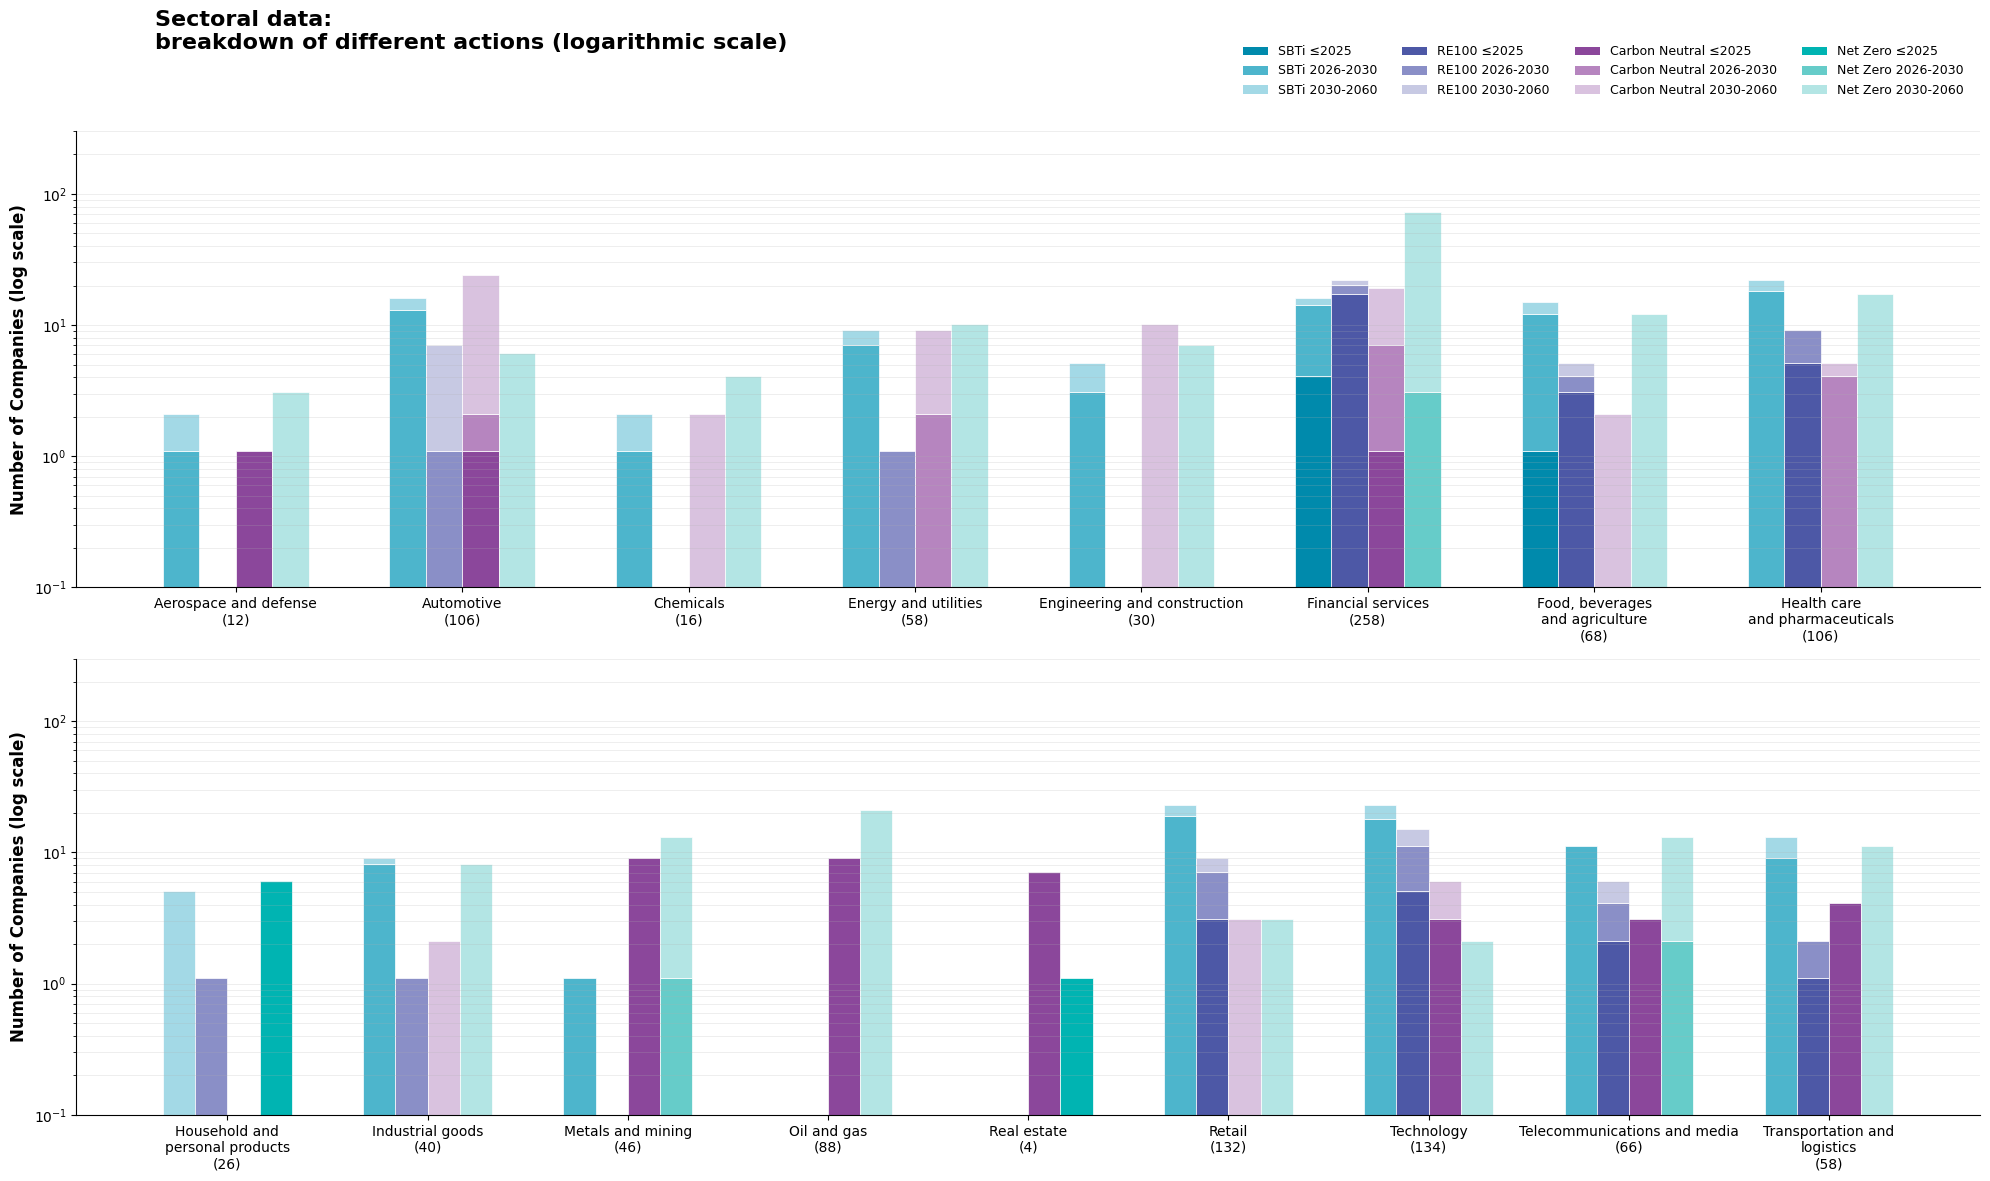


✓ Chart saved


In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch

# Create the correct dataframe (ALL sectors including Financial services)
sectors = ['Aerospace and defense', 'Automotive', 'Chemicals', 'Energy and utilities', 
           'Engineering and construction', 'Financial services', 'Food, beverages and agriculture',
           'Health care and pharmaceuticals', 'Household and personal products', 'Industrial goods',
           'Metals and mining', 'Oil and gas', 'Real estate', 'Retail', 'Technology',
           'Telecommunications and media', 'Transportation and logistics']

plot_data = pd.DataFrame({
    'Sector': sectors,
    'Count': [12, 106, 16, 58, 30, 258, 68, 106, 26, 40, 46, 88, 4, 132, 134, 66, 58],
    'SBTi_<=2025': [0, 0, 0, 0, 0, 4, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    'SBTi_2026-2030': [1, 13, 1, 7, 3, 10, 11, 18, 0, 8, 1, 0, 0, 19, 18, 11, 9],
    'SBTi_2030-2060': [1, 3, 1, 2, 2, 2, 3, 4, 5, 1, 0, 0, 0, 4, 5, 0, 4],
    'RE100_<=2025': [0, 0, 0, 0, 0, 17, 3, 5, 0, 0, 0, 0, 0, 3, 5, 2, 1],
    'RE100_2026-2030': [0, 1, 0, 1, 0, 3, 1, 4, 1, 1, 0, 0, 0, 4, 6, 2, 1],
    'RE100_2030-2060': [0, 6, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 2, 4, 2, 0],
    'CN_<=2025': [1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 9, 9, 7, 0, 3, 3, 4],
    'CN_2026-2030': [0, 1, 0, 2, 0, 6, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    'CN_2030-2060': [0, 22, 2, 7, 10, 12, 2, 1, 0, 2, 0, 0, 0, 3, 3, 0, 0],
    'NZ_<=2025': [0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 1, 0, 0, 0, 0],
    'NZ_2026-2030': [0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0],
    'NZ_2030-2060': [3, 6, 4, 10, 7, 69, 12, 17, 0, 8, 12, 21, 0, 3, 2, 11, 11]
})

# Create figure with two rows
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 12))

# Define colors
colors = {
    'SBTi_<=2025': '#008AAC',
    'SBTi_2026-2030': '#4DB5CC',
    'SBTi_2030-2060': '#A3D9E6',
    'RE100_<=2025': '#4D58A6',
    'RE100_2026-2030': '#8A8FC7',
    'RE100_2030-2060': '#C7C9E3',
    'CN_<=2025': '#8B479B',
    'CN_2026-2030': '#B685BF',
    'CN_2030-2060': '#D9C2DF',
    'NZ_<=2025': '#00B4B2',
    'NZ_2026-2030': '#66CCC9',
    'NZ_2030-2060': '#B3E5E4',
}

target_groups = {
    'SBTi': ['SBTi_<=2025', 'SBTi_2026-2030', 'SBTi_2030-2060'],
    'RE100': ['RE100_<=2025', 'RE100_2026-2030', 'RE100_2030-2060'],
    'CN': ['CN_<=2025', 'CN_2026-2030', 'CN_2030-2060'],
    'NZ': ['NZ_<=2025', 'NZ_2026-2030', 'NZ_2030-2060']
}

bar_width = 0.18
group_width = bar_width * 4 + 0.1

# First 8 sectors
sectors_top = plot_data.iloc[:8]
n_sectors_top = len(sectors_top)

x_positions_top = []
for i in range(n_sectors_top):
    sector_center = i * (group_width + 0.3)
    x_positions_top.append(sector_center)

for idx, (target_name, timeline_cols) in enumerate(target_groups.items()):
    x_offset = (idx - 1.5) * bar_width
    
    for i, sector_idx in enumerate(range(len(sectors_top))):
        x_pos = x_positions_top[i] + x_offset
        bottom = 0.1  # Start at 0.1 for log scale (can't start at 0)
        
        for col in timeline_cols:
            value = sectors_top.iloc[sector_idx][col]
            if value > 0:  # Only plot if value > 0
                ax1.bar(x_pos, value, bar_width, bottom=bottom, 
                       color=colors[col], edgecolor='white', linewidth=0.5)
                bottom += value

ax1.set_ylabel('Number of Companies (log scale)', fontsize=12, fontweight='bold')
ax1.set_yscale('log')
ax1.set_xticks(x_positions_top)
sector_labels_top = []
for _, row in sectors_top.iterrows():
    name = row['Sector']
    if len(name) > 25:
        words = name.split()
        if len(words) > 3:
            mid = len(words) // 2
            name = ' '.join(words[:mid]) + '\n' + ' '.join(words[mid:])
    sector_labels_top.append(f"{name}\n({int(row['Count'])})")
ax1.set_xticklabels(sector_labels_top, fontsize=10)
ax1.set_ylim(0.1, 300)
ax1.grid(axis='y', alpha=0.3, linestyle='-', linewidth=0.5, which='both')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Last 9 sectors
sectors_bottom = plot_data.iloc[8:]
n_sectors_bottom = len(sectors_bottom)

x_positions_bottom = []
for i in range(n_sectors_bottom):
    sector_center = i * (group_width + 0.3)
    x_positions_bottom.append(sector_center)

for idx, (target_name, timeline_cols) in enumerate(target_groups.items()):
    x_offset = (idx - 1.5) * bar_width
    
    for i, sector_idx in enumerate(range(len(sectors_bottom))):
        x_pos = x_positions_bottom[i] + x_offset
        bottom = 0.1
        
        for col in timeline_cols:
            value = sectors_bottom.iloc[sector_idx][col]
            if value > 0:
                ax2.bar(x_pos, value, bar_width, bottom=bottom, 
                       color=colors[col], edgecolor='white', linewidth=0.5)
                bottom += value

ax2.set_ylabel('Number of Companies (log scale)', fontsize=12, fontweight='bold')
ax2.set_yscale('log')
ax2.set_xticks(x_positions_bottom)
sector_labels_bottom = []
for _, row in sectors_bottom.iterrows():
    name = row['Sector']
    if name == 'Transportation and logistics':
        name = 'Transportation and\nlogistics'
    elif len(name) > 25:
        words = name.split()
        if len(words) > 3:
            mid = len(words) // 2
            name = ' '.join(words[:mid]) + '\n' + ' '.join(words[mid:])
    sector_labels_bottom.append(f"{name}\n({int(row['Count'])})")
ax2.set_xticklabels(sector_labels_bottom, fontsize=10)
ax2.set_ylim(0.1, 300)
ax2.grid(axis='y', alpha=0.3, linestyle='-', linewidth=0.5, which='both')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

fig.suptitle('Sectoral data:\nbreakdown of different actions (logarithmic scale)', 
             fontsize=16, fontweight='bold', x=0.08, ha='left', va='top')

legend_elements = [
    Patch(facecolor='#008AAC', label='SBTi ≤2025'),
    Patch(facecolor='#4DB5CC', label='SBTi 2026-2030'),
    Patch(facecolor='#A3D9E6', label='SBTi 2030-2060'),
    Patch(facecolor='#4D58A6', label='RE100 ≤2025'),
    Patch(facecolor='#8A8FC7', label='RE100 2026-2030'),
    Patch(facecolor='#C7C9E3', label='RE100 2030-2060'),
    Patch(facecolor='#8B479B', label='Carbon Neutral ≤2025'),
    Patch(facecolor='#B685BF', label='Carbon Neutral 2026-2030'),
    Patch(facecolor='#D9C2DF', label='Carbon Neutral 2030-2060'),
    Patch(facecolor='#00B4B2', label='Net Zero ≤2025'),
    Patch(facecolor='#66CCC9', label='Net Zero 2026-2030'),
    Patch(facecolor='#B3E5E4', label='Net Zero 2030-2060'),
]

fig.legend(handles=legend_elements, loc='upper right', ncol=4, 
          frameon=False, fontsize=9, bbox_to_anchor=(0.99, 0.96))

plt.tight_layout(rect=[0, 0, 1, 0.94])
plt.savefig('sectoral_breakdown_log.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("\n✓ Chart saved")

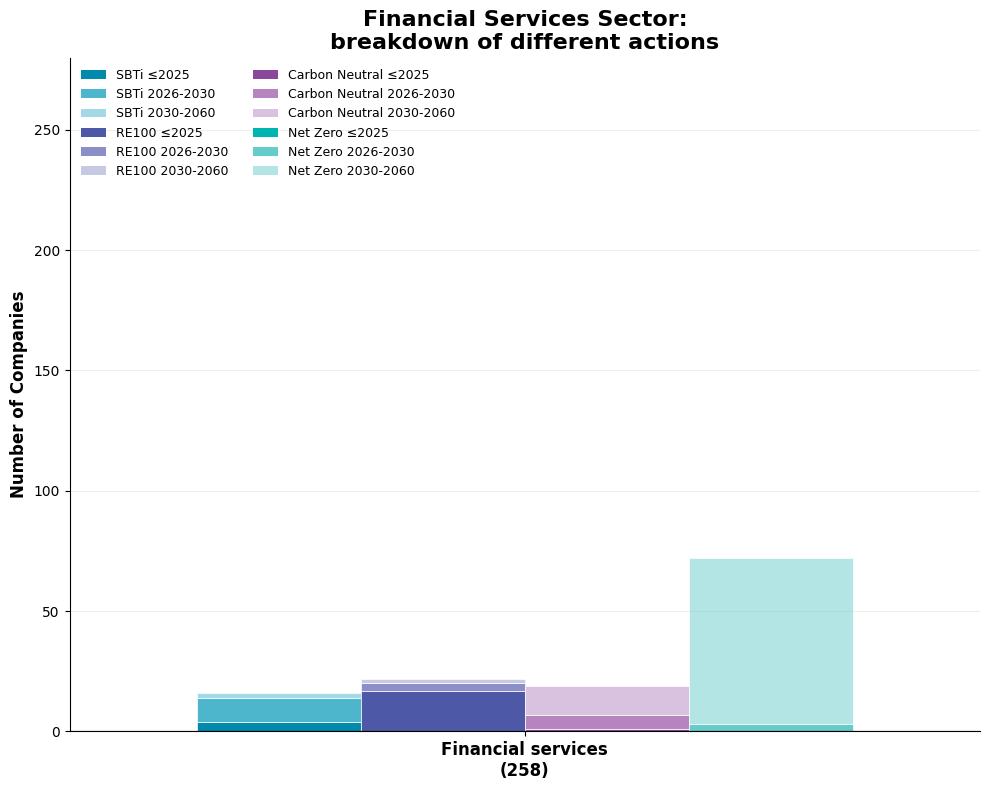

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Financial services data only
financial_data = {
    'SBTi_<=2025': 4,
    'SBTi_2026-2030': 10,
    'SBTi_2030-2060': 2,
    'RE100_<=2025': 17,
    'RE100_2026-2030': 3,
    'RE100_2030-2060': 2,
    'CN_<=2025': 1,
    'CN_2026-2030': 6,
    'CN_2030-2060': 12,
    'NZ_<=2025': 0,
    'NZ_2026-2030': 3,
    'NZ_2030-2060': 69
}

# Create figure
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# Define colors
colors = {
    'SBTi_<=2025': '#008AAC',
    'SBTi_2026-2030': '#4DB5CC',
    'SBTi_2030-2060': '#A3D9E6',
    'RE100_<=2025': '#4D58A6',
    'RE100_2026-2030': '#8A8FC7',
    'RE100_2030-2060': '#C7C9E3',
    'CN_<=2025': '#8B479B',
    'CN_2026-2030': '#B685BF',
    'CN_2030-2060': '#D9C2DF',
    'NZ_<=2025': '#00B4B2',
    'NZ_2026-2030': '#66CCC9',
    'NZ_2030-2060': '#B3E5E4',
}

target_groups = {
    'SBTi': ['SBTi_<=2025', 'SBTi_2026-2030', 'SBTi_2030-2060'],
    'RE100': ['RE100_<=2025', 'RE100_2026-2030', 'RE100_2030-2060'],
    'CN': ['CN_<=2025', 'CN_2026-2030', 'CN_2030-2060'],
    'NZ': ['NZ_<=2025', 'NZ_2026-2030', 'NZ_2030-2060']
}

bar_width = 0.18
x_center = 0

# Plot 4 bars
for idx, (target_name, timeline_cols) in enumerate(target_groups.items()):
    x_offset = (idx - 1.5) * bar_width
    x_pos = x_center + x_offset
    bottom = 0
    
    for col in timeline_cols:
        value = financial_data[col]
        ax.bar(x_pos, value, bar_width, bottom=bottom, 
               color=colors[col], edgecolor='white', linewidth=0.5)
        bottom += value

ax.set_ylabel('Number of Companies', fontsize=12, fontweight='bold')
ax.set_xticks([x_center])
ax.set_xticklabels(['Financial services\n(258)'], fontsize=12, fontweight='bold')
ax.set_ylim(0, 280)
ax.set_xlim(-0.5, 0.5)
ax.grid(axis='y', alpha=0.3, linestyle='-', linewidth=0.5)
ax.axhline(y=0, color='black', linewidth=0.8)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.title('Financial Services Sector:\nbreakdown of different actions', 
         fontsize=16, fontweight='bold')

legend_elements = [
    Patch(facecolor='#008AAC', label='SBTi ≤2025'),
    Patch(facecolor='#4DB5CC', label='SBTi 2026-2030'),
    Patch(facecolor='#A3D9E6', label='SBTi 2030-2060'),
    Patch(facecolor='#4D58A6', label='RE100 ≤2025'),
    Patch(facecolor='#8A8FC7', label='RE100 2026-2030'),
    Patch(facecolor='#C7C9E3', label='RE100 2030-2060'),
    Patch(facecolor='#8B479B', label='Carbon Neutral ≤2025'),
    Patch(facecolor='#B685BF', label='Carbon Neutral 2026-2030'),
    Patch(facecolor='#D9C2DF', label='Carbon Neutral 2030-2060'),
    Patch(facecolor='#00B4B2', label='Net Zero ≤2025'),
    Patch(facecolor='#66CCC9', label='Net Zero 2026-2030'),
    Patch(facecolor='#B3E5E4', label='Net Zero 2030-2060'),
]

plt.legend(handles=legend_elements, loc='upper left', ncol=2, 
          frameon=False, fontsize=9)

plt.tight_layout()
plt.savefig('financial_services_sector.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

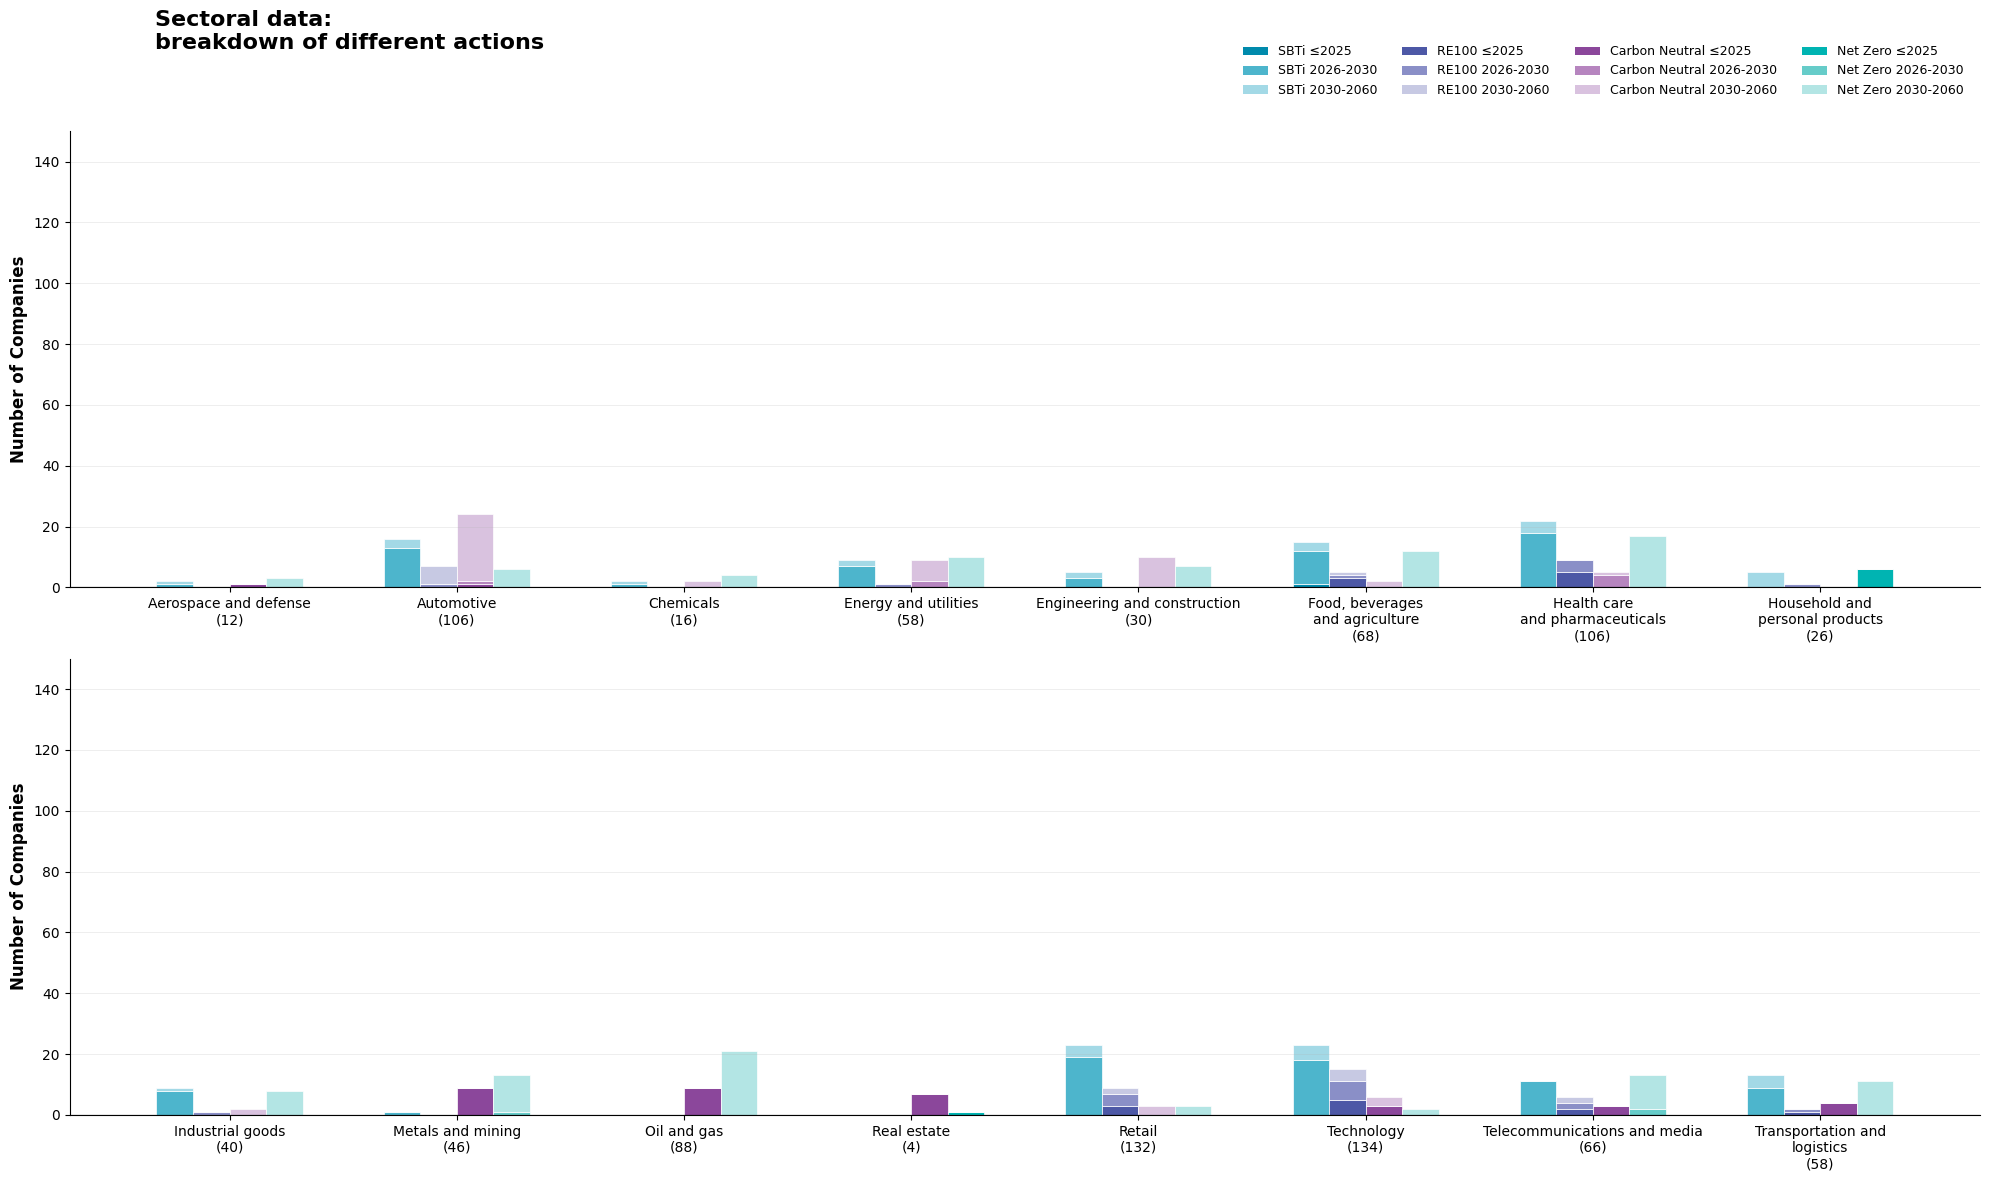

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch

# Create the correct dataframe (WITHOUT Financial services)
sectors = ['Aerospace and defense', 'Automotive', 'Chemicals', 'Energy and utilities', 
           'Engineering and construction', 'Food, beverages and agriculture',
           'Health care and pharmaceuticals', 'Household and personal products', 'Industrial goods',
           'Metals and mining', 'Oil and gas', 'Real estate', 'Retail', 'Technology',
           'Telecommunications and media', 'Transportation and logistics']

plot_data = pd.DataFrame({
    'Sector': sectors,
    'Count': [12, 106, 16, 58, 30, 68, 106, 26, 40, 46, 88, 4, 132, 134, 66, 58],
    'SBTi_<=2025': [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    'SBTi_2026-2030': [1, 13, 1, 7, 3, 11, 18, 0, 8, 1, 0, 0, 19, 18, 11, 9],
    'SBTi_2030-2060': [1, 3, 1, 2, 2, 3, 4, 5, 1, 0, 0, 0, 4, 5, 0, 4],
    'RE100_<=2025': [0, 0, 0, 0, 0, 3, 5, 0, 0, 0, 0, 0, 3, 5, 2, 1],
    'RE100_2026-2030': [0, 1, 0, 1, 0, 1, 4, 1, 1, 0, 0, 0, 4, 6, 2, 1],
    'RE100_2030-2060': [0, 6, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 4, 2, 0],
    'CN_<=2025': [1, 1, 0, 0, 0, 0, 0, 0, 0, 9, 9, 7, 0, 3, 3, 4],
    'CN_2026-2030': [0, 1, 0, 2, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    'CN_2030-2060': [0, 22, 2, 7, 10, 2, 1, 0, 2, 0, 0, 0, 3, 3, 0, 0],
    'NZ_<=2025': [0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 1, 0, 0, 0, 0],
    'NZ_2026-2030': [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0],
    'NZ_2030-2060': [3, 6, 4, 10, 7, 12, 17, 0, 8, 12, 21, 0, 3, 2, 11, 11]
})

# Create figure with two rows
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 12))

# Define colors
colors = {
    'SBTi_<=2025': '#008AAC',
    'SBTi_2026-2030': '#4DB5CC',
    'SBTi_2030-2060': '#A3D9E6',
    'RE100_<=2025': '#4D58A6',
    'RE100_2026-2030': '#8A8FC7',
    'RE100_2030-2060': '#C7C9E3',
    'CN_<=2025': '#8B479B',
    'CN_2026-2030': '#B685BF',
    'CN_2030-2060': '#D9C2DF',
    'NZ_<=2025': '#00B4B2',
    'NZ_2026-2030': '#66CCC9',
    'NZ_2030-2060': '#B3E5E4',
}

target_groups = {
    'SBTi': ['SBTi_<=2025', 'SBTi_2026-2030', 'SBTi_2030-2060'],
    'RE100': ['RE100_<=2025', 'RE100_2026-2030', 'RE100_2030-2060'],
    'CN': ['CN_<=2025', 'CN_2026-2030', 'CN_2030-2060'],
    'NZ': ['NZ_<=2025', 'NZ_2026-2030', 'NZ_2030-2060']
}

bar_width = 0.18
group_width = bar_width * 4 + 0.1

# First 8 sectors
sectors_top = plot_data.iloc[:8]
n_sectors_top = len(sectors_top)

x_positions_top = []
for i in range(n_sectors_top):
    sector_center = i * (group_width + 0.3)
    x_positions_top.append(sector_center)

for idx, (target_name, timeline_cols) in enumerate(target_groups.items()):
    x_offset = (idx - 1.5) * bar_width
    
    for i, sector_idx in enumerate(range(len(sectors_top))):
        x_pos = x_positions_top[i] + x_offset
        bottom = 0
        
        for col in timeline_cols:
            value = sectors_top.iloc[sector_idx][col]
            ax1.bar(x_pos, value, bar_width, bottom=bottom, 
                   color=colors[col], edgecolor='white', linewidth=0.5)
            bottom += value

ax1.set_ylabel('Number of Companies', fontsize=12, fontweight='bold')
ax1.set_xticks(x_positions_top)
sector_labels_top = []
for _, row in sectors_top.iterrows():
    name = row['Sector']
    if len(name) > 25:
        words = name.split()
        if len(words) > 3:
            mid = len(words) // 2
            name = ' '.join(words[:mid]) + '\n' + ' '.join(words[mid:])
    sector_labels_top.append(f"{name}\n({int(row['Count'])})")
ax1.set_xticklabels(sector_labels_top, fontsize=10)
ax1.set_ylim(0, 150)
ax1.grid(axis='y', alpha=0.3, linestyle='-', linewidth=0.5)
ax1.axhline(y=0, color='black', linewidth=0.8)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Last 8 sectors
sectors_bottom = plot_data.iloc[8:]
n_sectors_bottom = len(sectors_bottom)

x_positions_bottom = []
for i in range(n_sectors_bottom):
    sector_center = i * (group_width + 0.3)
    x_positions_bottom.append(sector_center)

for idx, (target_name, timeline_cols) in enumerate(target_groups.items()):
    x_offset = (idx - 1.5) * bar_width
    
    for i, sector_idx in enumerate(range(len(sectors_bottom))):
        x_pos = x_positions_bottom[i] + x_offset
        bottom = 0
        
        for col in timeline_cols:
            value = sectors_bottom.iloc[sector_idx][col]
            ax2.bar(x_pos, value, bar_width, bottom=bottom, 
                   color=colors[col], edgecolor='white', linewidth=0.5)
            bottom += value

ax2.set_ylabel('Number of Companies', fontsize=12, fontweight='bold')
ax2.set_xticks(x_positions_bottom)
sector_labels_bottom = []
for _, row in sectors_bottom.iterrows():
    name = row['Sector']
    if name == 'Transportation and logistics':
        name = 'Transportation and\nlogistics'
    elif len(name) > 25:
        words = name.split()
        if len(words) > 3:
            mid = len(words) // 2
            name = ' '.join(words[:mid]) + '\n' + ' '.join(words[mid:])
    sector_labels_bottom.append(f"{name}\n({int(row['Count'])})")
ax2.set_xticklabels(sector_labels_bottom, fontsize=10)
ax2.set_ylim(0, 150)
ax2.grid(axis='y', alpha=0.3, linestyle='-', linewidth=0.5)
ax2.axhline(y=0, color='black', linewidth=0.8)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

fig.suptitle('Sectoral data:\nbreakdown of different actions', 
             fontsize=16, fontweight='bold', x=0.08, ha='left', va='top')

legend_elements = [
    Patch(facecolor='#008AAC', label='SBTi ≤2025'),
    Patch(facecolor='#4DB5CC', label='SBTi 2026-2030'),
    Patch(facecolor='#A3D9E6', label='SBTi 2030-2060'),
    Patch(facecolor='#4D58A6', label='RE100 ≤2025'),
    Patch(facecolor='#8A8FC7', label='RE100 2026-2030'),
    Patch(facecolor='#C7C9E3', label='RE100 2030-2060'),
    Patch(facecolor='#8B479B', label='Carbon Neutral ≤2025'),
    Patch(facecolor='#B685BF', label='Carbon Neutral 2026-2030'),
    Patch(facecolor='#D9C2DF', label='Carbon Neutral 2030-2060'),
    Patch(facecolor='#00B4B2', label='Net Zero ≤2025'),
    Patch(facecolor='#66CCC9', label='Net Zero 2026-2030'),
    Patch(facecolor='#B3E5E4', label='Net Zero 2030-2060'),
]

fig.legend(handles=legend_elements, loc='upper right', ncol=4, 
          frameon=False, fontsize=9, bbox_to_anchor=(0.99, 0.96))

plt.tight_layout(rect=[0, 0, 1, 0.94])
plt.savefig('sectoral_breakdown_no_financial.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

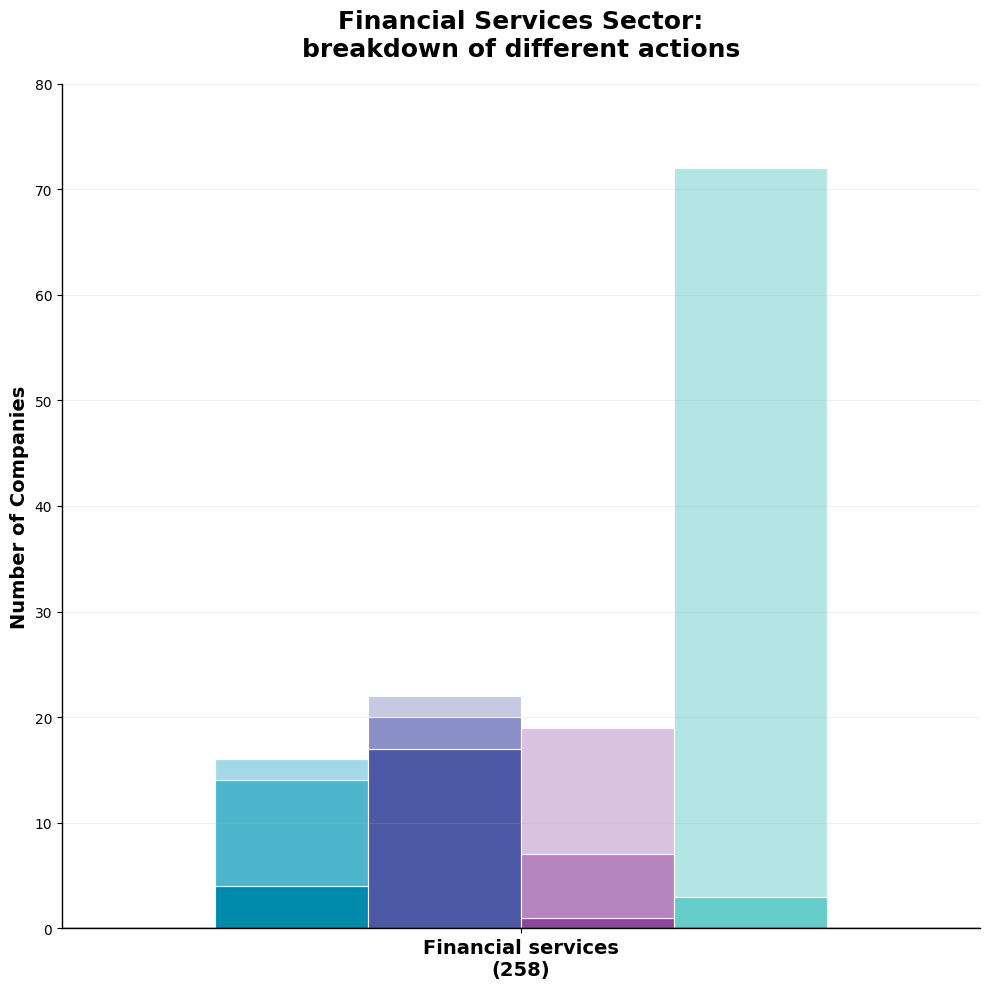

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

financial_data = {
    'SBTi_<=2025': 4,
    'SBTi_2026-2030': 10,
    'SBTi_2030-2060': 2,
    'RE100_<=2025': 17,
    'RE100_2026-2030': 3,
    'RE100_2030-2060': 2,
    'CN_<=2025': 1,
    'CN_2026-2030': 6,
    'CN_2030-2060': 12,
    'NZ_<=2025': 0,
    'NZ_2026-2030': 3,
    'NZ_2030-2060': 69
}

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

colors = {
    'SBTi_<=2025': '#008AAC',
    'SBTi_2026-2030': '#4DB5CC',
    'SBTi_2030-2060': '#A3D9E6',
    'RE100_<=2025': '#4D58A6',
    'RE100_2026-2030': '#8A8FC7',
    'RE100_2030-2060': '#C7C9E3',
    'CN_<=2025': '#8B479B',
    'CN_2026-2030': '#B685BF',
    'CN_2030-2060': '#D9C2DF',
    'NZ_<=2025': '#00B4B2',
    'NZ_2026-2030': '#66CCC9',
    'NZ_2030-2060': '#B3E5E4',
}

target_groups = {
    'SBTi': ['SBTi_<=2025', 'SBTi_2026-2030', 'SBTi_2030-2060'],
    'RE100': ['RE100_<=2025', 'RE100_2026-2030', 'RE100_2030-2060'],
    'CN': ['CN_<=2025', 'CN_2026-2030', 'CN_2030-2060'],
    'NZ': ['NZ_<=2025', 'NZ_2026-2030', 'NZ_2030-2060']
}

bar_width = 0.2
x_center = 0

# Plot 4 bars VERTICALLY
for idx, (target_name, timeline_cols) in enumerate(target_groups.items()):
    x_offset = (idx - 1.5) * bar_width
    x_pos = x_center + x_offset
    bottom = 0
    
    for col in timeline_cols:
        value = financial_data[col]
        ax.bar(x_pos, value, bar_width, bottom=bottom, 
               color=colors[col], edgecolor='white', linewidth=0.8)
        bottom += value

ax.set_ylabel('Number of Companies', fontsize=14, fontweight='bold')
ax.set_xticks([x_center])
ax.set_xticklabels(['Financial services\n(258)'], fontsize=14, fontweight='bold')
ax.set_ylim(0, 80)
ax.set_xlim(-0.6, 0.6)
ax.grid(axis='y', alpha=0.3, linestyle='-', linewidth=0.5)
ax.axhline(y=0, color='black', linewidth=1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1)
ax.spines['bottom'].set_linewidth(1)

plt.title('Financial Services Sector:\nbreakdown of different actions', 
         fontsize=18, fontweight='bold', pad=20)


plt.tight_layout()
plt.savefig('financial_services_fixed.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

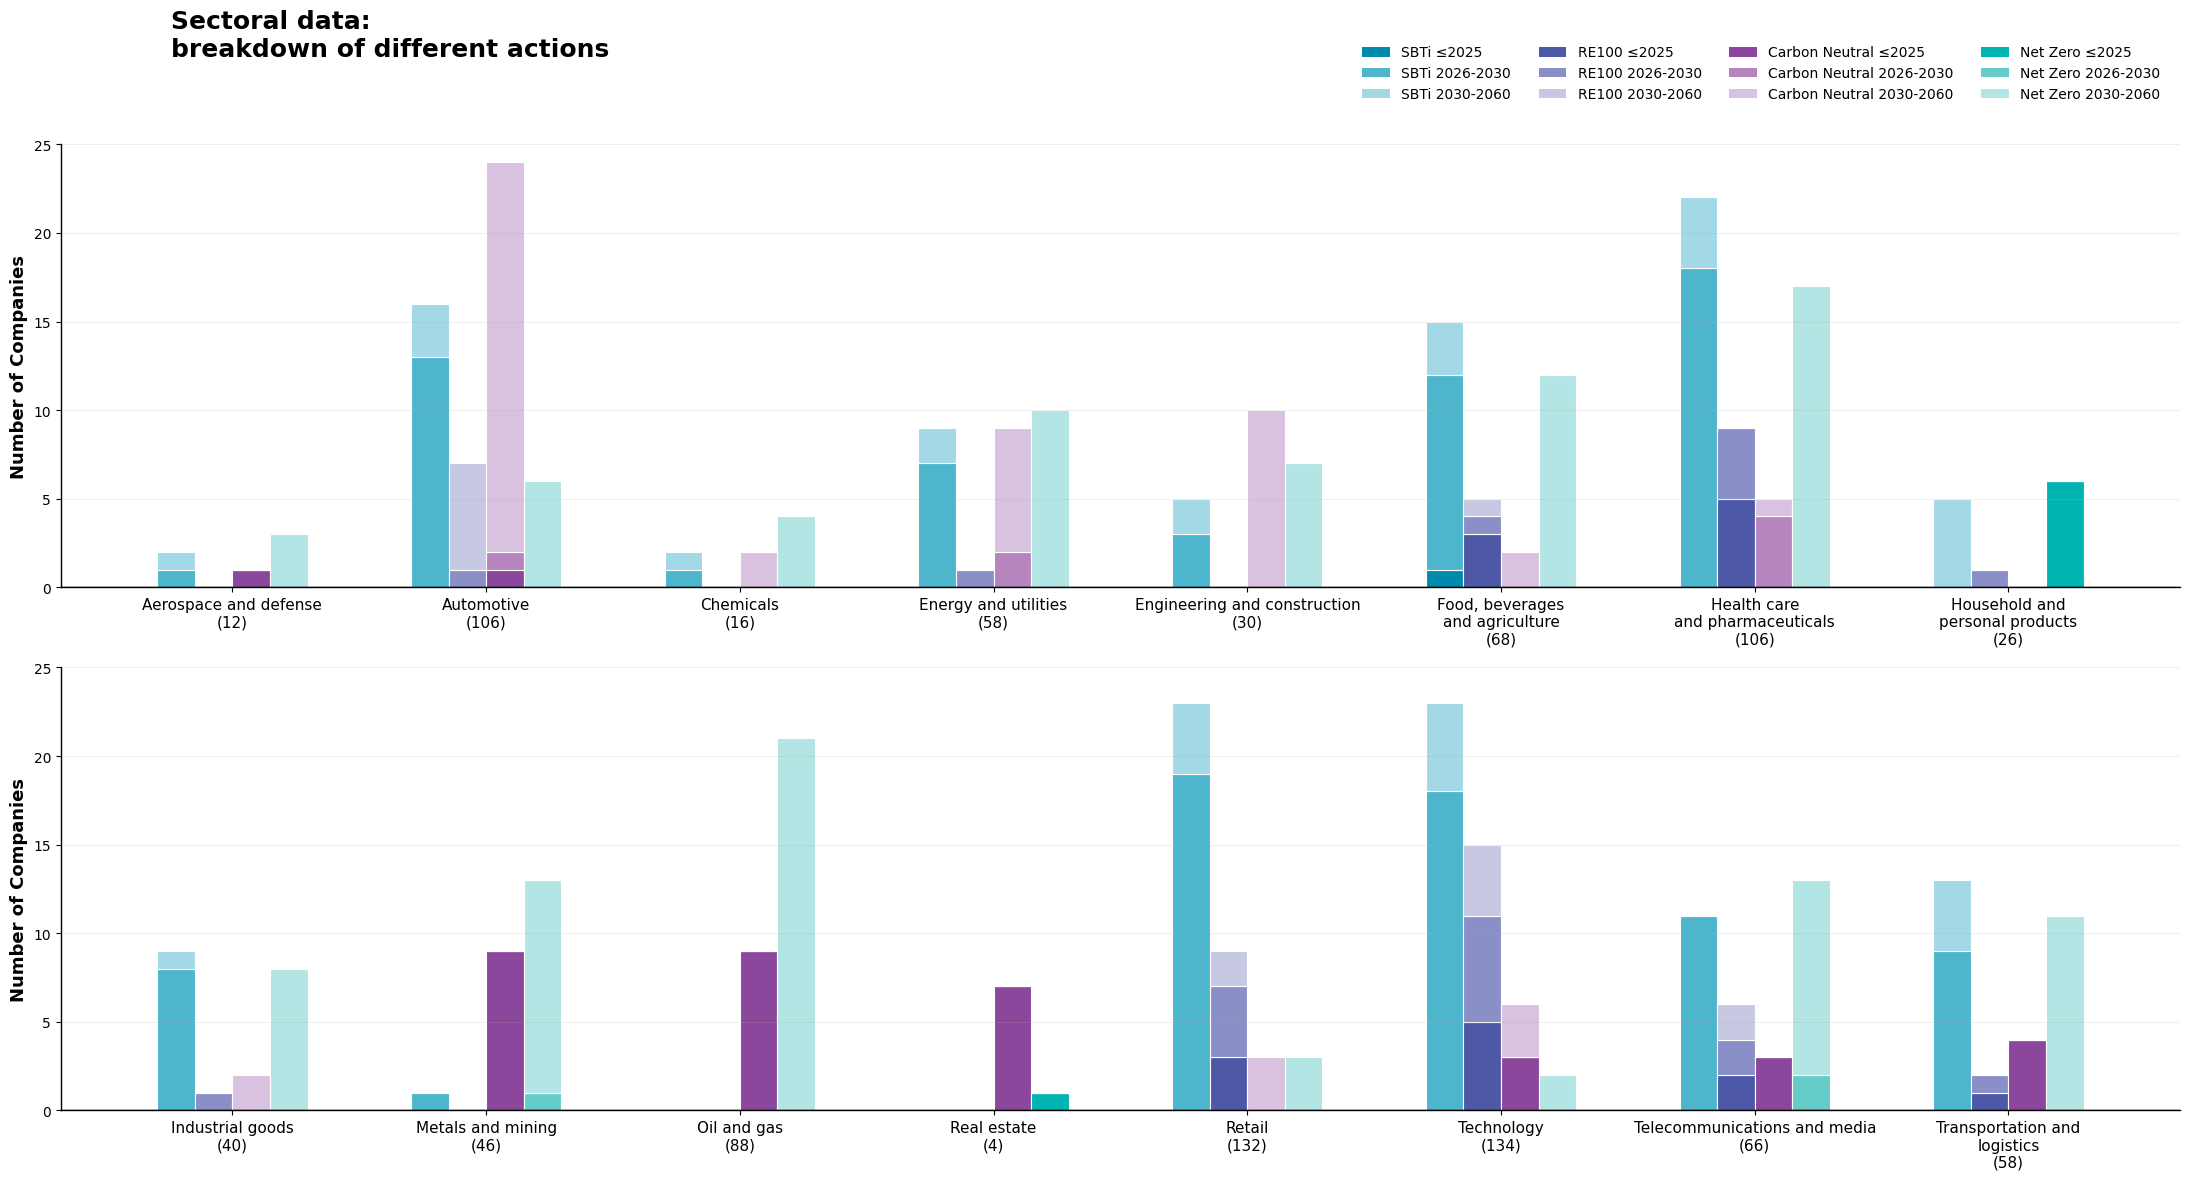

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch

sectors = ['Aerospace and defense', 'Automotive', 'Chemicals', 'Energy and utilities', 
           'Engineering and construction', 'Food, beverages and agriculture',
           'Health care and pharmaceuticals', 'Household and personal products', 'Industrial goods',
           'Metals and mining', 'Oil and gas', 'Real estate', 'Retail', 'Technology',
           'Telecommunications and media', 'Transportation and logistics']

plot_data = pd.DataFrame({
    'Sector': sectors,
    'Count': [12, 106, 16, 58, 30, 68, 106, 26, 40, 46, 88, 4, 132, 134, 66, 58],
    'SBTi_<=2025': [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    'SBTi_2026-2030': [1, 13, 1, 7, 3, 11, 18, 0, 8, 1, 0, 0, 19, 18, 11, 9],
    'SBTi_2030-2060': [1, 3, 1, 2, 2, 3, 4, 5, 1, 0, 0, 0, 4, 5, 0, 4],
    'RE100_<=2025': [0, 0, 0, 0, 0, 3, 5, 0, 0, 0, 0, 0, 3, 5, 2, 1],
    'RE100_2026-2030': [0, 1, 0, 1, 0, 1, 4, 1, 1, 0, 0, 0, 4, 6, 2, 1],
    'RE100_2030-2060': [0, 6, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 4, 2, 0],
    'CN_<=2025': [1, 1, 0, 0, 0, 0, 0, 0, 0, 9, 9, 7, 0, 3, 3, 4],
    'CN_2026-2030': [0, 1, 0, 2, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    'CN_2030-2060': [0, 22, 2, 7, 10, 2, 1, 0, 2, 0, 0, 0, 3, 3, 0, 0],
    'NZ_<=2025': [0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 1, 0, 0, 0, 0],
    'NZ_2026-2030': [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0],
    'NZ_2030-2060': [3, 6, 4, 10, 7, 12, 17, 0, 8, 12, 21, 0, 3, 2, 11, 11]
})

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(22, 12))

colors = {
    'SBTi_<=2025': '#008AAC',
    'SBTi_2026-2030': '#4DB5CC',
    'SBTi_2030-2060': '#A3D9E6',
    'RE100_<=2025': '#4D58A6',
    'RE100_2026-2030': '#8A8FC7',
    'RE100_2030-2060': '#C7C9E3',
    'CN_<=2025': '#8B479B',
    'CN_2026-2030': '#B685BF',
    'CN_2030-2060': '#D9C2DF',
    'NZ_<=2025': '#00B4B2',
    'NZ_2026-2030': '#66CCC9',
    'NZ_2030-2060': '#B3E5E4',
}

target_groups = {
    'SBTi': ['SBTi_<=2025', 'SBTi_2026-2030', 'SBTi_2030-2060'],
    'RE100': ['RE100_<=2025', 'RE100_2026-2030', 'RE100_2030-2060'],
    'CN': ['CN_<=2025', 'CN_2026-2030', 'CN_2030-2060'],
    'NZ': ['NZ_<=2025', 'NZ_2026-2030', 'NZ_2030-2060']
}

bar_width = 0.2
group_width = bar_width * 4 + 0.15

# First 8 sectors
sectors_top = plot_data.iloc[:8]
n_sectors_top = len(sectors_top)

x_positions_top = []
for i in range(n_sectors_top):
    sector_center = i * (group_width + 0.4)
    x_positions_top.append(sector_center)

for idx, (target_name, timeline_cols) in enumerate(target_groups.items()):
    x_offset = (idx - 1.5) * bar_width
    
    for i, sector_idx in enumerate(range(len(sectors_top))):
        x_pos = x_positions_top[i] + x_offset
        bottom = 0
        
        for col in timeline_cols:
            value = sectors_top.iloc[sector_idx][col]
            ax1.bar(x_pos, value, bar_width, bottom=bottom, 
                   color=colors[col], edgecolor='white', linewidth=0.8)
            bottom += value

ax1.set_ylabel('Number of Companies', fontsize=13, fontweight='bold')
ax1.set_xticks(x_positions_top)
sector_labels_top = []
for _, row in sectors_top.iterrows():
    name = row['Sector']
    if len(name) > 25:
        words = name.split()
        if len(words) > 3:
            mid = len(words) // 2
            name = ' '.join(words[:mid]) + '\n' + ' '.join(words[mid:])
    sector_labels_top.append(f"{name}\n({int(row['Count'])})")
ax1.set_xticklabels(sector_labels_top, fontsize=11)
ax1.set_ylim(0, 25)
ax1.grid(axis='y', alpha=0.3, linestyle='-', linewidth=0.5)
ax1.axhline(y=0, color='black', linewidth=1)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_linewidth(1)
ax1.spines['bottom'].set_linewidth(1)

# Last 8 sectors
sectors_bottom = plot_data.iloc[8:]
n_sectors_bottom = len(sectors_bottom)

x_positions_bottom = []
for i in range(n_sectors_bottom):
    sector_center = i * (group_width + 0.4)
    x_positions_bottom.append(sector_center)

for idx, (target_name, timeline_cols) in enumerate(target_groups.items()):
    x_offset = (idx - 1.5) * bar_width
    
    for i, sector_idx in enumerate(range(len(sectors_bottom))):
        x_pos = x_positions_bottom[i] + x_offset
        bottom = 0
        
        for col in timeline_cols:
            value = sectors_bottom.iloc[sector_idx][col]
            ax2.bar(x_pos, value, bar_width, bottom=bottom, 
                   color=colors[col], edgecolor='white', linewidth=0.8)
            bottom += value

ax2.set_ylabel('Number of Companies', fontsize=13, fontweight='bold')
ax2.set_xticks(x_positions_bottom)
sector_labels_bottom = []
for _, row in sectors_bottom.iterrows():
    name = row['Sector']
    if name == 'Transportation and logistics':
        name = 'Transportation and\nlogistics'
    elif len(name) > 25:
        words = name.split()
        if len(words) > 3:
            mid = len(words) // 2
            name = ' '.join(words[:mid]) + '\n' + ' '.join(words[mid:])
    sector_labels_bottom.append(f"{name}\n({int(row['Count'])})")
ax2.set_xticklabels(sector_labels_bottom, fontsize=11)
ax2.set_ylim(0, 25)
ax2.grid(axis='y', alpha=0.3, linestyle='-', linewidth=0.5)
ax2.axhline(y=0, color='black', linewidth=1)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_linewidth(1)
ax2.spines['bottom'].set_linewidth(1)

fig.suptitle('Sectoral data:\nbreakdown of different actions', 
             fontsize=18, fontweight='bold', x=0.08, ha='left', va='top')

legend_elements = [
    Patch(facecolor='#008AAC', label='SBTi ≤2025'),
    Patch(facecolor='#4DB5CC', label='SBTi 2026-2030'),
    Patch(facecolor='#A3D9E6', label='SBTi 2030-2060'),
    Patch(facecolor='#4D58A6', label='RE100 ≤2025'),
    Patch(facecolor='#8A8FC7', label='RE100 2026-2030'),
    Patch(facecolor='#C7C9E3', label='RE100 2030-2060'),
    Patch(facecolor='#8B479B', label='Carbon Neutral ≤2025'),
    Patch(facecolor='#B685BF', label='Carbon Neutral 2026-2030'),
    Patch(facecolor='#D9C2DF', label='Carbon Neutral 2030-2060'),
    Patch(facecolor='#00B4B2', label='Net Zero ≤2025'),
    Patch(facecolor='#66CCC9', label='Net Zero 2026-2030'),
    Patch(facecolor='#B3E5E4', label='Net Zero 2030-2060'),
]

fig.legend(handles=legend_elements, loc='upper right', ncol=4, 
          frameon=False, fontsize=10, bbox_to_anchor=(0.99, 0.96))

plt.tight_layout(rect=[0, 0, 1, 0.94])
plt.savefig('sectoral_breakdown_fixed.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

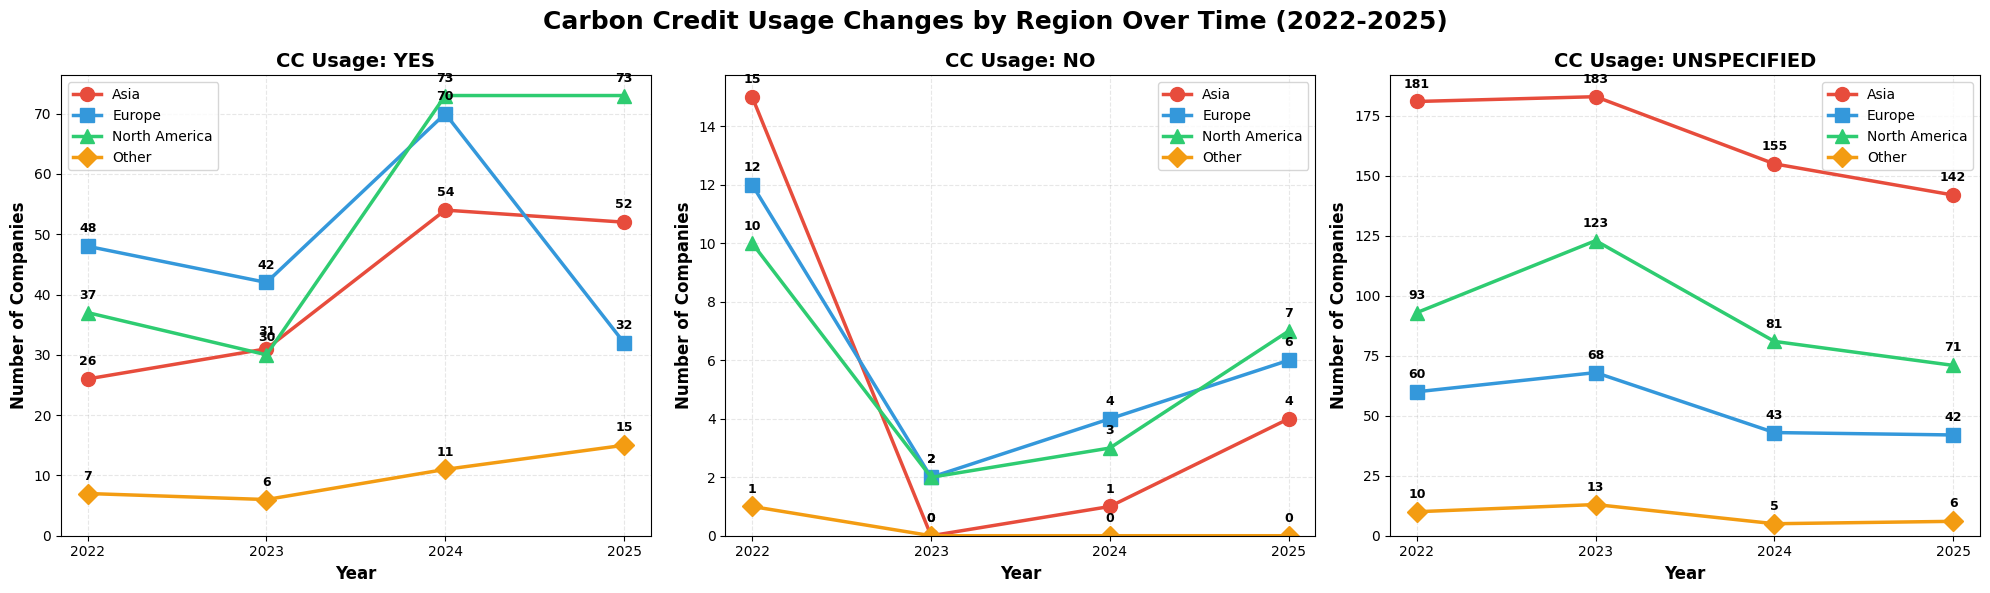

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# Data organized by year and region (from the image)
years = [2022, 2023, 2024, 2025]

# Yes usage
yes_asia = [26, 31, 54, 52]
yes_europe = [48, 42, 70, 32]
yes_na = [37, 30, 73, 73]
yes_other = [7, 6, 11, 15]

# No usage
no_asia = [15, 0, 1, 4]
no_europe = [12, 2, 4, 6]
no_na = [10, 2, 3, 7]
no_other = [1, 0, 0, 0]

# Unspecified
unspec_asia = [181, 183, 155, 142]
unspec_europe = [60, 68, 43, 42]
unspec_na = [93, 123, 81, 71]
unspec_other = [10, 13, 5, 6]

# Create figure with 3 subplots (one per CC usage type)
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Carbon Credit Usage Changes by Region Over Time (2022-2025)', 
             fontsize=18, fontweight='bold')

# Colors for regions
color_asia = '#E74C3C'  # Red
color_europe = '#3498DB'  # Blue
color_na = '#2ECC71'  # Green
color_other = '#F39C12'  # Orange

# Plot 1: Yes
ax1 = axes[0]
ax1.plot(years, yes_asia, marker='o', linewidth=2.5, markersize=10, 
         label='Asia', color=color_asia)
ax1.plot(years, yes_europe, marker='s', linewidth=2.5, markersize=10, 
         label='Europe', color=color_europe)
ax1.plot(years, yes_na, marker='^', linewidth=2.5, markersize=10, 
         label='North America', color=color_na)
ax1.plot(years, yes_other, marker='D', linewidth=2.5, markersize=10, 
         label='Other', color=color_other)

# Add value labels for Yes
for data, color in [(yes_asia, color_asia), (yes_europe, color_europe), 
                     (yes_na, color_na), (yes_other, color_other)]:
    for i, val in enumerate(data):
        ax1.annotate(str(val), (years[i], val), textcoords="offset points", 
                    xytext=(0, 10), ha='center', fontsize=9, fontweight='bold')

ax1.set_xlabel('Year', fontsize=12, fontweight='bold')
ax1.set_ylabel('Number of Companies', fontsize=12, fontweight='bold')
ax1.set_title('CC Usage: YES', fontsize=14, fontweight='bold')
ax1.legend(loc='best', fontsize=10)
ax1.grid(True, alpha=0.3, linestyle='--')
ax1.set_xticks(years)
ax1.set_ylim(bottom=0)

# Plot 2: No
ax2 = axes[1]
ax2.plot(years, no_asia, marker='o', linewidth=2.5, markersize=10, 
         label='Asia', color=color_asia)
ax2.plot(years, no_europe, marker='s', linewidth=2.5, markersize=10, 
         label='Europe', color=color_europe)
ax2.plot(years, no_na, marker='^', linewidth=2.5, markersize=10, 
         label='North America', color=color_na)
ax2.plot(years, no_other, marker='D', linewidth=2.5, markersize=10, 
         label='Other', color=color_other)

# Add value labels for No
for data, color in [(no_asia, color_asia), (no_europe, color_europe), 
                     (no_na, color_na), (no_other, color_other)]:
    for i, val in enumerate(data):
        ax2.annotate(str(val), (years[i], val), textcoords="offset points", 
                    xytext=(0, 10), ha='center', fontsize=9, fontweight='bold')

ax2.set_xlabel('Year', fontsize=12, fontweight='bold')
ax2.set_ylabel('Number of Companies', fontsize=12, fontweight='bold')
ax2.set_title('CC Usage: NO', fontsize=14, fontweight='bold')
ax2.legend(loc='best', fontsize=10)
ax2.grid(True, alpha=0.3, linestyle='--')
ax2.set_xticks(years)
ax2.set_ylim(bottom=0)

# Plot 3: Unspecified
ax3 = axes[2]
ax3.plot(years, unspec_asia, marker='o', linewidth=2.5, markersize=10, 
         label='Asia', color=color_asia)
ax3.plot(years, unspec_europe, marker='s', linewidth=2.5, markersize=10, 
         label='Europe', color=color_europe)
ax3.plot(years, unspec_na, marker='^', linewidth=2.5, markersize=10, 
         label='North America', color=color_na)
ax3.plot(years, unspec_other, marker='D', linewidth=2.5, markersize=10, 
         label='Other', color=color_other)

# Add value labels for Unspecified
for data, color in [(unspec_asia, color_asia), (unspec_europe, color_europe), 
                     (unspec_na, color_na), (unspec_other, color_other)]:
    for i, val in enumerate(data):
        ax3.annotate(str(val), (years[i], val), textcoords="offset points", 
                    xytext=(0, 10), ha='center', fontsize=9, fontweight='bold')

ax3.set_xlabel('Year', fontsize=12, fontweight='bold')
ax3.set_ylabel('Number of Companies', fontsize=12, fontweight='bold')
ax3.set_title('CC Usage: UNSPECIFIED', fontsize=14, fontweight='bold')
ax3.legend(loc='best', fontsize=10)
ax3.grid(True, alpha=0.3, linestyle='--')
ax3.set_xticks(years)
ax3.set_ylim(bottom=0)

plt.tight_layout()
plt.savefig('cc_usage_by_type_regions_corrected.png', dpi=300, bbox_inches='tight')
plt.show()

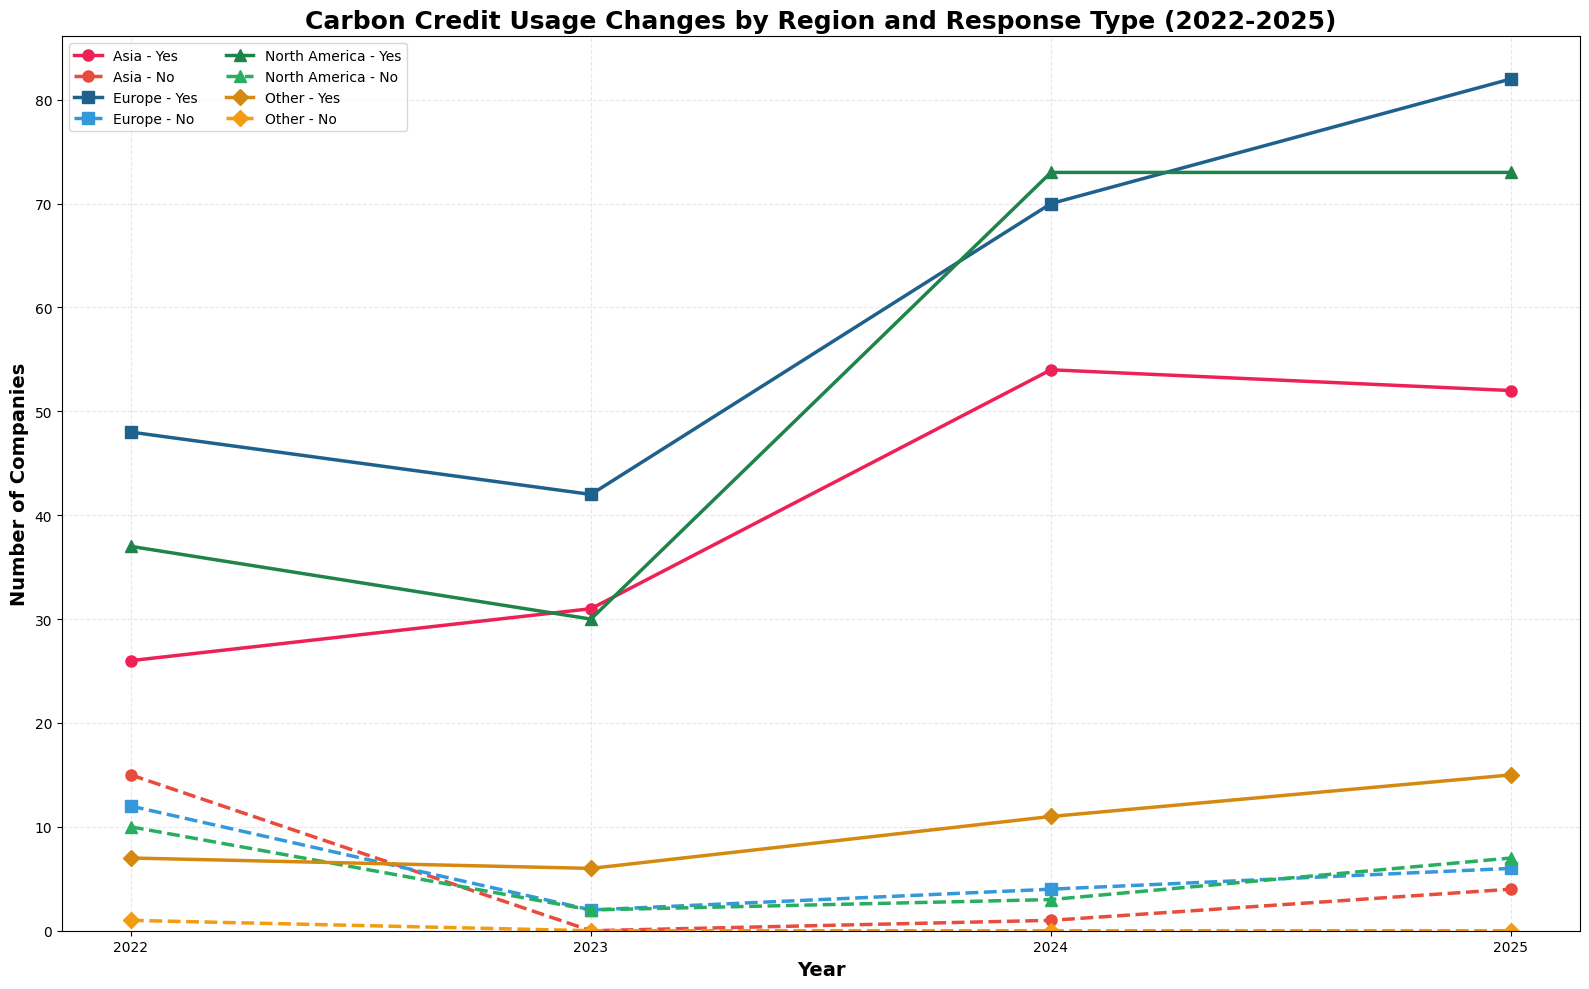

In [34]:
import matplotlib.pyplot as plt
import numpy as np

# Data organized by year and region (from the image)
years = [2022, 2023, 2024, 2025]

# Yes usage
yes_asia = [26, 31, 54, 52]
yes_europe = [48, 42, 70, 82]
yes_na = [37, 30, 73, 73]
yes_other = [7, 6, 11, 15]

# No usage
no_asia = [15, 0, 1, 4]
no_europe = [12, 2, 4, 6]
no_na = [10, 2, 3, 7]
no_other = [1, 0, 0, 0]

# Unspecified
unspec_asia = [181, 183, 155, 142]
unspec_europe = [60, 68, 43, 42]
unspec_na = [93, 123, 81, 71]
unspec_other = [10, 13, 5, 6]

# Create single plot with all combinations
fig, ax = plt.subplots(figsize=(16, 10))
plt.title('Carbon Credit Usage Changes by Region and Response Type (2022-2025)', 
          fontsize=18, fontweight='bold')

# Define colors - different shades for each region
# Asia - Reds
color_asia_yes = "#EE2157"
color_asia_no = '#E74C3C'
color_asia_unspec = '#EC7063'

# Europe - Blues
color_europe_yes = '#1F618D'
color_europe_no = '#3498DB'
color_europe_unspec = '#5DADE2'

# North America - Greens
color_na_yes = '#1E8449'
color_na_no = '#27AE60'
color_na_unspec = '#52BE80'

# Other - Oranges/Yellows
color_other_yes = '#D68910'
color_other_no = '#F39C12'
color_other_unspec = '#F8C471'

# Plot all lines
# Asia
ax.plot(years, yes_asia, marker='o', linewidth=2.5, markersize=8, 
        label='Asia - Yes', color=color_asia_yes, linestyle='-')
ax.plot(years, no_asia, marker='o', linewidth=2.5, markersize=8, 
        label='Asia - No', color=color_asia_no, linestyle='--')


# Europe
ax.plot(years, yes_europe, marker='s', linewidth=2.5, markersize=8, 
        label='Europe - Yes', color=color_europe_yes, linestyle='-')
ax.plot(years, no_europe, marker='s', linewidth=2.5, markersize=8, 
        label='Europe - No', color=color_europe_no, linestyle='--')


# North America
ax.plot(years, yes_na, marker='^', linewidth=2.5, markersize=8, 
        label='North America - Yes', color=color_na_yes, linestyle='-')
ax.plot(years, no_na, marker='^', linewidth=2.5, markersize=8, 
        label='North America - No', color=color_na_no, linestyle='--')

# Other
ax.plot(years, yes_other, marker='D', linewidth=2.5, markersize=8, 
        label='Other - Yes', color=color_other_yes, linestyle='-')
ax.plot(years, no_other, marker='D', linewidth=2.5, markersize=8, 
        label='Other - No', color=color_other_no, linestyle='--')


# Formatting
ax.set_xlabel('Year', fontsize=14, fontweight='bold')
ax.set_ylabel('Number of Companies', fontsize=14, fontweight='bold')
ax.legend(loc='upper left', fontsize=10, ncol=2)
ax.grid(True, alpha=0.3, linestyle='--')
ax.set_xticks(years)
ax.set_ylim(bottom=0)

plt.tight_layout()
plt.savefig('cc_usage_all_combinations.png', dpi=300, bbox_inches='tight')
plt.show()

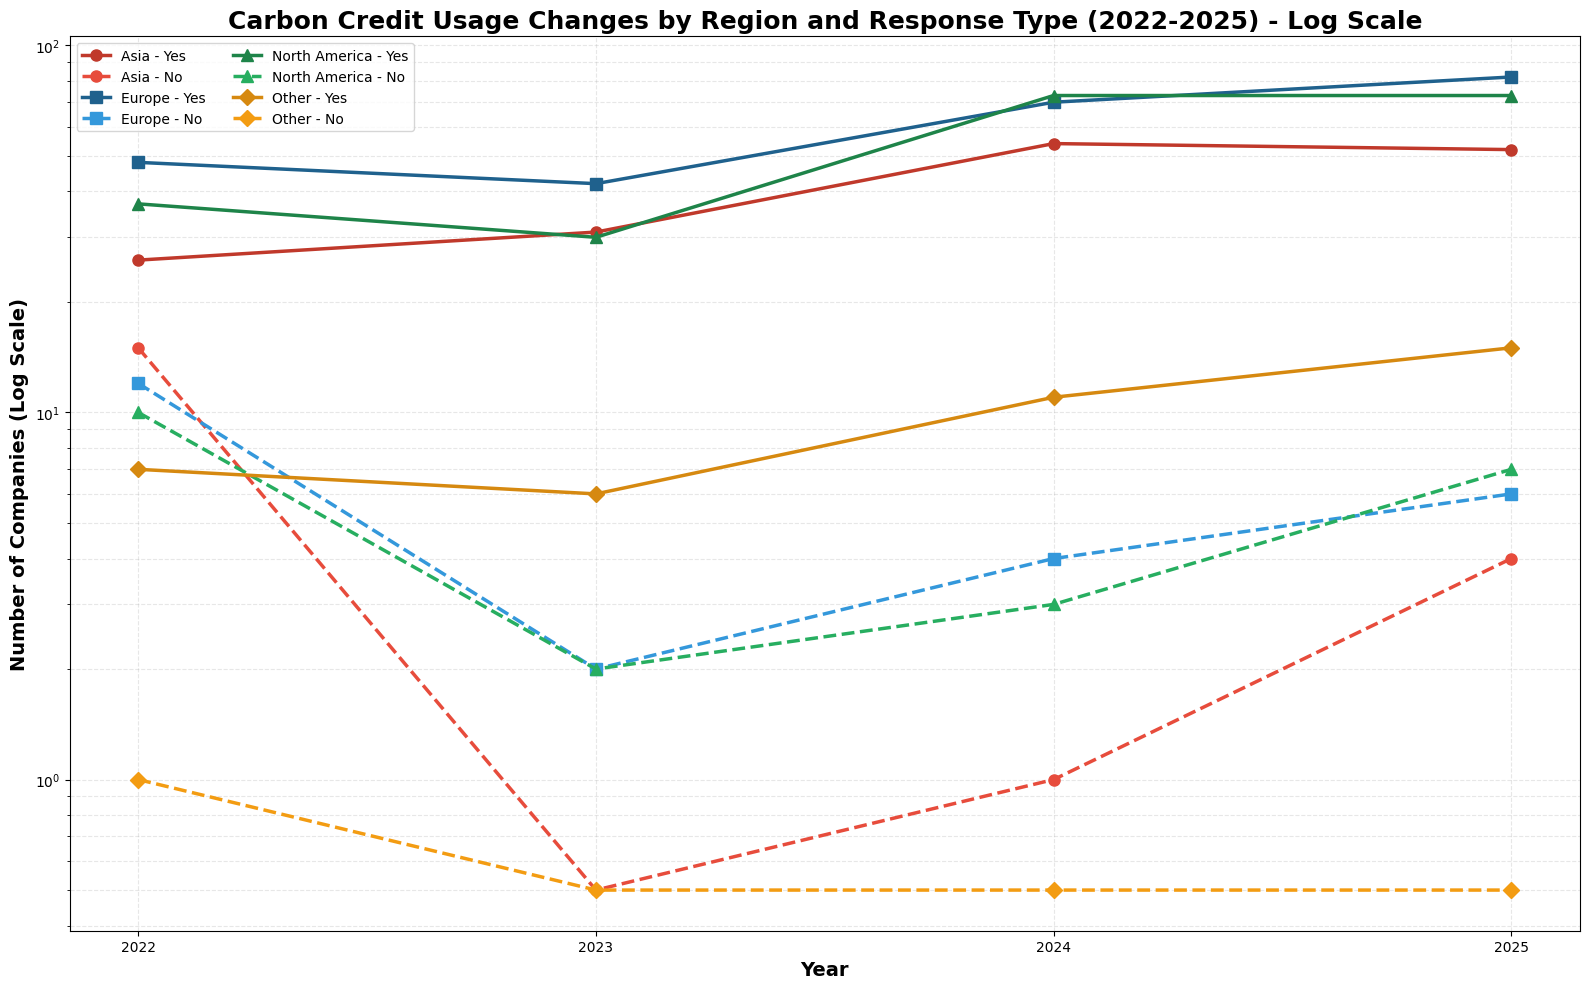

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# Data organized by year and region (from the image)
years = [2022, 2023, 2024, 2025]

# Yes usage
yes_asia = [26, 31, 54, 52]
yes_europe = [48, 42, 70, 82]
yes_na = [37, 30, 73, 73]
yes_other = [7, 6, 11, 15]

# No usage - replace 0s with 0.5 for log scale
no_asia = [15, 0.5, 1, 4]
no_europe = [12, 2, 4, 6]
no_na = [10, 2, 3, 7]
no_other = [1, 0.5, 0.5, 0.5]

# Unspecified
unspec_asia = [181, 183, 155, 142]
unspec_europe = [60, 68, 43, 42]
unspec_na = [93, 123, 81, 71]
unspec_other = [10, 13, 5, 6]

# Create single plot with all combinations
fig, ax = plt.subplots(figsize=(16, 10))
plt.title('Carbon Credit Usage Changes by Region and Response Type (2022-2025) - Log Scale', 
          fontsize=18, fontweight='bold')

# Define colors - different shades for each region
# Asia - Reds
color_asia_yes = '#C0392B'
color_asia_no = '#E74C3C'
color_asia_unspec = '#EC7063'

# Europe - Blues
color_europe_yes = '#1F618D'
color_europe_no = '#3498DB'
color_europe_unspec = '#5DADE2'

# North America - Greens
color_na_yes = '#1E8449'
color_na_no = '#27AE60'
color_na_unspec = '#52BE80'

# Other - Oranges/Yellows
color_other_yes = '#D68910'
color_other_no = '#F39C12'
color_other_unspec = '#F8C471'

# Plot all lines
# Asia
ax.plot(years, yes_asia, marker='o', linewidth=2.5, markersize=8, 
        label='Asia - Yes', color=color_asia_yes, linestyle='-')
ax.plot(years, no_asia, marker='o', linewidth=2.5, markersize=8, 
        label='Asia - No', color=color_asia_no, linestyle='--')


# Europe
ax.plot(years, yes_europe, marker='s', linewidth=2.5, markersize=8, 
        label='Europe - Yes', color=color_europe_yes, linestyle='-')
ax.plot(years, no_europe, marker='s', linewidth=2.5, markersize=8, 
        label='Europe - No', color=color_europe_no, linestyle='--')


# North America
ax.plot(years, yes_na, marker='^', linewidth=2.5, markersize=8, 
        label='North America - Yes', color=color_na_yes, linestyle='-')
ax.plot(years, no_na, marker='^', linewidth=2.5, markersize=8, 
        label='North America - No', color=color_na_no, linestyle='--')


# Other
ax.plot(years, yes_other, marker='D', linewidth=2.5, markersize=8, 
        label='Other - Yes', color=color_other_yes, linestyle='-')
ax.plot(years, no_other, marker='D', linewidth=2.5, markersize=8, 
        label='Other - No', color=color_other_no, linestyle='--')


# Set logarithmic scale
ax.set_yscale('log')

# Formatting
ax.set_xlabel('Year', fontsize=14, fontweight='bold')
ax.set_ylabel('Number of Companies (Log Scale)', fontsize=14, fontweight='bold')
ax.legend(loc='upper left', fontsize=10, ncol=2)
ax.grid(True, alpha=0.3, linestyle='--', which='both')
ax.set_xticks(years)

plt.tight_layout()
plt.savefig('cc_usage_all_combinations_log.png', dpi=300, bbox_inches='tight')
plt.show()

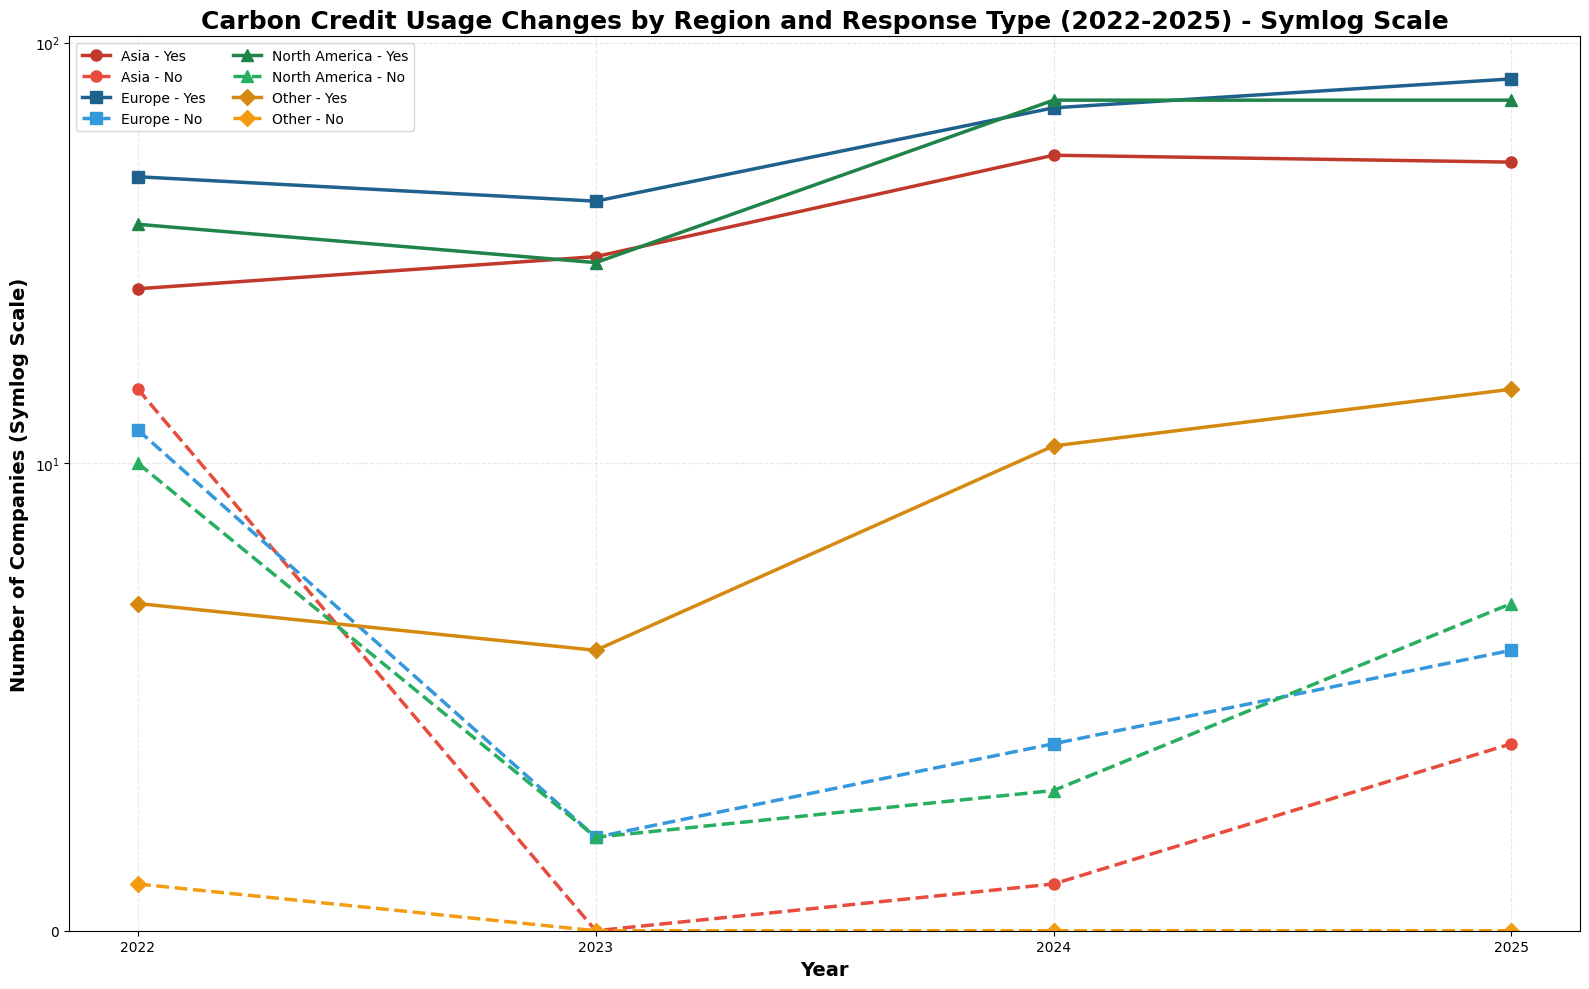

In [39]:
import matplotlib.pyplot as plt
import numpy as np

# Data organized by year and region (from the image)
years = [2022, 2023, 2024, 2025]

# Yes usage
yes_asia = [26, 31, 54, 52]
yes_europe = [48, 42, 70, 82]
yes_na = [37, 30, 73, 73]
yes_other = [7, 6, 11, 15]

# No usage
no_asia = [15, 0, 1, 4]
no_europe = [12, 2, 4, 6]
no_na = [10, 2, 3, 7]
no_other = [1, 0, 0, 0]

# Unspecified
unspec_asia = [181, 183, 155, 142]
unspec_europe = [60, 68, 43, 42]
unspec_na = [93, 123, 81, 71]
unspec_other = [10, 13, 5, 6]

# Create single plot with all combinations
fig, ax = plt.subplots(figsize=(16, 10))
plt.title('Carbon Credit Usage Changes by Region and Response Type (2022-2025) - Symlog Scale', 
          fontsize=18, fontweight='bold')

# Define colors - different shades for each region
# Asia - Reds
color_asia_yes = '#C0392B'
color_asia_no = '#E74C3C'
color_asia_unspec = '#EC7063'

# Europe - Blues
color_europe_yes = '#1F618D'
color_europe_no = '#3498DB'
color_europe_unspec = '#5DADE2'

# North America - Greens
color_na_yes = '#1E8449'
color_na_no = '#27AE60'
color_na_unspec = '#52BE80'

# Other - Oranges/Yellows
color_other_yes = '#D68910'
color_other_no = '#F39C12'
color_other_unspec = '#F8C471'

# Plot all lines
# Asia
ax.plot(years, yes_asia, marker='o', linewidth=2.5, markersize=8, 
        label='Asia - Yes', color=color_asia_yes, linestyle='-')
ax.plot(years, no_asia, marker='o', linewidth=2.5, markersize=8, 
        label='Asia - No', color=color_asia_no, linestyle='--')


# Europe
ax.plot(years, yes_europe, marker='s', linewidth=2.5, markersize=8, 
        label='Europe - Yes', color=color_europe_yes, linestyle='-')
ax.plot(years, no_europe, marker='s', linewidth=2.5, markersize=8, 
        label='Europe - No', color=color_europe_no, linestyle='--')


# North America
ax.plot(years, yes_na, marker='^', linewidth=2.5, markersize=8, 
        label='North America - Yes', color=color_na_yes, linestyle='-')
ax.plot(years, no_na, marker='^', linewidth=2.5, markersize=8, 
        label='North America - No', color=color_na_no, linestyle='--')


# Other
ax.plot(years, yes_other, marker='D', linewidth=2.5, markersize=8, 
        label='Other - Yes', color=color_other_yes, linestyle='-')
ax.plot(years, no_other, marker='D', linewidth=2.5, markersize=8, 
        label='Other - No', color=color_other_no, linestyle='--')

# Set symlog scale - linear near zero, logarithmic for larger values
# linthresh sets the range that's linear (values below 10 are linear, above 10 are log)
ax.set_yscale('symlog', linthresh=10)

# Formatting
ax.set_xlabel('Year', fontsize=14, fontweight='bold')
ax.set_ylabel('Number of Companies (Symlog Scale)', fontsize=14, fontweight='bold')
ax.legend(loc='upper left', fontsize=10, ncol=2)
ax.grid(True, alpha=0.3, linestyle='--', which='both')
ax.set_xticks(years)
ax.set_ylim(bottom=0)

plt.tight_layout()
plt.savefig('cc_usage_all_combinations_symlog.png', dpi=300, bbox_inches='tight')
plt.show()

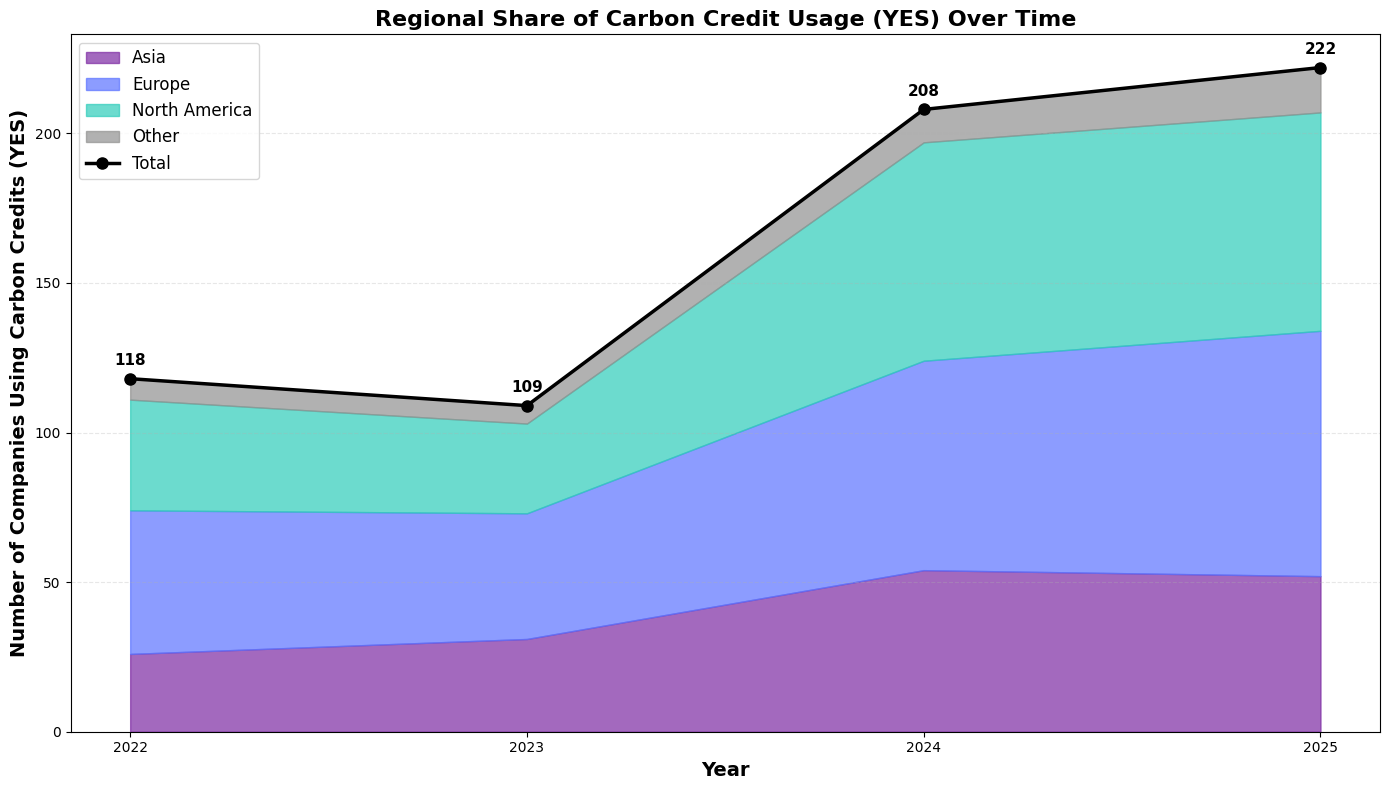

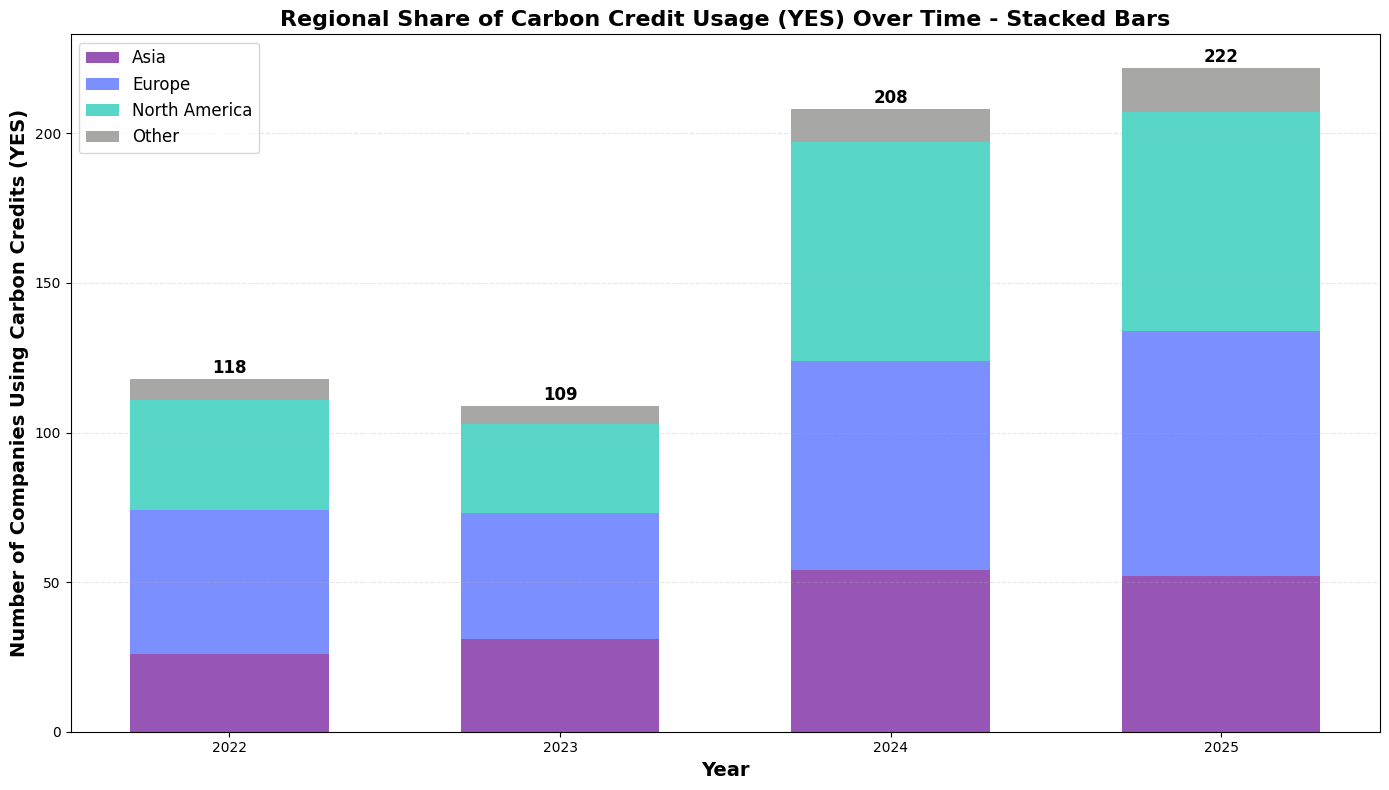

Both charts saved!
Totals by year: {2022: 118, 2023: 109, 2024: 208, 2025: 222}


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data for YES usage by region
years = [2022, 2023, 2024, 2025]

yes_asia = [26, 31, 54, 52]
yes_europe = [48, 42, 70, 82]
yes_na = [37, 30, 73, 73]
yes_other = [7, 6, 11, 15]

# Create stacked area chart
fig, ax = plt.subplots(figsize=(14, 8))

# Colors for each region
color_asia = "#7D2AA3"  # Red
color_europe = "#5B73FF"  # Blue
color_na = "#2ECCBA"  # Green
color_other = "#919190"  # Orange

# Create the stacked area plot
ax.fill_between(years, 0, yes_asia, 
                label='Asia', color=color_asia, alpha=0.7)
ax.fill_between(years, yes_asia, 
                np.array(yes_asia) + np.array(yes_europe),
                label='Europe', color=color_europe, alpha=0.7)
ax.fill_between(years, np.array(yes_asia) + np.array(yes_europe),
                np.array(yes_asia) + np.array(yes_europe) + np.array(yes_na),
                label='North America', color=color_na, alpha=0.7)
ax.fill_between(years, np.array(yes_asia) + np.array(yes_europe) + np.array(yes_na),
                np.array(yes_asia) + np.array(yes_europe) + np.array(yes_na) + np.array(yes_other),
                label='Other', color=color_other, alpha=0.7)

# Add total line on top
totals = [sum(x) for x in zip(yes_asia, yes_europe, yes_na, yes_other)]
ax.plot(years, totals, color='black', linewidth=2.5, marker='o', markersize=8, label='Total')

# Add value labels for totals
for i, (year, total) in enumerate(zip(years, totals)):
    ax.annotate(str(total), (year, total), textcoords="offset points", 
               xytext=(0, 10), ha='center', fontsize=11, fontweight='bold')

# Formatting
ax.set_xlabel('Year', fontsize=14, fontweight='bold')
ax.set_ylabel('Number of Companies Using Carbon Credits (YES)', fontsize=14, fontweight='bold')
ax.set_title('Regional Share of Carbon Credit Usage (YES) Over Time', fontsize=16, fontweight='bold')
ax.legend(loc='upper left', fontsize=12)
ax.grid(True, alpha=0.3, linestyle='--', axis='y')
ax.set_xticks(years)
ax.set_ylim(bottom=0)

plt.tight_layout()
plt.savefig('cc_yes_stacked_area.png', dpi=300, bbox_inches='tight')
plt.show()


# ALTERNATIVE: Stacked bar chart version
fig2, ax2 = plt.subplots(figsize=(14, 8))

width = 0.6
x = np.arange(len(years))

# Create stacked bars
bar1 = ax2.bar(x, yes_asia, width, label='Asia', color=color_asia, alpha=0.8)
bar2 = ax2.bar(x, yes_europe, width, bottom=yes_asia, 
               label='Europe', color=color_europe, alpha=0.8)
bar3 = ax2.bar(x, yes_na, width, 
               bottom=np.array(yes_asia) + np.array(yes_europe),
               label='North America', color=color_na, alpha=0.8)
bar4 = ax2.bar(x, yes_other, width,
               bottom=np.array(yes_asia) + np.array(yes_europe) + np.array(yes_na),
               label='Other', color=color_other, alpha=0.8)

# Add total labels on top of bars
for i, total in enumerate(totals):
    ax2.text(i, total + 2, str(total), ha='center', fontsize=12, fontweight='bold')

# Formatting
ax2.set_xlabel('Year', fontsize=14, fontweight='bold')
ax2.set_ylabel('Number of Companies Using Carbon Credits (YES)', fontsize=14, fontweight='bold')
ax2.set_title('Regional Share of Carbon Credit Usage (YES) Over Time - Stacked Bars', 
              fontsize=16, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(years)
ax2.legend(loc='upper left', fontsize=12)
ax2.grid(True, alpha=0.3, linestyle='--', axis='y')
ax2.set_ylim(bottom=0)

plt.tight_layout()
plt.savefig('cc_yes_stacked_bars.png', dpi=300, bbox_inches='tight')
plt.show()

print("Both charts saved!")
print(f"Totals by year: {dict(zip(years, totals))}")

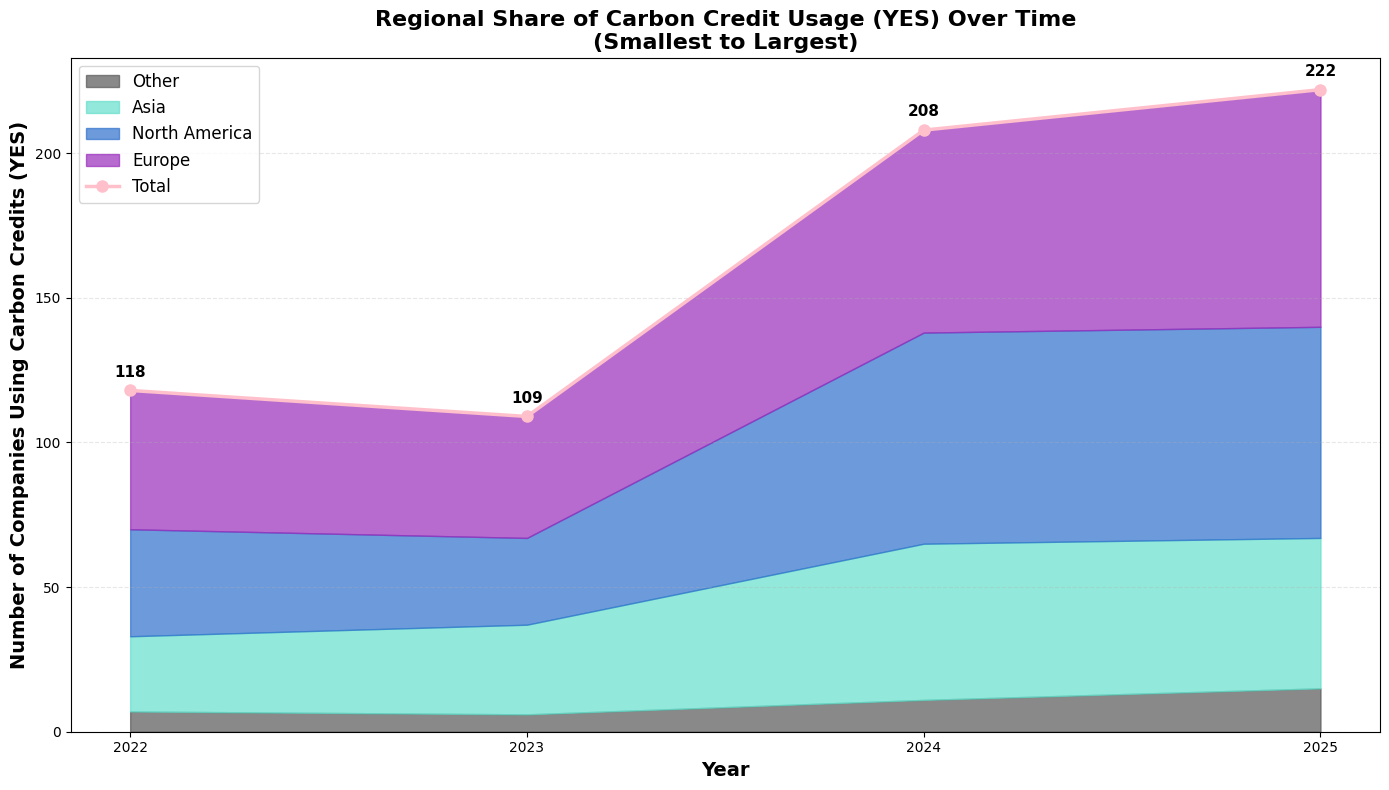

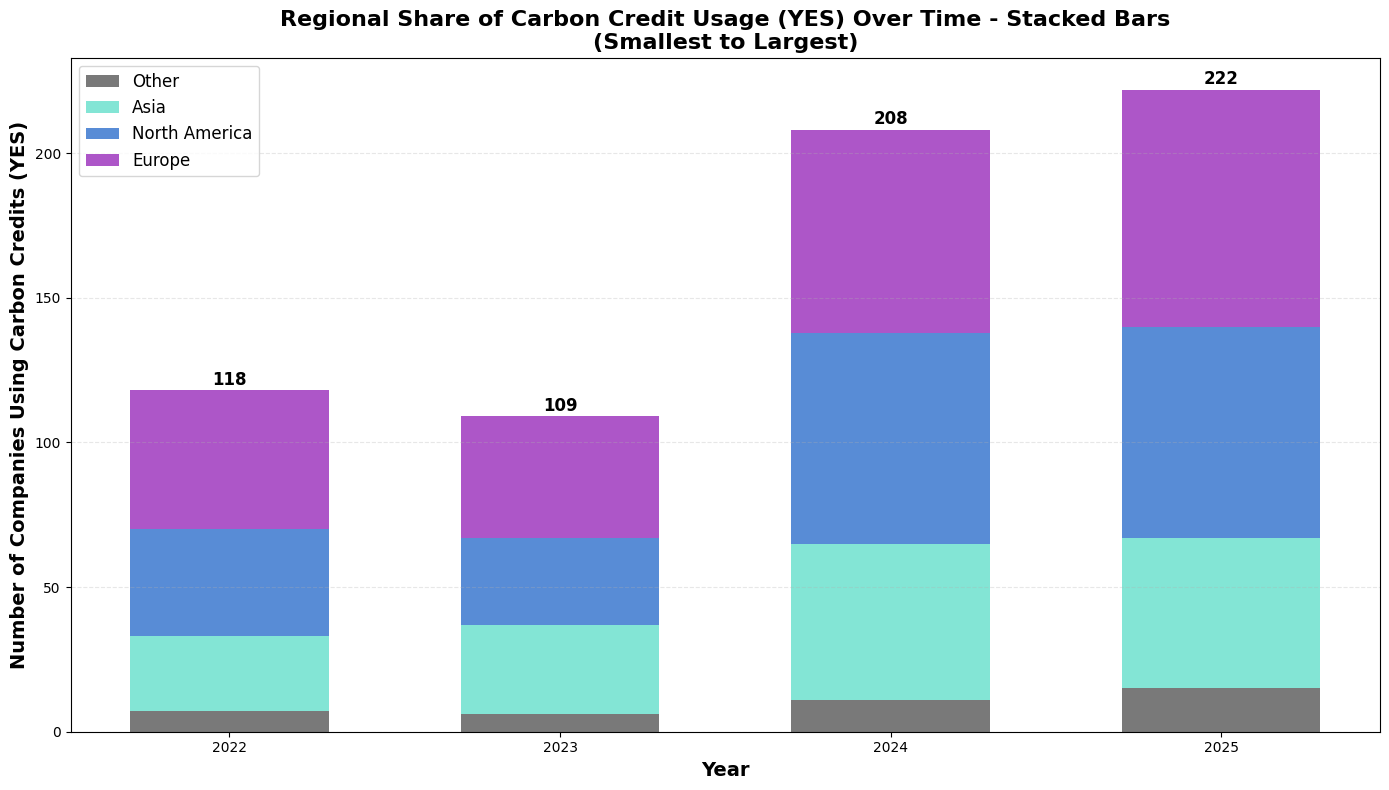

Both charts saved!
Totals by year: {2022: 118, 2023: 109, 2024: 208, 2025: 222}

Order from bottom to top: Other -> Asia -> North America -> Europe


In [42]:
import matplotlib.pyplot as plt
import numpy as np

# Data for YES usage by region
years = [2022, 2023, 2024, 2025]

yes_asia = [26, 31, 54, 52]
yes_europe = [48, 42, 70, 82]
yes_na = [37, 30, 73, 73]
yes_other = [7, 6, 11, 15]

# Create stacked area chart - SMALLEST TO LARGEST (bottom to top)
fig, ax = plt.subplots(figsize=(14, 8))

# Colors for each region
color_asia = "#64DFCB"  # Red
color_europe = "#992CBB"  # Blue
color_na = "#2E70CC"  # Green
color_other = "#575757"  # Orange

# Stack from smallest to largest: Other -> Asia -> NA -> Europe
ax.fill_between(years, 0, yes_other, 
                label='Other', color=color_other, alpha=0.7)
ax.fill_between(years, yes_other, 
                np.array(yes_other) + np.array(yes_asia),
                label='Asia', color=color_asia, alpha=0.7)
ax.fill_between(years, np.array(yes_other) + np.array(yes_asia),
                np.array(yes_other) + np.array(yes_asia) + np.array(yes_na),
                label='North America', color=color_na, alpha=0.7)
ax.fill_between(years, np.array(yes_other) + np.array(yes_asia) + np.array(yes_na),
                np.array(yes_other) + np.array(yes_asia) + np.array(yes_na) + np.array(yes_europe),
                label='Europe', color=color_europe, alpha=0.7)

# Add total line on top
totals = [sum(x) for x in zip(yes_asia, yes_europe, yes_na, yes_other)]
ax.plot(years, totals, color='Pink', linewidth=2.5, marker='o', markersize=8, label='Total')

# Add value labels for totals
for i, (year, total) in enumerate(zip(years, totals)):
    ax.annotate(str(total), (year, total), textcoords="offset points", 
               xytext=(0, 10), ha='center', fontsize=11, fontweight='bold')

# Formatting
ax.set_xlabel('Year', fontsize=14, fontweight='bold')
ax.set_ylabel('Number of Companies Using Carbon Credits (YES)', fontsize=14, fontweight='bold')
ax.set_title('Regional Share of Carbon Credit Usage (YES) Over Time\n(Smallest to Largest)', 
             fontsize=16, fontweight='bold')
ax.legend(loc='upper left', fontsize=12)
ax.grid(True, alpha=0.3, linestyle='--', axis='y')
ax.set_xticks(years)
ax.set_ylim(bottom=0)

plt.tight_layout()
plt.savefig('cc_yes_stacked_area_ordered.png', dpi=300, bbox_inches='tight')
plt.show()


# ALTERNATIVE: Stacked bar chart version - SMALLEST TO LARGEST
fig2, ax2 = plt.subplots(figsize=(14, 8))

width = 0.6
x = np.arange(len(years))

# Create stacked bars from smallest to largest
bar1 = ax2.bar(x, yes_other, width, label='Other', color=color_other, alpha=0.8)
bar2 = ax2.bar(x, yes_asia, width, bottom=yes_other, 
               label='Asia', color=color_asia, alpha=0.8)
bar3 = ax2.bar(x, yes_na, width, 
               bottom=np.array(yes_other) + np.array(yes_asia),
               label='North America', color=color_na, alpha=0.8)
bar4 = ax2.bar(x, yes_europe, width,
               bottom=np.array(yes_other) + np.array(yes_asia) + np.array(yes_na),
               label='Europe', color=color_europe, alpha=0.8)

# Add total labels on top of bars
for i, total in enumerate(totals):
    ax2.text(i, total + 2, str(total), ha='center', fontsize=12, fontweight='bold')

# Formatting
ax2.set_xlabel('Year', fontsize=14, fontweight='bold')
ax2.set_ylabel('Number of Companies Using Carbon Credits (YES)', fontsize=14, fontweight='bold')
ax2.set_title('Regional Share of Carbon Credit Usage (YES) Over Time - Stacked Bars\n(Smallest to Largest)', 
              fontsize=16, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(years)
ax2.legend(loc='upper left', fontsize=12)
ax2.grid(True, alpha=0.3, linestyle='--', axis='y')
ax2.set_ylim(bottom=0)

plt.tight_layout()
plt.savefig('cc_yes_stacked_bars_ordered.png', dpi=300, bbox_inches='tight')
plt.show()

print("Both charts saved!")
print(f"Totals by year: {dict(zip(years, totals))}")
print("\nOrder from bottom to top: Other -> Asia -> North America -> Europe")

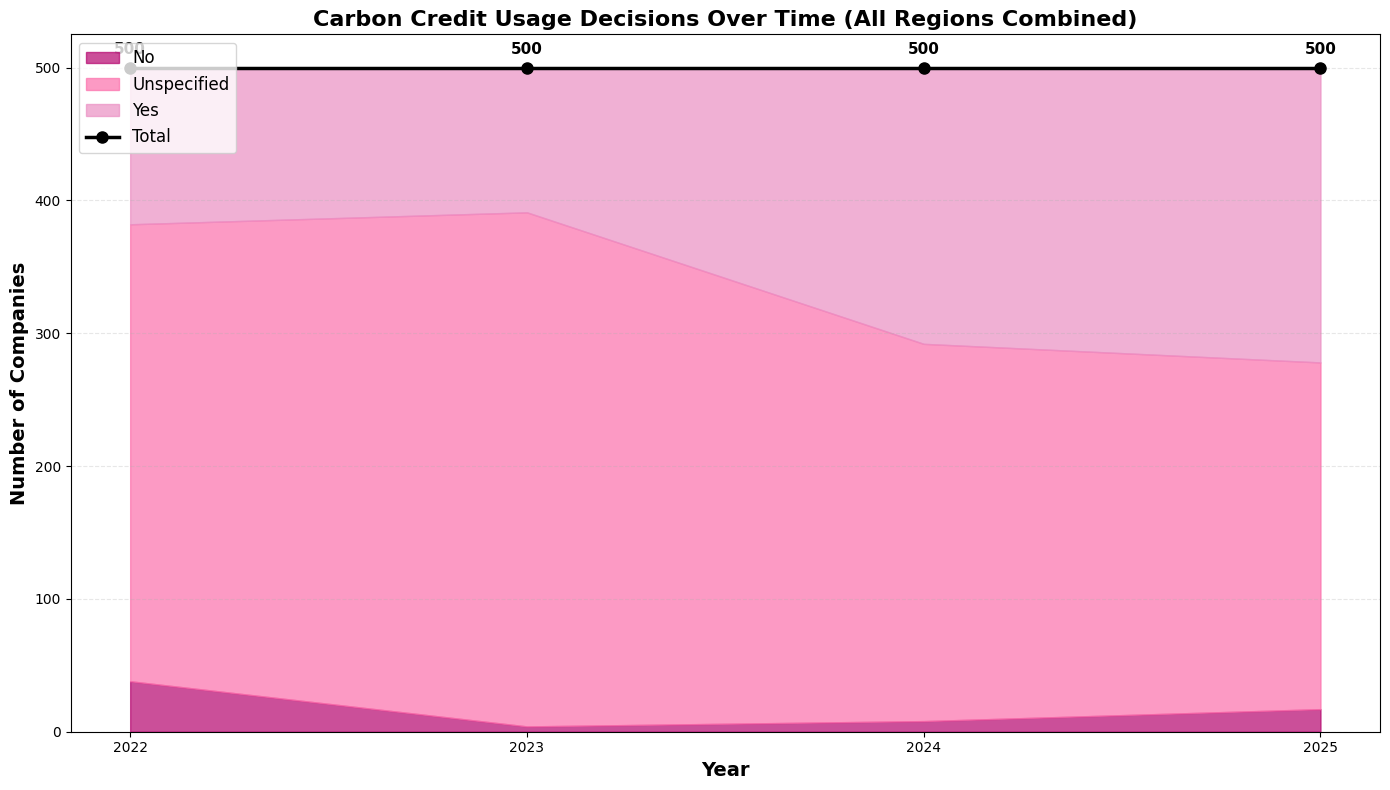

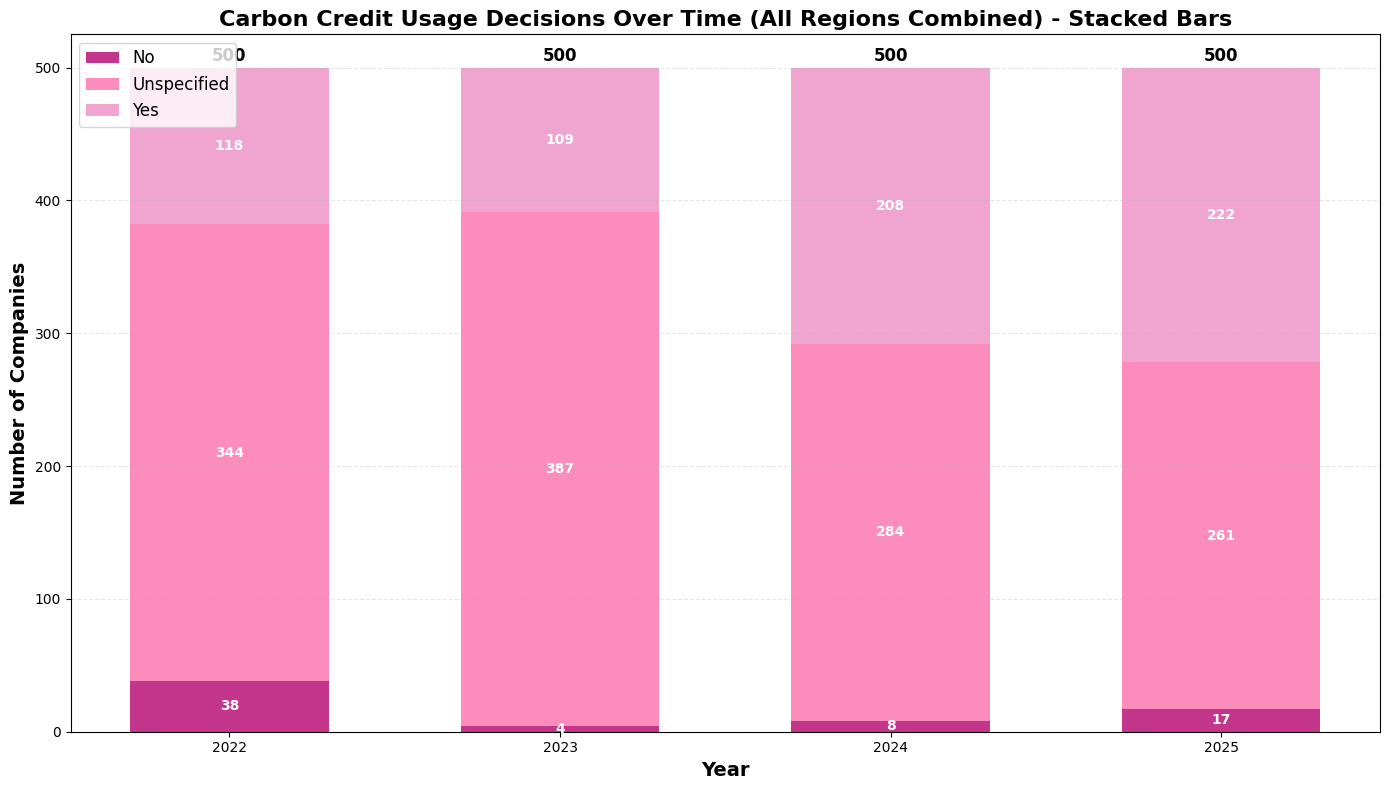

Both charts saved!
Totals by year: {2022: 500, 2023: 500, 2024: 500, 2025: 500}

Yes totals: {2022: 118, 2023: 109, 2024: 208, 2025: 222}
No totals: {2022: 38, 2023: 4, 2024: 8, 2025: 17}
Unspecified totals: {2022: 344, 2023: 387, 2024: 284, 2025: 261}

Order from bottom to top: No -> Unspecified -> Yes


In [43]:
import matplotlib.pyplot as plt
import numpy as np

# Data for each response type (ALL REGIONS COMBINED)
years = [2022, 2023, 2024, 2025]

# Calculate totals across all regions for each response type
# Yes totals
yes_totals = [118, 109, 208, 222]  
# No totals
no_totals = [38, 4, 8, 17]  # 15+12+10+1, 0+2+2+0, 1+4+3+0, 4+6+7+0

# Unspecified totals
unspec_totals = [344, 387, 284, 261]  # 181+60+93+10, 183+68+123+13, 155+43+81+5, 142+42+71+6

# Create stacked area chart - NO (bottom) -> UNSPECIFIED (middle) -> YES (top)
fig, ax = plt.subplots(figsize=(14, 8))

# Colors
color_no = "#B5046E"  # Red
color_unspec = "#FC6FAC"  # Gray
color_yes = "#EB8FC3"  # Green

# Stack from bottom to top: No -> Unspecified -> Yes
ax.fill_between(years, 0, no_totals, 
                label='No', color=color_no, alpha=0.7)
ax.fill_between(years, no_totals, 
                np.array(no_totals) + np.array(unspec_totals),
                label='Unspecified', color=color_unspec, alpha=0.7)
ax.fill_between(years, np.array(no_totals) + np.array(unspec_totals),
                np.array(no_totals) + np.array(unspec_totals) + np.array(yes_totals),
                label='Yes', color=color_yes, alpha=0.7)

# Add total line on top
totals = [sum(x) for x in zip(yes_totals, no_totals, unspec_totals)]
ax.plot(years, totals, color='black', linewidth=2.5, marker='o', markersize=8, label='Total')

# Add value labels for totals
for i, (year, total) in enumerate(zip(years, totals)):
    ax.annotate(str(total), (year, total), textcoords="offset points", 
               xytext=(0, 10), ha='center', fontsize=11, fontweight='bold')

# Formatting
ax.set_xlabel('Year', fontsize=14, fontweight='bold')
ax.set_ylabel('Number of Companies', fontsize=14, fontweight='bold')
ax.set_title('Carbon Credit Usage Decisions Over Time (All Regions Combined)', 
             fontsize=16, fontweight='bold')
ax.legend(loc='upper left', fontsize=12)
ax.grid(True, alpha=0.3, linestyle='--', axis='y')
ax.set_xticks(years)
ax.set_ylim(bottom=0)

plt.tight_layout()
plt.savefig('cc_response_types_stacked_area.png', dpi=300, bbox_inches='tight')
plt.show()


# ALTERNATIVE: Stacked bar chart version
fig2, ax2 = plt.subplots(figsize=(14, 8))

width = 0.6
x = np.arange(len(years))

# Create stacked bars - No (bottom) -> Unspecified (middle) -> Yes (top)
bar1 = ax2.bar(x, no_totals, width, label='No', color=color_no, alpha=0.8)
bar2 = ax2.bar(x, unspec_totals, width, bottom=no_totals, 
               label='Unspecified', color=color_unspec, alpha=0.8)
bar3 = ax2.bar(x, yes_totals, width, 
               bottom=np.array(no_totals) + np.array(unspec_totals),
               label='Yes', color=color_yes, alpha=0.8)

# Add total labels on top of bars
for i, total in enumerate(totals):
    ax2.text(i, total + 5, str(total), ha='center', fontsize=12, fontweight='bold')

# Add individual segment labels
for i in range(len(years)):
    # No label
    ax2.text(i, no_totals[i]/2, str(no_totals[i]), ha='center', va='center', 
             fontsize=10, fontweight='bold', color='white')
    # Unspecified label
    ax2.text(i, no_totals[i] + unspec_totals[i]/2, str(unspec_totals[i]), 
             ha='center', va='center', fontsize=10, fontweight='bold', color='white')
    # Yes label
    ax2.text(i, no_totals[i] + unspec_totals[i] + yes_totals[i]/2, str(yes_totals[i]), 
             ha='center', va='center', fontsize=10, fontweight='bold', color='white')

# Formatting
ax2.set_xlabel('Year', fontsize=14, fontweight='bold')
ax2.set_ylabel('Number of Companies', fontsize=14, fontweight='bold')
ax2.set_title('Carbon Credit Usage Decisions Over Time (All Regions Combined) - Stacked Bars', 
              fontsize=16, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(years)
ax2.legend(loc='upper left', fontsize=12)
ax2.grid(True, alpha=0.3, linestyle='--', axis='y')
ax2.set_ylim(bottom=0)

plt.tight_layout()
plt.savefig('cc_response_types_stacked_bars.png', dpi=300, bbox_inches='tight')
plt.show()

print("Both charts saved!")
print(f"Totals by year: {dict(zip(years, totals))}")
print(f"\nYes totals: {dict(zip(years, yes_totals))}")
print(f"No totals: {dict(zip(years, no_totals))}")
print(f"Unspecified totals: {dict(zip(years, unspec_totals))}")
print("\nOrder from bottom to top: No -> Unspecified -> Yes")